# 1 Initial EDA for DCVs in all LNs and PNs and about 2/5 of ORNs

This project aims to look at neuropeptide signaling in the Drosophila antennal lobe. Specifically, we are looking in three cell types (ORN, PN, LN) in the DM6 glomerulus. Neuropeptides are stored in dense core vesicles (DCVs), thus we can identify the localization/number of DCVs within cells to get an idea of how these cells may participate in neuropeptide signaling and how this might affect neuronal circuits/computations.

We have almost entire ORNs reconstructed (except for processes exiting the antennal nerve), the anterior region of PNs, and LN fragments projecting only within the DM6 glomerulus. While there is evidence that ORNs, PNs, and LNs can express neuropeptides, no studies have looked at this in detail. For example, do all of these neurons contain DCVs? Where are DCVs within cells? Do they tend to cluster within pre- and/or post-synaptic sites?

In this notebook we have:
* Analysis of DCV diameter in all and across cells
* Analysis of DCV fill in all and across cells
* Analysis of DCV docking to plasma membrane and mitos in all and across cells
* Number of DCVs/µm in entire cells and within DM6 region alone (some of the plots were made in prism, so it's worth taking a look at those files)
* Initial playing around with how to compute #DCVs/pre or post synaptic site - did a test to see how close synaptic sites are to each other. If we were to use PS's criteria of assigning a synaptic site's zone to be 1000nm radius and any DCVs falling within that region would "belong" to that synaptic site, we need to make sure that these "zones" overlap. --- Update on this. There is major overlap and we decided that this is not a good way to assign zone as we can have synaptic sites and DCVs close together when associated with different branches. Instead, we are going to use measure distance via pathlength (along skeleton) and do some analyses on the raw data to get a more accurate measure of how big synaptic sites are. Wei has the feeling that 1000nm radius is too big.

In [1]:
#Various imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from io import StringIO
import seaborn as sns
import sys
import plotly
import igraph
from statsmodels.stats.multicomp import pairwise_tukeyhsd
%matplotlib inline 
from matplotlib import rcParams

# Get pymaid tools
%cd /Users/hannah/git/pymaid
import sys
sys.path.append('PATH_CONTAINING_PYMAID.PY')
from pymaid.pymaid import CatmaidInstance, get_connectors, get_arbor, get_partners, get_connector_details, get_edges, get_3D_skeleton
from pymaid.plot import plot2d, plot3d
from pymaid.morpho import generate_list_of_childs, classify_nodes, cut_neuron, calc_cable

# Get passwords and sensitive data
import os
import dotenv
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

CATMAID_USERNAME = os.getenv('CATMAID_USERNAME')
CATMAID_PASSWORD = os.getenv('CATMAID_PASSWORD')
CATMAID_API_KEY = os.getenv('CATMAID_API_KEY')



#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
# rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
# rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 18

/Users/hannah/git/PyMaid


/Users/hannah/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:913: UserWarning:

axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.



# Pulling in and organizing data from CATMAID

Pulling data in from CATMAID, organizing info (stored in tags) about DCV details into df, and cleaning/checking that data look good and are free of typos.

In [2]:
# Create Catmaid instance
Myinstance = CatmaidInstance( 'http://catmaid.hms.harvard.edu/catmaid3' , 
                                  CATMAID_USERNAME, 
                                  CATMAID_PASSWORD, 
                                  CATMAID_API_KEY)

2018-04-19 17:09:56,139 - pymaid.pymaid - INFO - CATMAID instance created


In [3]:
# Get all DCVs (and their meta data) identified in all the neurons (ID'ed by their skeleton_ID) I screened for DCVs.

# Skeleton ID for neurons (with reviws) done by 8/7/17
ORNs = ['75022', '214902', '206984', '197072', '146356', '208985', '142725', '203583', '103373',
       '188110', '52598', '91515', '185052', '54588', '168431', '130007', '77885', '120789', '157043',
        '173737']
PNs = ['109478', '157967', '200272', '60706', '135327']
LNs = ['409776', '68585', '416110', '194509', '204239', '155131', '429586', '454047', '431394', '108967', '124100',
       '162723', '57278', '157781','216398', '80018', '218979', '148694', '180390', '34465', '80973', '44197', '119571',
       '118046', '193410', '141893', '187995', '107173', '167341', '178745', '144342', '412072', '142202',
       '37350', '81961', '143324', '199873', '218143', '100641', '185700']
all_neurons = ORNs + PNs + LNs

#Retrieve all abutting connectors for neurons
all_DCV_df = get_connectors(   all_neurons,
                            Myinstance,
                            incoming_synapses = False,
                            outgoing_synapses = False,
                            abutting = True,
                            gap_junctions = False,
                            project_id = 3,
                            tag_flag = True
                        )
print('Connectors retrieved:', len(all_DCV_df))

2018-01-12 16:19:09,361 - pymaid.pymaid - INFO - 22521 connectors for 65 neurons retrieved


Connectors retrieved: 22521


In [4]:
test = ['75022']
MF1_partners_df = get_partners(test,
                            remote_instance = Myinstance,
                            project_id = 3)
print('partners retrieved:', len(MF1_partners_df))
MF1_partners_df.head()

2018-01-12 16:19:09,372 - pymaid.pymaid - INFO - Fetching connectivity
2018-01-12 16:19:10,202 - pymaid.pymaid - INFO - Done. Found 40 up- 106 downstream neurons


partners retrieved: 146


,neuron_name,skeleton_id,num_nodes,relation,75022
0,Neuron 521928,125982,545,upstream,1
1,DM6 ORN 2,214902,3901,upstream,1
2,neuron 468437,220640,651,upstream,3
3,neuron 473733,180895,409,upstream,1
4,DM6 ORN 48,59426,3907,upstream,1


In [5]:
# Are there duplicated DCVs?
all_DCV_df_test = all_DCV_df.copy()
all_DCV_df_test = all_DCV_df_test.sort_values(by = ['connector_id'])
all_DCV_df_test.reset_index(drop = True, inplace = True)
all_DCV_df_test = all_DCV_df_test.drop_duplicates(subset = ['connector_id'], keep = 'first')
print(all_DCV_df_test.shape)
print(all_DCV_df.shape)

non_dup_DCVs = all_DCV_df_test['connector_id'].tolist()

(13371, 12)
(22521, 12)


Ahhhhhh! Yes, it looks like there are a good number of duplicated DCVs (>9,000). Note that it does not look like all DCVs are being duplicated, just a subset. What is going on here? Note that if I run ORNs, PNs, or LNs independently I don't see duplication. Phillip had a note in his code that CATMAID API only lets you pass 50 neurons in at a time, so he did some grouping, etc. Perhaps there was an error there? Ahhh, bummer. Will also need to look at pre/post synaptic connector duplicates as well. For now, lets see if we are getting duplicates in all neurons or just a subset.

In [6]:
# Get list of duplicated DCVs
duplicated_DCVs = all_DCV_df[all_DCV_df.duplicated(subset = ['connector_id'], keep=False)]
duplicated_DCVs = duplicated_DCVs.drop_duplicates(subset = ['connector_id'])

# Find skel_ids that show duplicated DCVs
dupl_DCVs_skel_id = duplicated_DCVs['skeleton_id'].tolist()

# Get list of skel_ids showing dup pre/post sites
dupl_DCVs_skel_id = list(set(dupl_DCVs_skel_id))
print(len(dupl_DCVs_skel_id))

35


43 neurons show duplicated DCVs. I am just going to run ORNs, PNs, and LNs, independently and merge the dataframes after. It looks like there are no errors when I do this.

In [7]:
#Retrieve all abutting connectors for neurons
# ORNs
ORNs_DCV_df = get_connectors(   ORNs,
                            Myinstance,
                            incoming_synapses = False,
                            outgoing_synapses = False,
                            abutting = True,
                            gap_junctions = False,
                            project_id = 3,
                            tag_flag = True
                        )
print('Connectors retrieved:', len(ORNs_DCV_df))

# PNs
PNs_DCV_df = get_connectors(   PNs,
                            Myinstance,
                            incoming_synapses = False,
                            outgoing_synapses = False,
                            abutting = True,
                            gap_junctions = False,
                            project_id = 3,
                            tag_flag = True
                        )
print('Connectors retrieved:', len(PNs_DCV_df))

# LNs
LNs_DCV_df = get_connectors(   LNs,
                            Myinstance,
                            incoming_synapses = False,
                            outgoing_synapses = False,
                            abutting = True,
                            gap_junctions = False,
                            project_id = 3,
                            tag_flag = True
                        )
print('Connectors retrieved:', len(LNs_DCV_df))

df = pd.concat([ORNs_DCV_df, PNs_DCV_df, LNs_DCV_df],axis=0)
df.reset_index(drop = True, inplace = True)
df.head()

2018-01-12 16:19:10,572 - pymaid.pymaid - INFO - 2099 connectors for 20 neurons retrieved


Connectors retrieved: 2099


2018-01-12 16:19:10,824 - pymaid.pymaid - INFO - 2419 connectors for 5 neurons retrieved


Connectors retrieved: 2419


2018-01-12 16:19:11,662 - pymaid.pymaid - INFO - 8853 connectors for 40 neurons retrieved


Connectors retrieved: 8853


,skeleton_id,connector_id,x,y,z,confidence,creator_id,treenode_id,creation_time,edition_time,type,tags
0,75022,13748947,409556,236636,14960,5,101,653871,2017-04-03T15:21:29.525285+00:00,2017-04-03T15:21:29.525307+00:00,abutting,"[39, DCV, med]"
1,75022,13748945,406126,237142,10760,5,101,654104,2017-04-03T15:19:55.019487+00:00,2017-04-03T15:19:55.019507+00:00,abutting,"[38, DCV, mhalo]"
2,75022,13748943,410982,239006,16520,5,101,653794,2017-04-03T15:17:01.474349+00:00,2017-04-03T15:17:01.474372+00:00,abutting,"[45, DCV, small]"
3,75022,13748941,411066,238938,16440,5,101,653797,2017-04-03T15:16:51.817604+00:00,2017-04-03T15:16:51.817631+00:00,abutting,"[35, DCV]"
4,75022,13748939,405674,242092,14920,5,101,654877,2017-04-03T15:16:19.981029+00:00,2017-04-03T15:16:19.981056+00:00,abutting,"[36, DCV]"


In [8]:
#Drop unnecessary columns
df = df.drop(['confidence', 'creator_id', 'creation_time', 'edition_time'], axis=1)

#Create columns for tags
df['DCV'] = False
df['diameter'] = 'None'
df['fill'] = 'None'
df['small'] = 'None'
df['tethered'] = 'None'
df['DCV_partner_skel_id'] = 'None'
df['mito'] = 'None'
df['t_bar'] = 'None'

df.head()

,skeleton_id,connector_id,x,y,z,treenode_id,type,tags,DCV,diameter,fill,small,tethered,DCV_partner_skel_id,mito,t_bar
0,75022,13748947,409556,236636,14960,653871,abutting,"[39, DCV, med]",False,None,None,None,None,None,None,None
1,75022,13748945,406126,237142,10760,654104,abutting,"[38, DCV, mhalo]",False,None,None,None,None,None,None,None
2,75022,13748943,410982,239006,16520,653794,abutting,"[45, DCV, small]",False,None,None,None,None,None,None,None
3,75022,13748941,411066,238938,16440,653797,abutting,"[35, DCV]",False,None,None,None,None,None,None,None
4,75022,13748939,405674,242092,14920,654877,abutting,"[36, DCV]",False,None,None,None,None,None,None,None


In [9]:
# Get all DCV info into dataframe
for (index, row) in df.iterrows():
    if 'DCV' in df['tags'][index]:
#         print(index)
        df.iat[index, 8] = 'True'
        
    # Get radius and compute diameter. Know that first value is radius
    df.iat[index, 9] = (int(df['tags'][index][0])*2)
        
    # Get fill
    if 'med' in df['tags'][index]:
        df.iat[index, 10] = 'med'
    elif 'mhalo' in df['tags'][index]:
        df.iat[index, 10] = 'mhalo'
    elif 'mahlo' in df['tags'][index]:
        df.iat[index, 10] = 'mhalo'
    elif 'dark' in df['tags'][index]:
        df.iat[index, 10] = 'dark'
    else: 
        df.iat[index, 10] = 'halo'
            
    # Get small core
    if 'small' in df['tags'][index]:
        df.iat[index, 11] = True
    else:
        df.iat[index, 11] = False
            
    # Is the DCV tethered/docked to membrane?
    # Docked
    if 'docked' in df['tags'][index]:
        df.iat[index, 12] = 'docked'
            
        # Get put post-synaptic partner
        for i, tag in enumerate(df['tags'][index]):
            if df['tags'][index][i].startswith('p'):
                df.iat[index, 13] = tag[1:]
                    
    # tethered with tail
    if 'tail' in df['tags'][index]:
        df.iat[index, 12] = 'tail'
            
        # Get put post-synaptic partner
        for i, tag in enumerate(df['tags'][index]):
            if df['tags'][index][i].startswith('p'):
                df.iat[index, 13] = tag[1:]
                    
    # Attached to mito?
    if 'mito_tail' in df['tags'][index]:
        df.iat[index, 14] = 'mito_tail'
    elif 'mito_docked' in df['tags'][index]:
        df.iat[index, 14] = 'mito_docked'
        
    # Attached to t_bar?
    if 't_bar' in df['tags'][index]:
        df.iat[index, 15] = 't_bar'
    elif 't_bar_tail' in df['tags'][index]:
        df.iat[index, 15] = 't_bar_tail'

In [10]:
#Get cell type
#Add new colums
df['cell_type'] = 'None'

for (index, row) in df.iterrows():
    if str(df.iat[index, 0]) in ORNs:
        df.iat[index, 16] = 'ORN'
    elif str(df.iat[index, 0]) in PNs:
        df.iat[index, 16] = 'PN'
    elif str(df.iat[index, 0]) in LNs:
        df.iat[index, 16] = 'LN'

In [11]:
# Also get cell number. This is important because there are a couple of LNs that have been broken into two fragments
# When really they are the same cell.

# Get neuron names (note that these are in the same order as the skel ID numbers listed above in cell 3)
ORN_names = ['DM6 ORN 1', 'DM6 ORN 2', 'DM6 ORN 3', 'DM6 ORN 4', 'DM6 ORN 5', 'DM6 ORN 6', 'DM6 ORN 7', 'DM6 ORN 8',
             'DM6 ORN 9', 'DM6 ORN 10', 'DM6 ORN 11', 'DM6 ORN 12', 'DM6 ORN 13', 'DM6 ORN 14', 'DM6 ORN 15',
             'DM6 ORN 16', 'DM6 ORN 17', 'DM6 ORN 18', 'DM6 ORN 19', 'DM6 ORN 21']
PN_names = ['PN1 LS', 'PN1 RS', 'PN2 LS', 'PN2 RS', 'PN3 LS']
LN_names = ['LN 1.DM6', 'LN 2.DM6', 'LN 3.DM6', 'LN 4.DM6', 'LN 5.DM6', 'LN 6.DM6', 'LN 8.DM6', 'LN 9.DM6',
            'LN 9.DM6', 'LN 12.DM6', 'LN 13.DM6', 'LN 14.DM6', 'LN 16.DM6', 'LN 17.DM6', 'LN 18.DM6', 'LN 20.DM6',
            'LN 23.DM6', 'LN 24.DM6', 'LN 25.DM6', 'LN 25.DM6', 'LN 27.DM6', 'LN 28.DM6', 'LN 29.DM6', 'LN 31.DM6', 
            'LN 35.DM6', 'LN 36.DM6', 'LN 40.DM6', 'LN 43.DM6', 'LN 43.DM6', 'LN 46.DM6', 'LN 52.DM6',
            'LN 59.DM6', 'LN 61.DM6', 'LN 63.DM6', 'LN 65.DM6', 'LN 67.DM6', 'LN 68.DM6', 'LN 76.DM6', 'LN 78.DM6',
            'LN 79.DM6']

all_neuron_names = ORN_names + PN_names + LN_names

# Check to make sure the skel_ID list and neuron name list are the same length
# print(len(all_neurons), len(all_neuron_names))

# Make a dictionary for the skel ID and neuron names (note that split LNs now have the same name, no _a or _b)
neuron_dictionary = dict(zip(all_neurons, all_neuron_names))

#Add new colums
df['neuron_name'] = 'None'

for (index, row) in df.iterrows():
    neuron_name = str(df.iat[index, 0])
    df.iat[index, 17] = neuron_dictionary[neuron_name]

In [12]:
# Have DCVs from all neurons been found?
# for skel_id, neuron_name in neuron_dictionary.items(): 
#     print (key, value)

DCVs_from_these_neurons = df.neuron_name.unique()

# Have DCVs from all neurons except LN 40 and LN 79, which do not have DCVs
# So we're good!
missing_neurons = [x for x in all_neuron_names if x not in DCVs_from_these_neurons]
missing_neurons

['LN 40.DM6', 'LN 79.DM6']

In [13]:
# Check for tag typos

# List of possible tag types
typo_tags = []

# List of valid tags
valid_tags = ['DCV', 'mito_tail', 'mahlo', 'mito_docked', 'med', 'mhalo', 'tail', 'docked', 't_bar', 'small', 'dark', 't_bar_tail']

for (index, row) in df.iterrows():
    for i, tag in enumerate(df['tags'][index]):
        #if not digit
        if not df['tags'][index][i].isdigit():
            # if it does not start with p (put postsynaptic partner)
            if not df['tags'][index][i].startswith('p'):
                #Check if tag is valid
                if df['tags'][index][i] not in valid_tags:
                    typo_tags += tag, index, i
                    
# Radius typos
radius_typos = []

for (index, row) in df.iterrows():
    if df['diameter'][index] < 30:
        radius_typos += index, df['diameter'][index]
    if df['diameter'][index] > 200:
        radius_typos += index, df['diameter'][index]
        
                    
print(typo_tags)
print(radius_typos)
#df[19307:19308]

[]
[]


In [14]:
# Check if you are missing any diameter values
df.head()
for (index, row) in df.iterrows():
    if df.iat[index, 9] == 'None':
        print('index of rows with missing diameter values:', None)   
#     elif isinstance((df.iat[index, 9]), int):
#         print('yeah, that is an int!', index)          

In [15]:
# Check if there are missing postsynaptic partners in docked or tailed DCVs
## No longer relevent as I stopped collecting put pp data because the recent CATMAID update made gathering this info
## very difficult, and I don't think it's worth the effort (since it is just an approximation of putative targets)
# no_PP = []

# for (index, row) in df.iterrows():
#     # Check if there is 'tail' or 'docked' in tethered
#     if df.iat[index, 12] != 'None':
#         # If there is no put postsypaptic partner skel ID
#         if df.iat[index, 13] == 'None':
#             no_PP += [index]

# no_PP

In [16]:
df.head()

,skeleton_id,connector_id,x,y,z,treenode_id,type,tags,DCV,diameter,fill,small,tethered,DCV_partner_skel_id,mito,t_bar,cell_type,neuron_name
0,75022,13748947,409556,236636,14960,653871,abutting,"[39, DCV, med]",True,78,med,False,None,None,None,None,ORN,DM6 ORN 1
1,75022,13748945,406126,237142,10760,654104,abutting,"[38, DCV, mhalo]",True,76,mhalo,False,None,None,None,None,ORN,DM6 ORN 1
2,75022,13748943,410982,239006,16520,653794,abutting,"[45, DCV, small]",True,90,halo,True,None,None,None,None,ORN,DM6 ORN 1
3,75022,13748941,411066,238938,16440,653797,abutting,"[35, DCV]",True,70,halo,False,None,None,None,None,ORN,DM6 ORN 1
4,75022,13748939,405674,242092,14920,654877,abutting,"[36, DCV]",True,72,halo,False,None,None,None,None,ORN,DM6 ORN 1


In [17]:
# df.to_csv('master_df_aug.csv', encoding = 'utf-8')
df.shape

(13371, 18)

In [18]:
diameter_mean = df.diameter.mean()
print(diameter_mean)

diameter_median = df.diameter.median()
print(diameter_median)

76.7161768005
74.0


Across all the neurons screened, I identified 13,371 DCVs. Wow! That's a lot. Excited to look at a number of things... For example, do all neurons contain DCVs or just a few? Where are these DCVs? So many questions to ask.

# EDA

In [19]:
# Get dataframe for each cell type
ORN_df = df[df['cell_type'] == 'ORN']
PN_df = df[df['cell_type'] == 'PN']
LN_df = df[df['cell_type'] == 'LN']

## Looking at DCV diameters

/Users/hannah/git/LeeLabScripts/figures


/Users/hannah/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



/Users/hannah/git/LeeLabScripts/figures


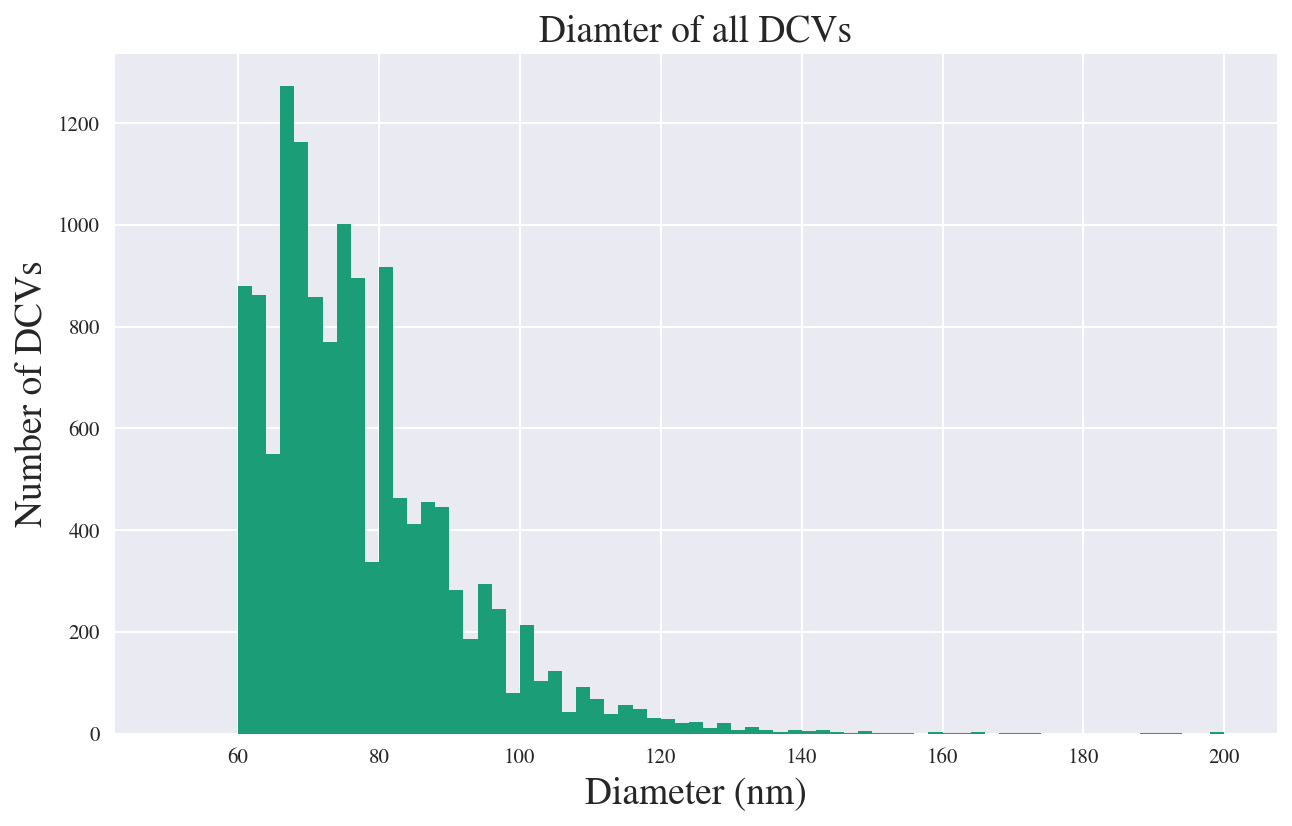

In [20]:
# Set directory
%cd /Users/hannah/git/LeeLabScripts/figures

# Histogram of all DCV diameters
# Plot histogram of DCV size (all DCVs scored)
df['diameter'].hist(bins = 75, range=(50,200))
plt.legend(loc='upper right')
plt.title('Diamter of all DCVs')
plt.xlabel('Diameter (nm)')
plt.ylabel('Number of DCVs')
# plt.axvline(diameter_mean, c='grey')
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV_diameter_for_all_DCVs.pdf')

In [21]:
df.shape

(13371, 18)

In [22]:
df.head()

,skeleton_id,connector_id,x,y,z,treenode_id,type,tags,DCV,diameter,fill,small,tethered,DCV_partner_skel_id,mito,t_bar,cell_type,neuron_name
0,75022,13748947,409556,236636,14960,653871,abutting,"[39, DCV, med]",True,78,med,False,None,None,None,None,ORN,DM6 ORN 1
1,75022,13748945,406126,237142,10760,654104,abutting,"[38, DCV, mhalo]",True,76,mhalo,False,None,None,None,None,ORN,DM6 ORN 1
2,75022,13748943,410982,239006,16520,653794,abutting,"[45, DCV, small]",True,90,halo,True,None,None,None,None,ORN,DM6 ORN 1
3,75022,13748941,411066,238938,16440,653797,abutting,"[35, DCV]",True,70,halo,False,None,None,None,None,ORN,DM6 ORN 1
4,75022,13748939,405674,242092,14920,654877,abutting,"[36, DCV]",True,72,halo,False,None,None,None,None,ORN,DM6 ORN 1


/Users/hannah/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6216: RuntimeWarning:

invalid value encountered in multiply



/Users/hannah/git/LeeLabScripts/figures


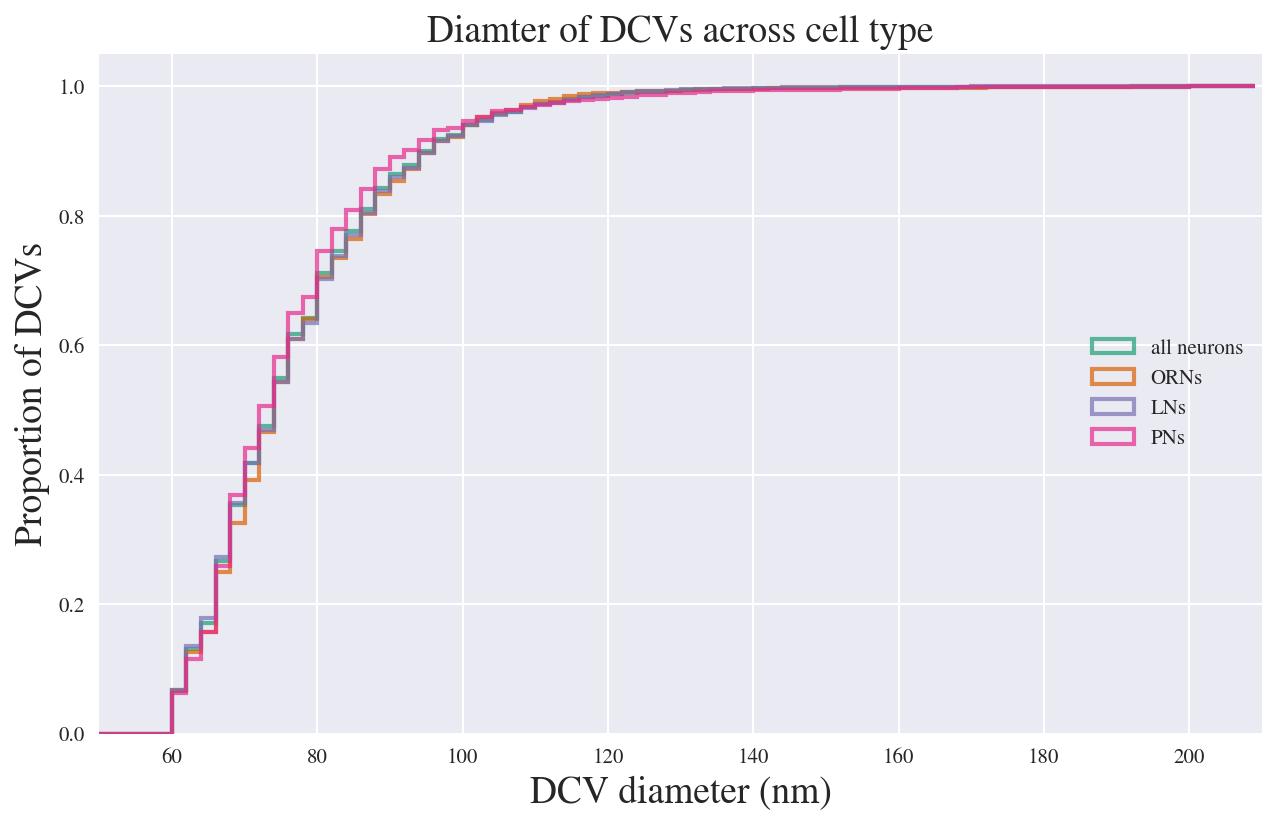

In [23]:
bins = list(range(50,210))

ax = df['diameter'].hist(bins = bins + [np.inf], histtype='step', cumulative=True, normed =True, linewidth=2, color = dark2_colors[0], label='all neurons', alpha =.7)
ax = ORN_df['diameter'].hist(bins = bins + [np.inf], histtype='step', cumulative=True, normed =True, linewidth=2, color = dark2_colors[1], label='ORNs', alpha =.7)
ax = LN_df['diameter'].hist(bins = bins + [np.inf], histtype='step', cumulative=True, normed =True, linewidth=2, color = dark2_colors[2], label='LNs', alpha =.7)
ax = PN_df['diameter'].hist(bins = bins + [np.inf], histtype='step', cumulative=True, normed =True, linewidth=2, color = dark2_colors[3], label='PNs', alpha =.7)

plt.title('Diamter of DCVs across cell type')
plt.ylabel('Proportion of DCVs')
plt.xlabel('DCV diameter (nm)')
ax.legend(loc='right')
ax.set_xlim([50, 210])
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV diameter across cells.pdf')

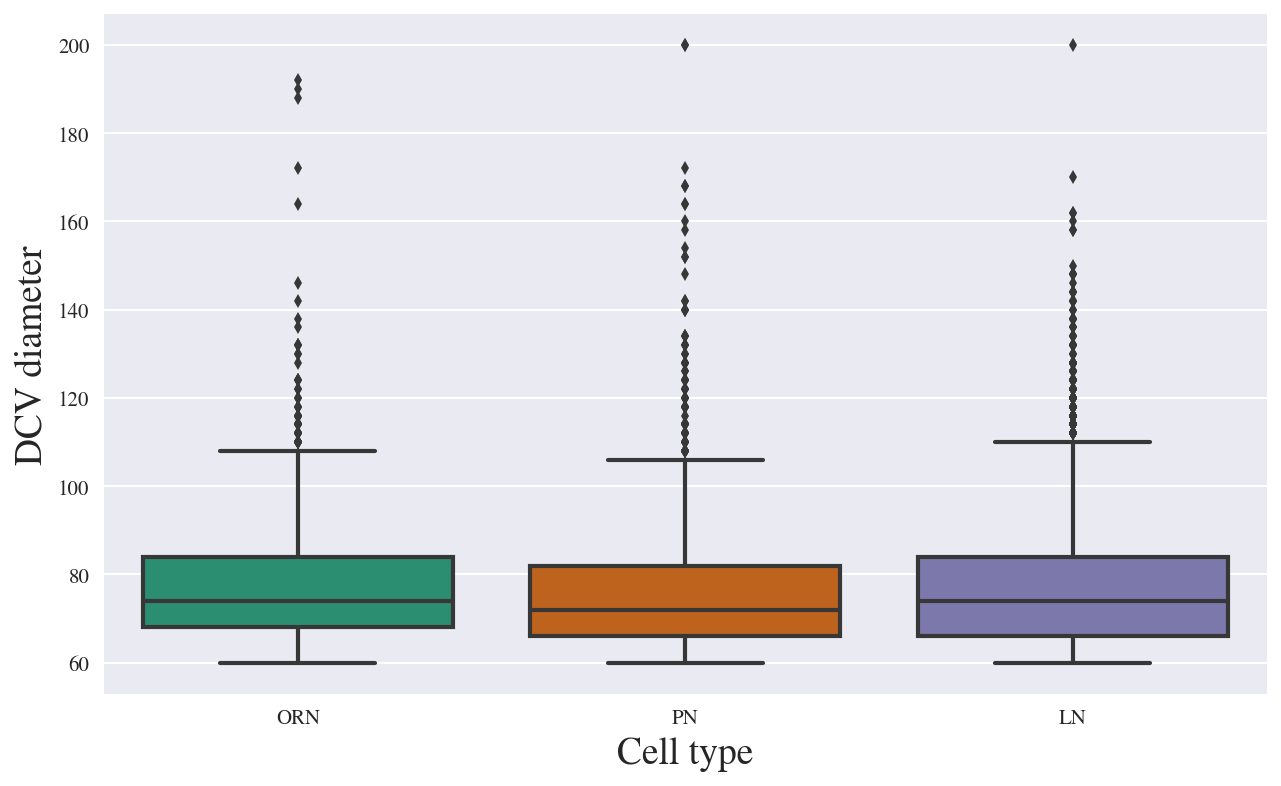

In [24]:
#Convert diameter to correct type
df['diameter'] = df['diameter'].astype('int')

#Swarm plot takes foooorrrver to load, so use a box plot instead.
# sns.swarmplot(x = "cell_type", y = "diameter", data = df)
sns.boxplot(x="cell_type", y="diameter", data=df)
plt.xlabel('Cell type')
plt.ylabel('DCV diameter')

In [25]:
# Lets compute the averages and test whether there are differences in DCV diameter across cell type
total_average_diameter = df['diameter'].mean()
ORN_average_diameter = ORN_df['diameter'].mean()
PN_average_diameter = PN_df['diameter'].mean()
LN_average_diameter = LN_df['diameter'].mean()
print('Average DCV diameter across all cell types: %s' % total_average_diameter)
print('Average DCV diameter across ORNs: %s' % ORN_average_diameter)
print('Average DCV diameter across PNs: %s' % PN_average_diameter)
print('Average DCV diameter across LNs: %s' % LN_average_diameter)

# (Three groups) Perform one-way ANOVA
anova_results = stats.f_oneway(ORN_df['diameter'], PN_df['diameter'], LN_df['diameter'])
print(anova_results)

# If p ≤ 0.05 then do post hoc-test
if anova_results[1] <= 0.05:
    # Tukey's post hoc-test
    tukey = pairwise_tukeyhsd(endog=df['diameter'],     # Data
                          groups=df['cell_type'],   # Groups
                          alpha=0.05)          # Significance level

    # Plot group confidence intervals
    tukey.plot_simultaneous()    
    plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

    # See test summary
    print(tukey.summary())              

Average DCV diameter across all cell types: 76.71617680053848
Average DCV diameter across ORNs: 77.0538351596
Average DCV diameter across PNs: 76.1298057048
Average DCV diameter across LNs: 76.7963402237
F_onewayResult(statistic=2.8296025882968689, pvalue=0.059071670637886806)


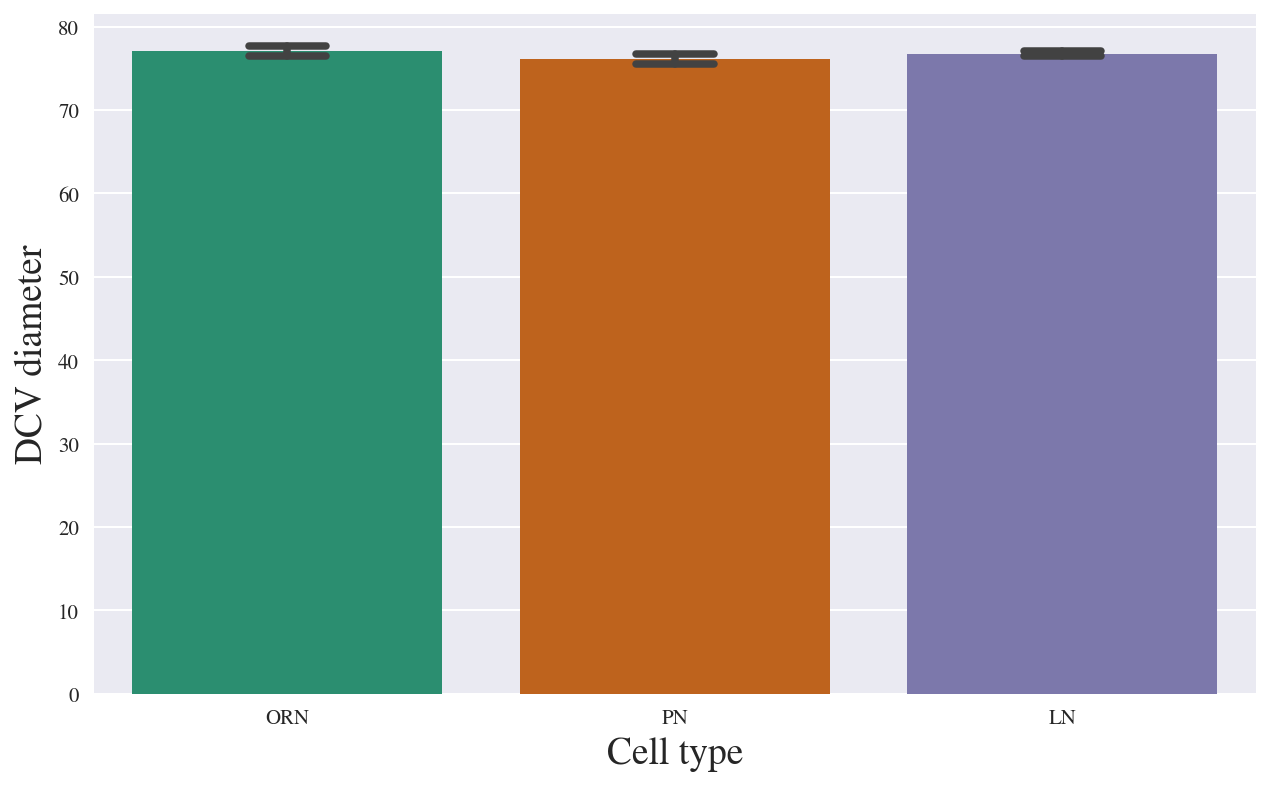

In [26]:
ax = sns.barplot(x = 'cell_type', y = 'diameter', data = df, capsize = .2)
plt.xlabel('Cell type')
plt.ylabel('DCV diameter')

# df.to_csv('DCV_duplicates removed.csv', encoding = 'utf-8')

We see that the average DCV diameter is 76.5 nm, which is consistent with other studies. In addition, all DCVs fall within the 60-200 nm range, which was part of my criteria for defining DCVs. We see no signigicant difference in diameter length across cell types. This is to be expected.

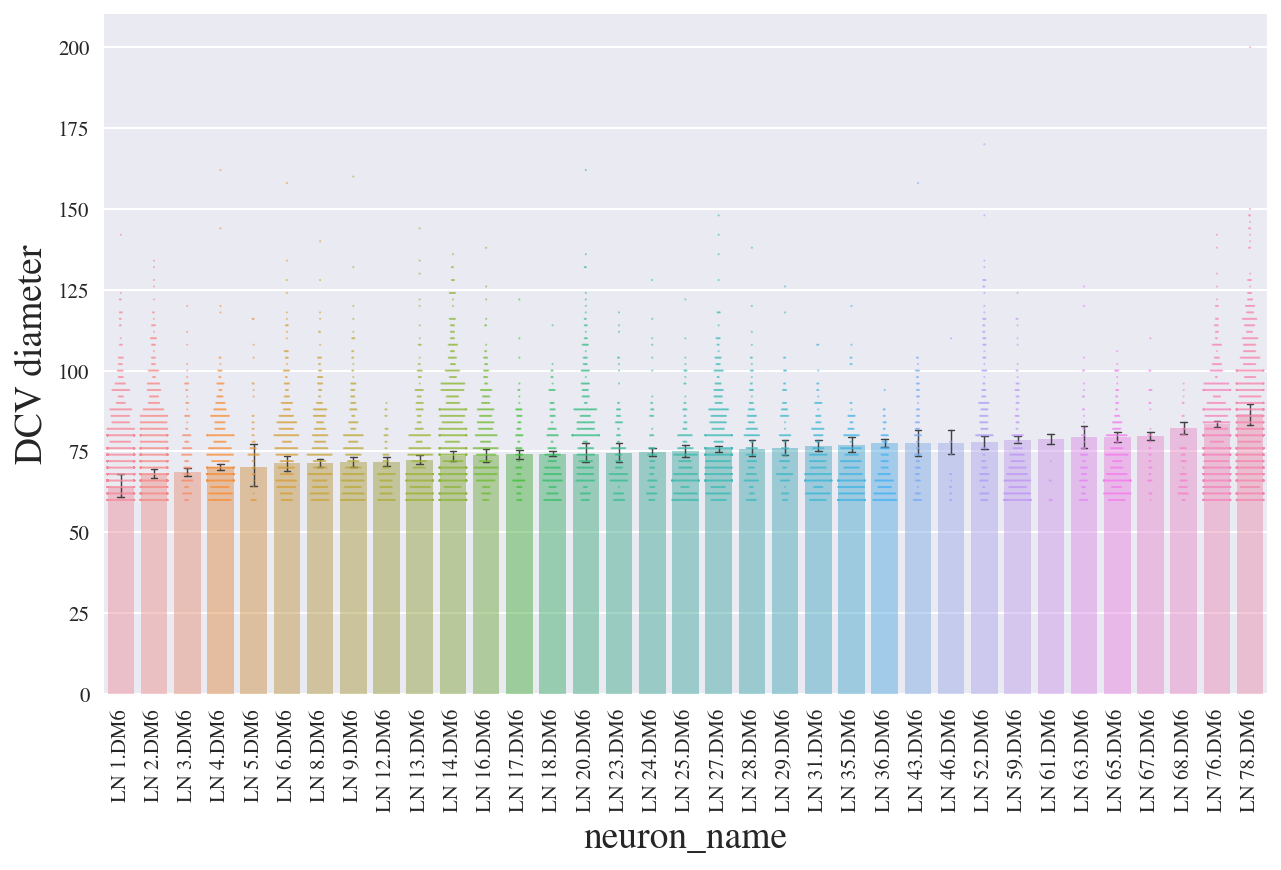

In [27]:
# Look at distrubution of DCV diameters across LNs
df_LNs_only = df[df['cell_type'] == 'LN']

# Sort LN skel_id by DCV mean diameter
LNs_means = df_LNs_only['diameter'].groupby(df_LNs_only['neuron_name']).mean()
LNs_means = LNs_means.sort_values()
sorted_LNs_means = list(LNs_means.keys())

ax = sns.barplot(x = 'neuron_name', y = 'diameter', data = df_LNs_only, capsize = .2, errwidth = .7, order = sorted_LNs_means, alpha =.5)
sns.swarmplot(x='neuron_name', y='diameter', data = df_LNs_only, alpha = .6, size = 1)
plt.xticks(rotation='vertical')
# plt.xlabel('LN neuron name')
plt.ylabel('DCV diameter')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1183ff9b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11857cf60>]], dtype=object)

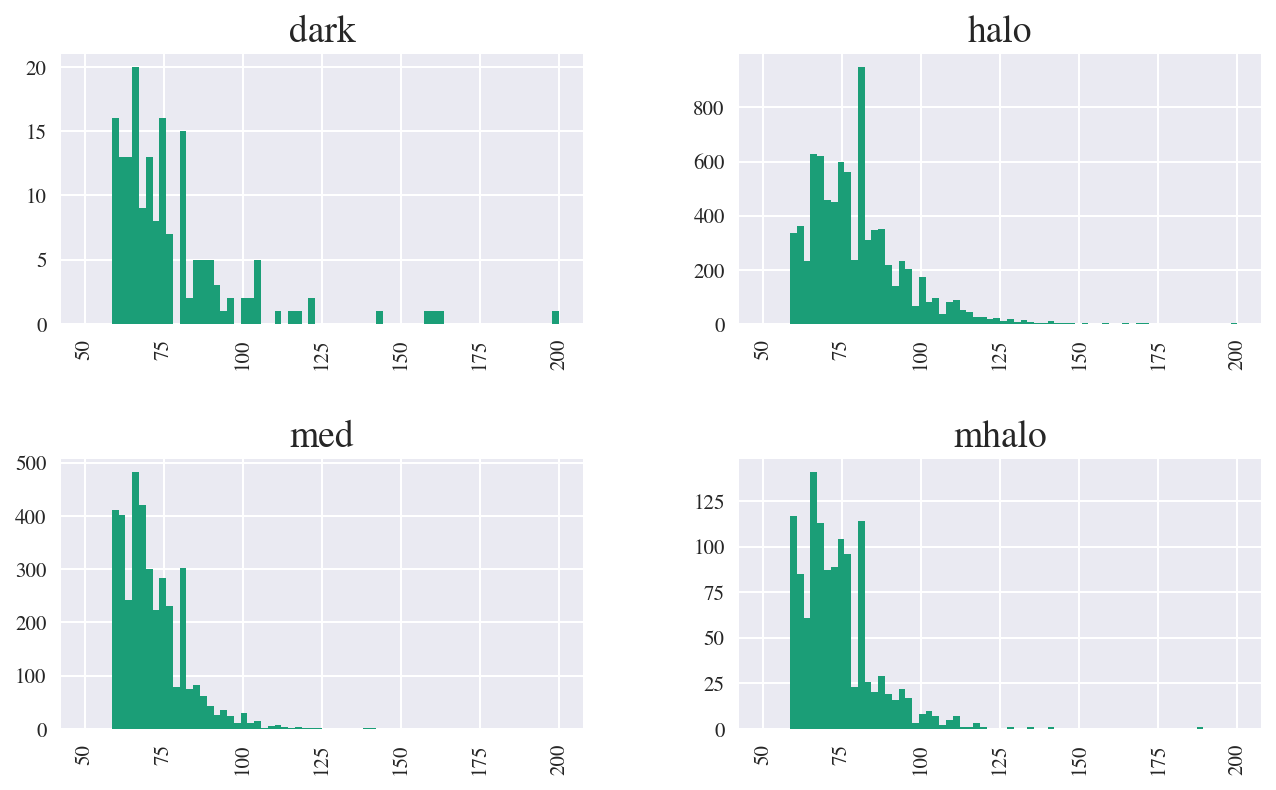

In [28]:
# Are there any differences in DCV diameter across fill types?

# Plot histogram of DCV size (all DCVs scored)
df['diameter'].hist(bins = 70, by = df['fill'], stacked = True, range=(50,200))

In [29]:
# get df for each fill type
dark_df = df[df['fill'] == 'dark']
med_df = df[df['fill'] == 'med']
mhalo_df = df[df['fill'] == 'mhalo']
halo_df = df[df['fill'] == 'halo']

/Users/hannah/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6216: RuntimeWarning:

invalid value encountered in multiply



/Users/hannah/git/LeeLabScripts/figures


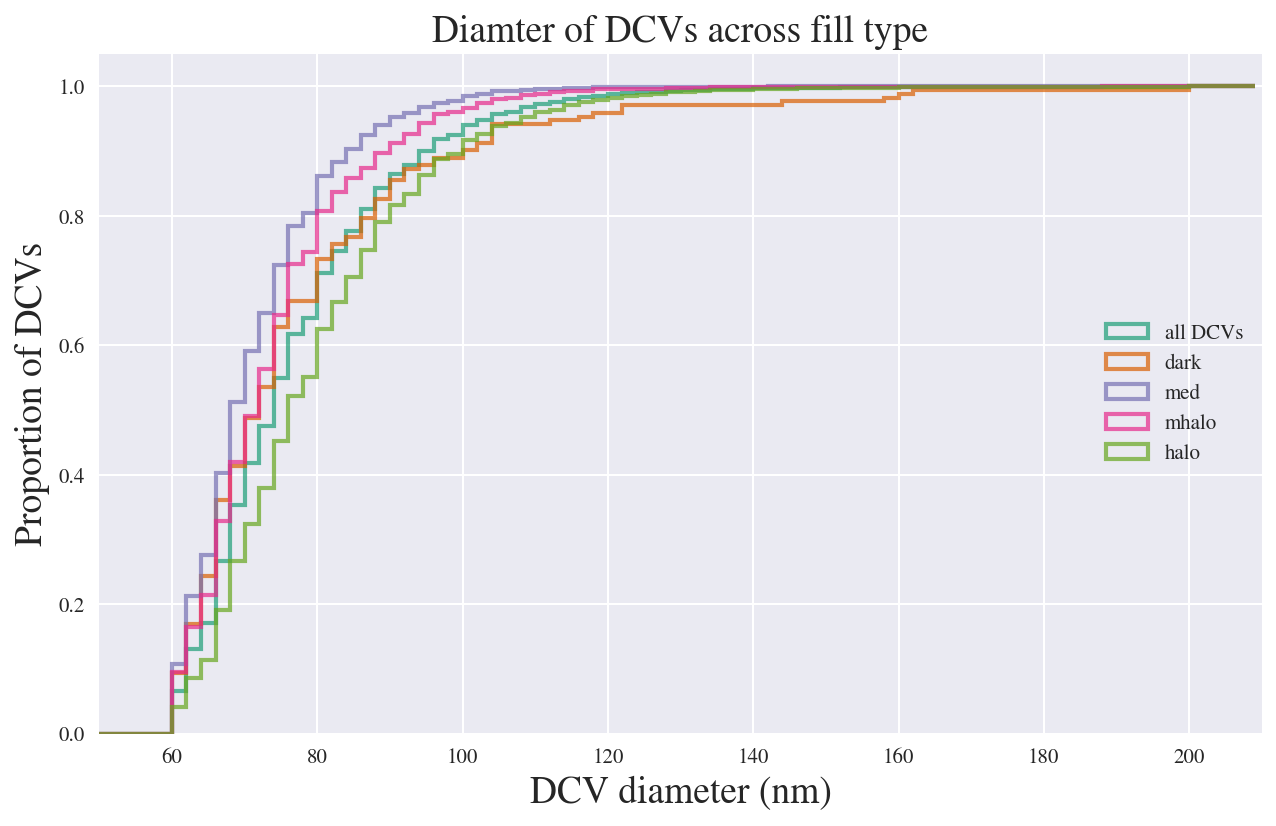

In [30]:
bins = list(range(50,210))

ax = df['diameter'].hist(bins = bins + [np.inf], histtype='step', cumulative=True, normed =True, linewidth=2, color = dark2_colors[0], label='all DCVs', alpha =.7)
ax = dark_df['diameter'].hist(bins = bins + [np.inf], histtype='step', cumulative=True, normed =True, linewidth=2, color = dark2_colors[1], label='dark', alpha =.7)
ax = med_df['diameter'].hist(bins = bins + [np.inf], histtype='step', cumulative=True, normed =True, linewidth=2, color = dark2_colors[2], label='med', alpha =.7)
ax = mhalo_df['diameter'].hist(bins = bins + [np.inf], histtype='step', cumulative=True, normed =True, linewidth=2, color = dark2_colors[3], label='mhalo', alpha =.7)
ax = halo_df['diameter'].hist(bins = bins + [np.inf], histtype='step', cumulative=True, normed =True, linewidth=2, color = dark2_colors[4], label='halo', alpha =.7)

plt.title('Diamter of DCVs across fill type')
plt.ylabel('Proportion of DCVs')
plt.xlabel('DCV diameter (nm)')
ax.legend(loc='right')
ax.set_xlim([50, 210])
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV diameter across cells.pdf')

Average DCV diameter across all cell types: 76.71617680053848
Average DCV diameter across ORNs: 77.48837209302326
Average DCV diameter across PNs: 71.3104891446508
Average DCV diameter across LNs: 73.65069049553209
Average DCV diameter across LNs: 79.70042971147943
F_onewayResult(statistic=353.48689284675868, pvalue=6.3203664974261285e-221)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 dark   halo   2.2121  -0.4788  4.9029 False 
 dark   med   -6.1779    -8.9  -3.4558  True 
 dark  mhalo  -3.8377  -6.6805 -0.9948  True 
 halo   med   -8.3899  -9.0746 -7.7053  True 
 halo  mhalo  -6.0497  -7.1177 -4.9818  True 
 med   mhalo   2.3402   1.1957  3.4847  True 
---------------------------------------------


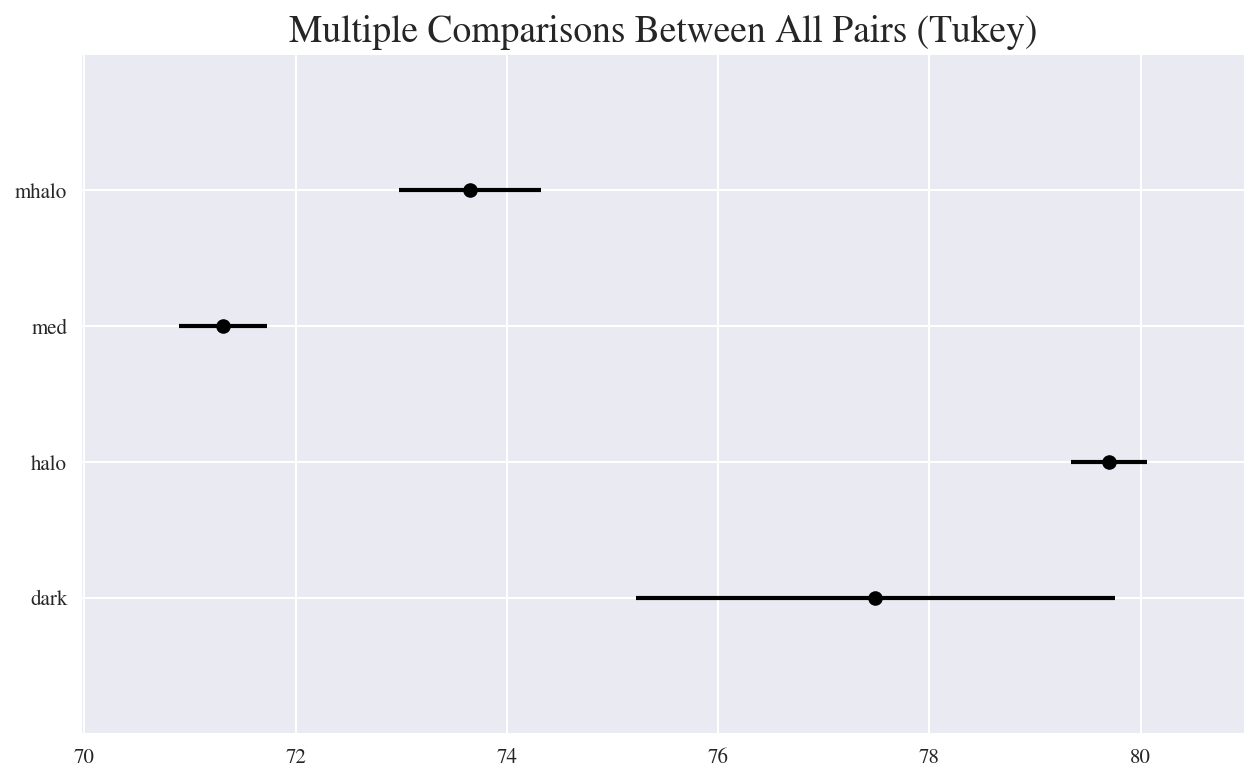

In [31]:
total_average_diameter = df['diameter'].mean()
dark_average_diameter = dark_df['diameter'].mean()
med_average_diameter = med_df['diameter'].mean()
mhalo_average_diameter = mhalo_df['diameter'].mean()
halo_average_diameter = halo_df['diameter'].mean()
print('Average DCV diameter across all cell types: %s' % total_average_diameter)
print('Average DCV diameter across ORNs: %s' % dark_average_diameter)
print('Average DCV diameter across PNs: %s' % med_average_diameter)
print('Average DCV diameter across LNs: %s' % mhalo_average_diameter)
print('Average DCV diameter across LNs: %s' % halo_average_diameter)

# (Three groups) Perform one-way ANOVA
anova_results = stats.f_oneway(dark_df['diameter'], med_df['diameter'], mhalo_df['diameter'], halo_df['diameter'])
print(anova_results)

# If p ≤ 0.05 then do post hoc-test
if anova_results[1] <= 0.05:
    # Tukey's post hoc-test
    tukey = pairwise_tukeyhsd(endog=df['diameter'],     # Data
                          groups=df['fill'],   # Groups
                          alpha=0.05)          # Significance level

    # Plot group confidence intervals
    tukey.plot_simultaneous()    
    plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

    # See test summary
    print(tukey.summary())  

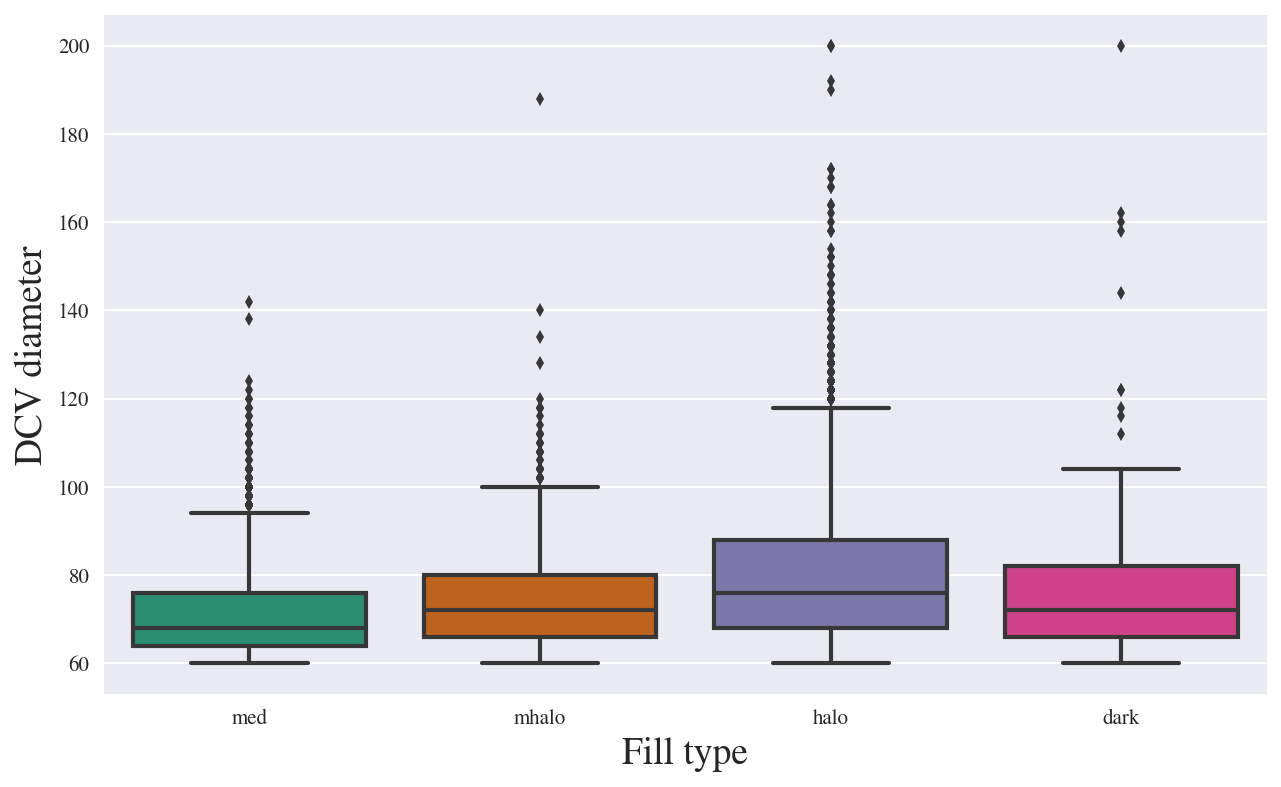

In [32]:
#Convert diameter to correct type
df['diameter'] = df['diameter'].astype('int')

#Swarm plot takes foooorrrver to load, so use a box plot instead.
# sns.swarmplot(x = "cell_type", y = "diameter", data = df)
sns.boxplot(x="fill", y="diameter", data=df)
plt.xlabel('Fill type')
plt.ylabel('DCV diameter')

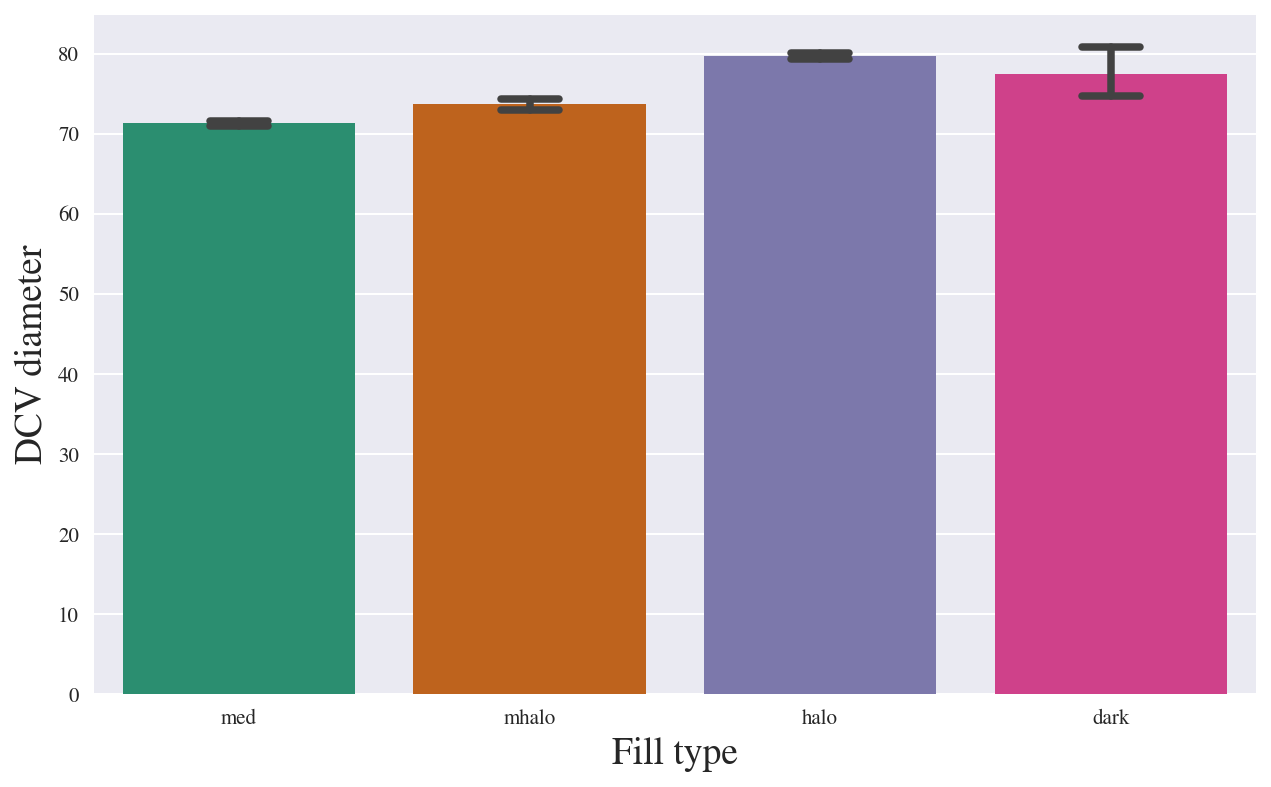

In [33]:
ax = sns.barplot(x = 'fill', y = 'diameter', data = df, capsize = .2)
plt.xlabel('Fill type')
plt.ylabel('DCV diameter')

In [34]:
df_halo = df[df['fill'] == 'halo']
print('halo:',df_halo.diameter.mean())

df_mhalo = df[df['fill'] == 'mhalo']
print('mhalo:',df_mhalo.diameter.mean())

df_dark = df[df['fill'] == 'dark']
print('dark:',df_dark.diameter.mean())

df_med = df[df['fill'] == 'med']
print('med:',df_med.diameter.mean())

halo: 79.70042971147943
mhalo: 73.65069049553209
dark: 77.48837209302326
med: 71.3104891446508


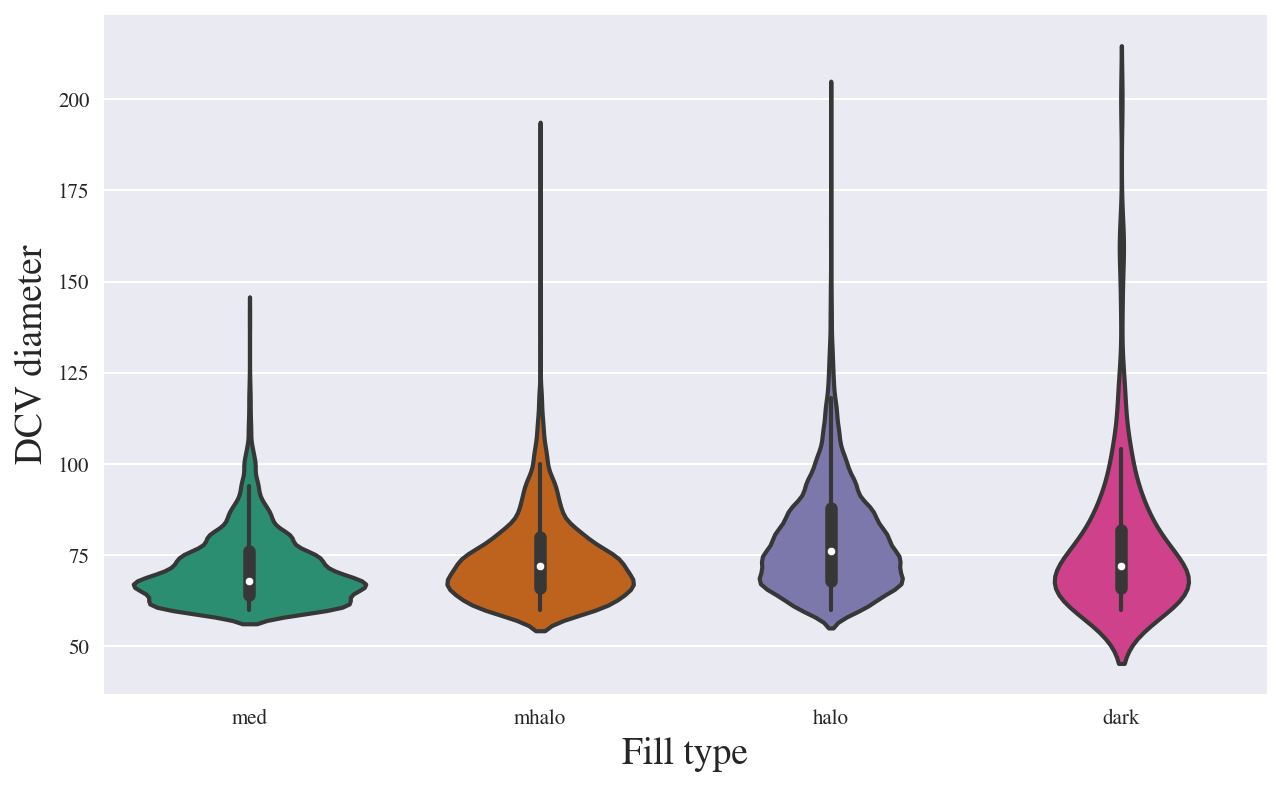

In [35]:
ax = sns.violinplot(x = 'fill', y = 'diameter', data = df, capsize = .2)
plt.xlabel('Fill type')
plt.ylabel('DCV diameter')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 <a list of 60 Text xticklabel objects>)

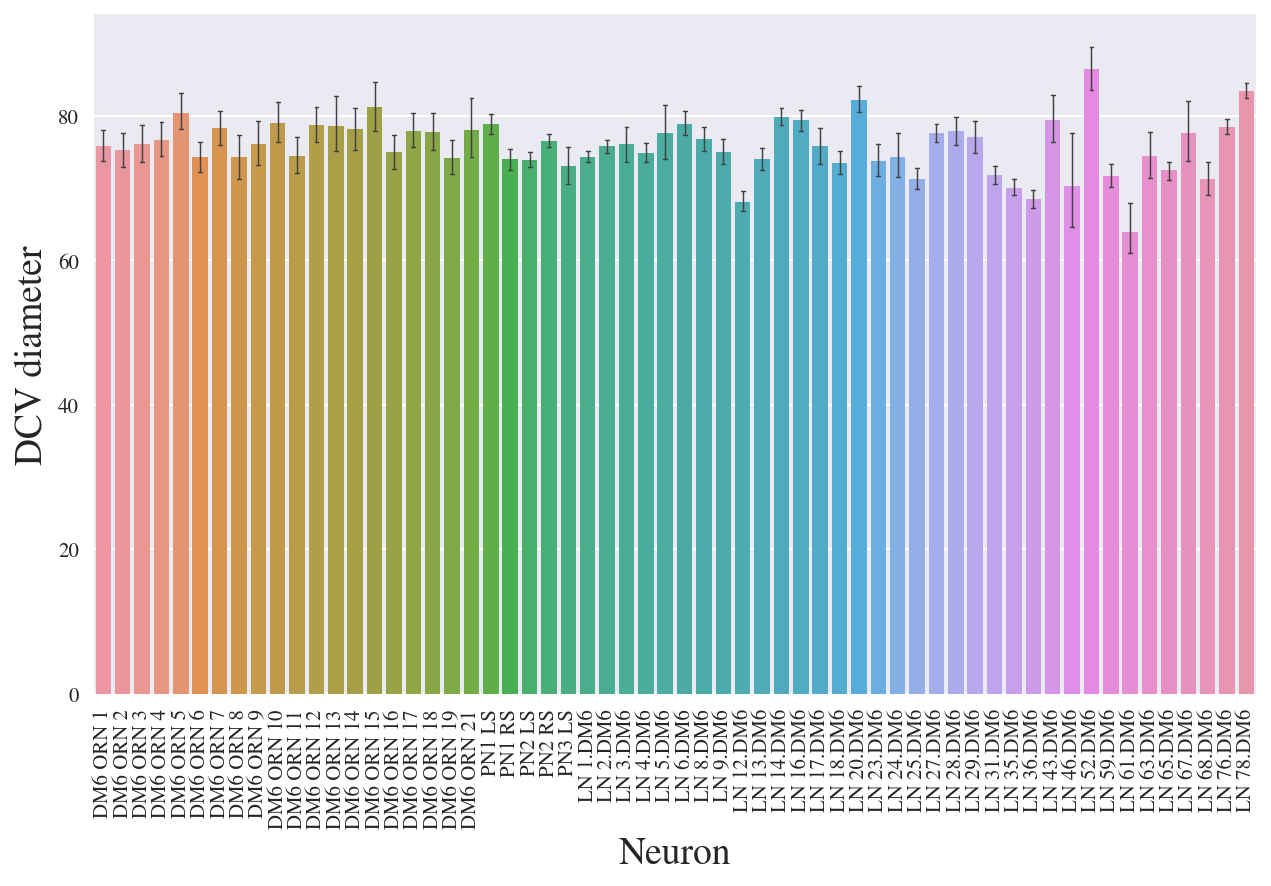

In [36]:
g = sns.barplot(x = 'neuron_name', y = 'diameter', data = df, capsize = .2, errwidth = .7)
plt.xlabel('Neuron')
plt.ylabel('DCV diameter')
plt.xticks(rotation=90)

In [37]:
# Get DCV diameter data across LNs
diameter_data = df.copy()

# Get only LNs
diameter_data = diameter_data[diameter_data['cell_type'] == 'LN']

# get DCV diameter mean
diameter_mean_data = diameter_data.groupby('neuron_name', as_index=False).mean()
diameter_mean_data.rename(columns={'diameter':'diameter_mean'}, inplace=True)
diameter_mean_data.pop('DCV')

# get DCV diameter std
diameter_std_data = diameter_data.groupby('neuron_name').std()
diameter_std_data.reset_index(drop = False, inplace = True)
diameter_std_data.rename(columns={'diameter':'diameter_std'}, inplace=True)
diameter_std_data.pop('DCV')

# Put diameter mean and std together
LN_diameter_data_df = pd.merge(left = diameter_mean_data,
                               right = diameter_std_data,
                               how = 'inner',
                               on = 'neuron_name')

# save df
%cd /Users/hannah/git/LeeLabScripts/CSVs
# LN_diameter_data_df.to_csv('LN_diameter_data_df.csv', encoding = 'utf-8')

/Users/hannah/git/LeeLabScripts/CSVs


## DCV fill across cell types

In [38]:
df_fill_value_counts = df.fill.value_counts()
ORN_fill_value_counts = ORN_df.fill.value_counts()
PN_fill_value_counts = PN_df.fill.value_counts()
LN_fill_value_counts = LN_df.fill.value_counts()

# Have number of dif DCV fill type across cell types.
fill_dist = [['ORN', ORN_fill_value_counts['dark'], ORN_fill_value_counts['med'], ORN_fill_value_counts['mhalo'], ORN_fill_value_counts['halo']], 
             ['PN', PN_fill_value_counts['dark'], PN_fill_value_counts['med'], PN_fill_value_counts['mhalo'], PN_fill_value_counts['halo']], 
             ['LN', LN_fill_value_counts['dark'], LN_fill_value_counts['med'], LN_fill_value_counts['mhalo'], LN_fill_value_counts['halo']]]
fill_dist_df = pd.DataFrame(fill_dist, columns = ['cell_type', 'dark', 'med', 'mhalo', 'halo'])
fill_dist_df["sum"] = fill_dist_df.sum(axis=1)

# Need to compute proportions
fill_prop_df = fill_dist_df.loc[:,"dark":"halo"].div(fill_dist_df["sum"], axis=0)
fill_prop_df

,dark,med,mhalo,halo
0,0.016198,0.120534,0.085279,0.777990
1,0.016949,0.227367,0.116164,0.639520
2,0.010957,0.341127,0.087089,0.560827


/Users/hannah/git/LeeLabScripts/figures


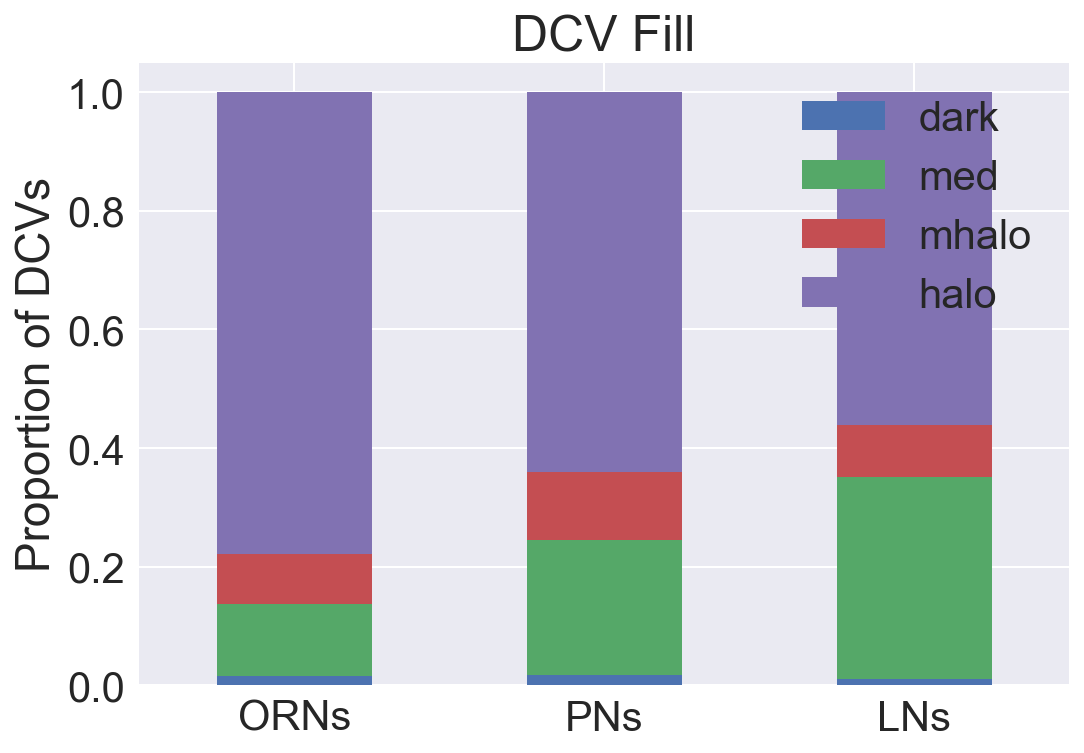

In [39]:
labels = ['ORNs', 'PNs', 'LNs']
x = [0, 1, 2]
sns.set(font_scale=2)
ax = fill_prop_df.plot.bar(stacked = True)
plt.xticks(x, labels, rotation='horizontal')
plt.ylabel('Proportion of DCVs')
plt.title('DCV Fill')
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV fill quant.pdf')

In [40]:
def Prop_DCV_fill_type_across_neurons(neuron_name, df):
    """Wrapper to compute the proportion of fill types for DCVs across neurons
       
       
    Parameters:
    -----------
    neuron_name :            list of neuron names
    
    df :                     df with all the abutting connector data
    
    
    Returns:
    --------
    
    Pandas df with 'dark', 'med', 'halo', 'mhalo', 'neuron_name', 'cell_type'
    
    """
        
    # Initialize master df
    master_df = pd.DataFrame()
    
    for neuron in neuron_name:

        # Get relevant DCVs
        this_df = df.loc[df['neuron_name'] == neuron]
        this_df.reset_index(drop = True, inplace = True)
        
        # Get just dark
        this_dark_df = this_df[this_df['fill'] == 'dark']
        
        # Get just med
        this_med_df = this_df[this_df['fill'] == 'med']
        
        # Get just halo
        this_halo_df = this_df[this_df['fill'] == 'halo']
        
        # Get just mhalo
        this_mhalo_df = this_df[this_df['fill'] == 'mhalo']
        

        # Get the DCV number values for each category
        num_dark = this_dark_df.shape[0]
        num_med = this_med_df.shape[0]
        num_halo = this_halo_df.shape[0]
        num_mhalo = this_mhalo_df.shape[0]
        num_total = this_df.shape[0]

       
        ################################
        # Get this data into dataframe
        count_DCV_data = [num_dark,
                               num_med,
                               num_halo,
                               num_mhalo,
                               num_total]

        
        count_DCV_data_df = pd.DataFrame(count_DCV_data).T
        count_DCV_data_df = count_DCV_data_df.rename(columns = {0:'dark',
                                                              1:'med',
                                                              2:'halo',
                                                              3:'mhalo',
                                                              4:'total'})
        
        # Need to compute proportions
        prop_DCV_df = count_DCV_data_df.loc[:,"dark":"mhalo"].div(count_DCV_data_df["total"], axis=0)
        prop_DCV_df['neuron_name'] = neuron
        
        # Get cell type
        if 'ORN' in neuron:
            prop_DCV_df['cell_type'] = 'ORN'
        elif 'LN' in neuron: 
            prop_DCV_df['cell_type'] = 'LN'
        elif 'PN' in neuron: 
            prop_DCV_df['cell_type'] = 'PN'   
    
        # Add data to master df
        master_df = master_df.append(prop_DCV_df)
        master_df.reset_index(drop = True, inplace = True)
        
    
    return master_df

In [41]:
prop_DCV_fill = Prop_DCV_fill_type_across_neurons(all_neuron_names, df)
prop_DCV_fill = prop_DCV_fill.drop_duplicates('neuron_name')
prop_DCV_fill.head()
# prop_DCV_fill.to_csv('prop_DCV_fill_across_all_neurons.csv', encoding = 'utf-8')

,dark,med,halo,mhalo,neuron_name,cell_type
0,0.013699,0.191781,0.719178,0.075342,DM6 ORN 1,ORN
1,0.056000,0.152000,0.712000,0.080000,DM6 ORN 2,ORN
2,0.037975,0.170886,0.721519,0.069620,DM6 ORN 3,ORN
3,0.010101,0.090909,0.868687,0.030303,DM6 ORN 4,ORN
4,0.020134,0.208054,0.697987,0.073826,DM6 ORN 5,ORN


/Users/hannah/git/LeeLabScripts/figures
/Users/hannah/git/LeeLabScripts/CSVs


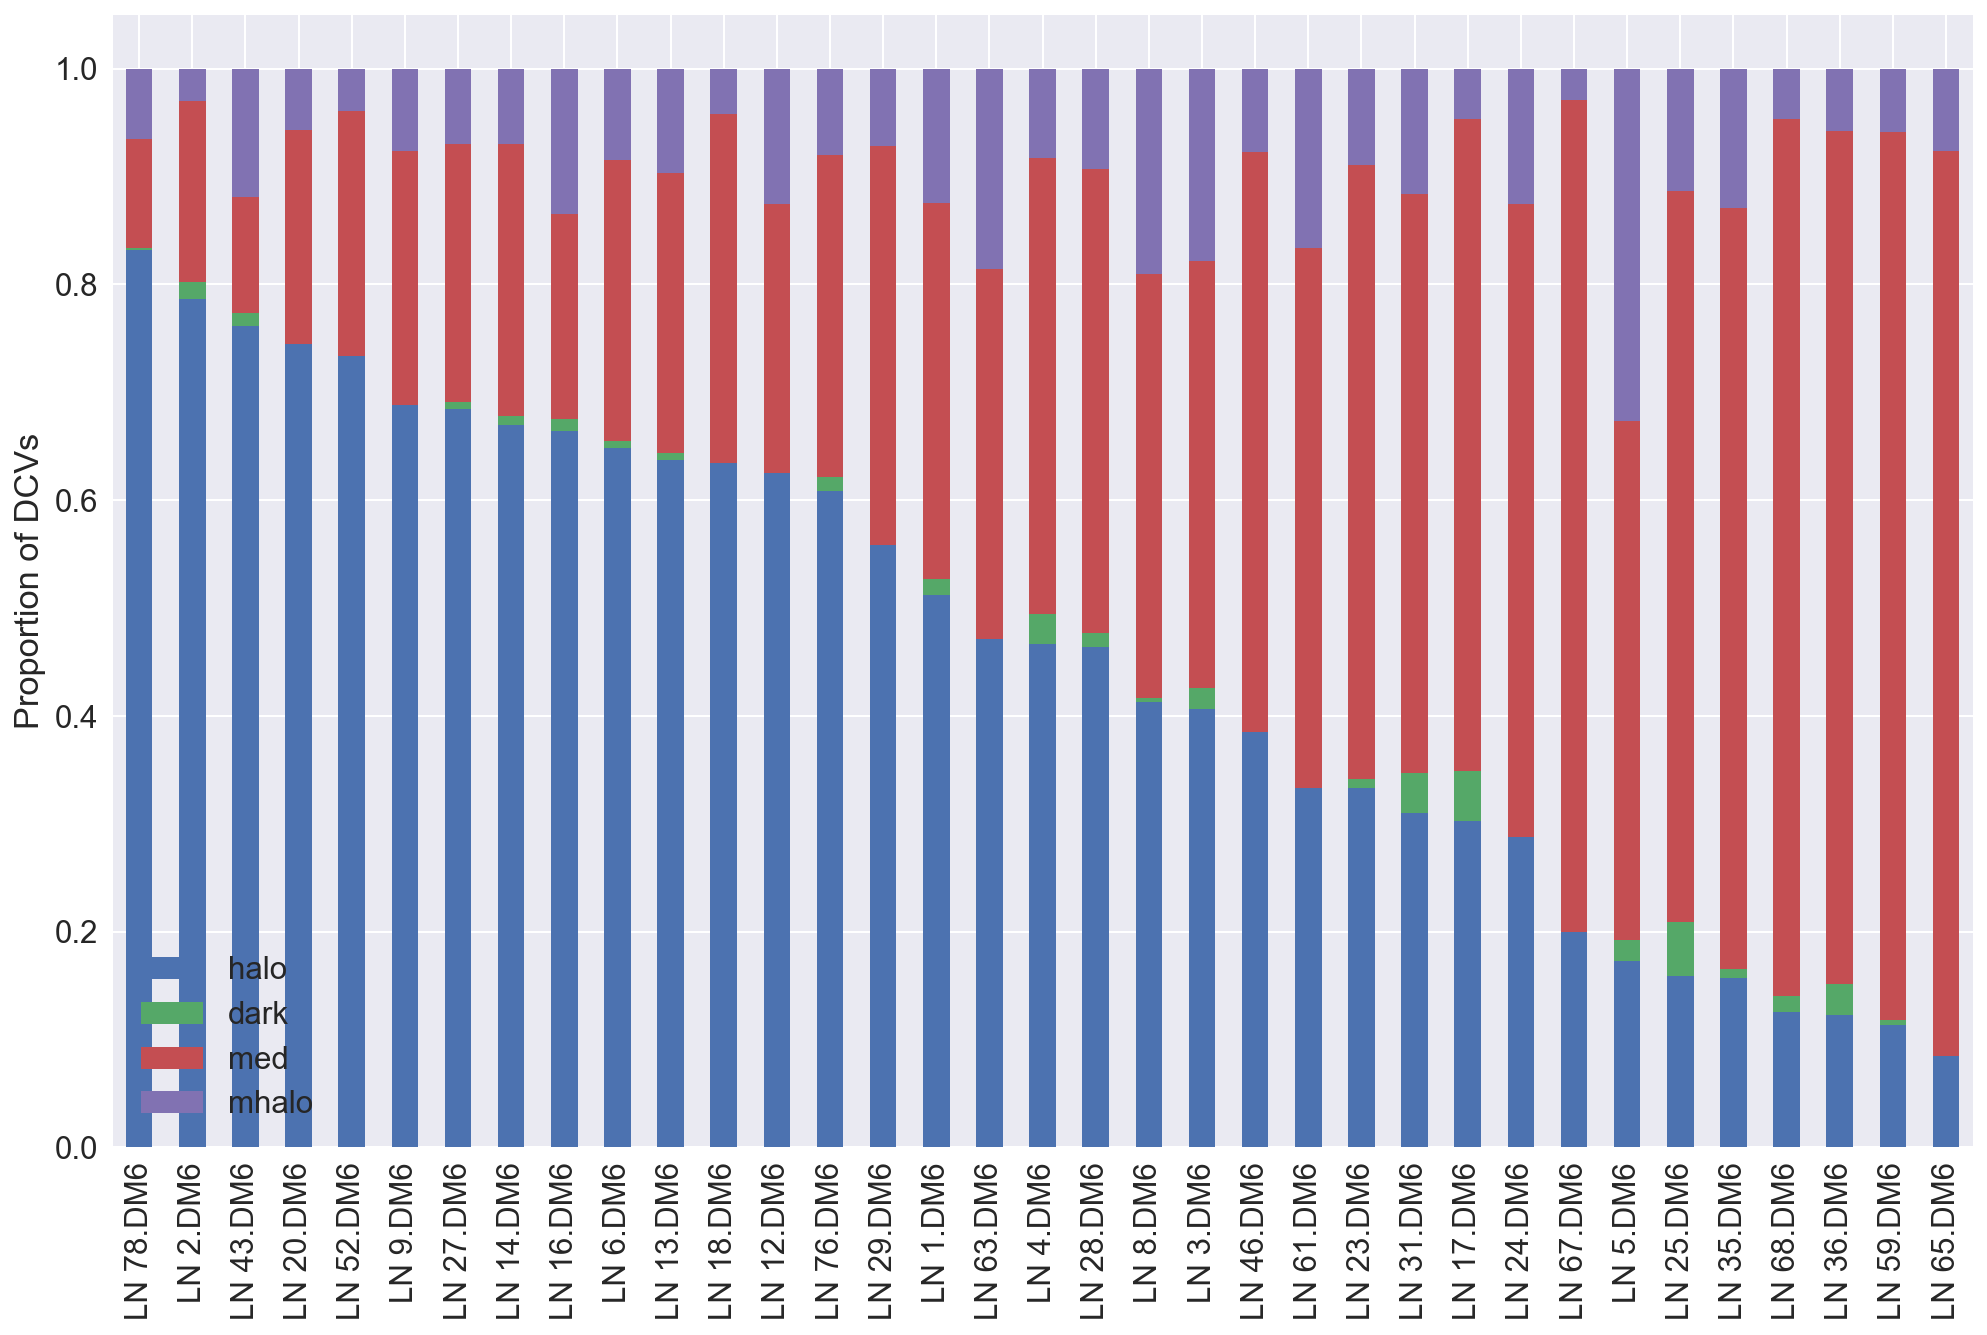

In [42]:
# Plot LNs only --- sorted by presynaptic site

LN_prop_DCV_fill = prop_DCV_fill[prop_DCV_fill['cell_type'] == 'LN']
test = LN_prop_DCV_fill.copy()


# Drop cells that don't have any DCVs
test = test.dropna()

# Sort this by Prop DCVs that have halo
test = test.sort_values(by='halo', ascending=0)

# Get Skel_id labels
labels = test['neuron_name'].tolist()
x = range(0 , len(test))

# Get relevant data for plot
test_core_data = test[['halo','dark','med', 'mhalo']]

sns.set(font_scale=1.5)
ax = test_core_data.plot.bar(stacked = True, figsize=(16, 10))
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Proportion of DCVs')
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV fill quant LN.pdf')
%cd /Users/hannah/git/LeeLabScripts/CSVs
LN_prop_DCV_fill.to_csv('LN_prop_DCV_fill.csv', encoding = 'utf-8')

In [43]:
# %cd /Users/hannah/git/LeeLabScripts/CSVs
# test.to_csv('sorted_LN_DCV_fill_df.csv', encoding = 'utf-8')

/Users/hannah/git/LeeLabScripts/figures


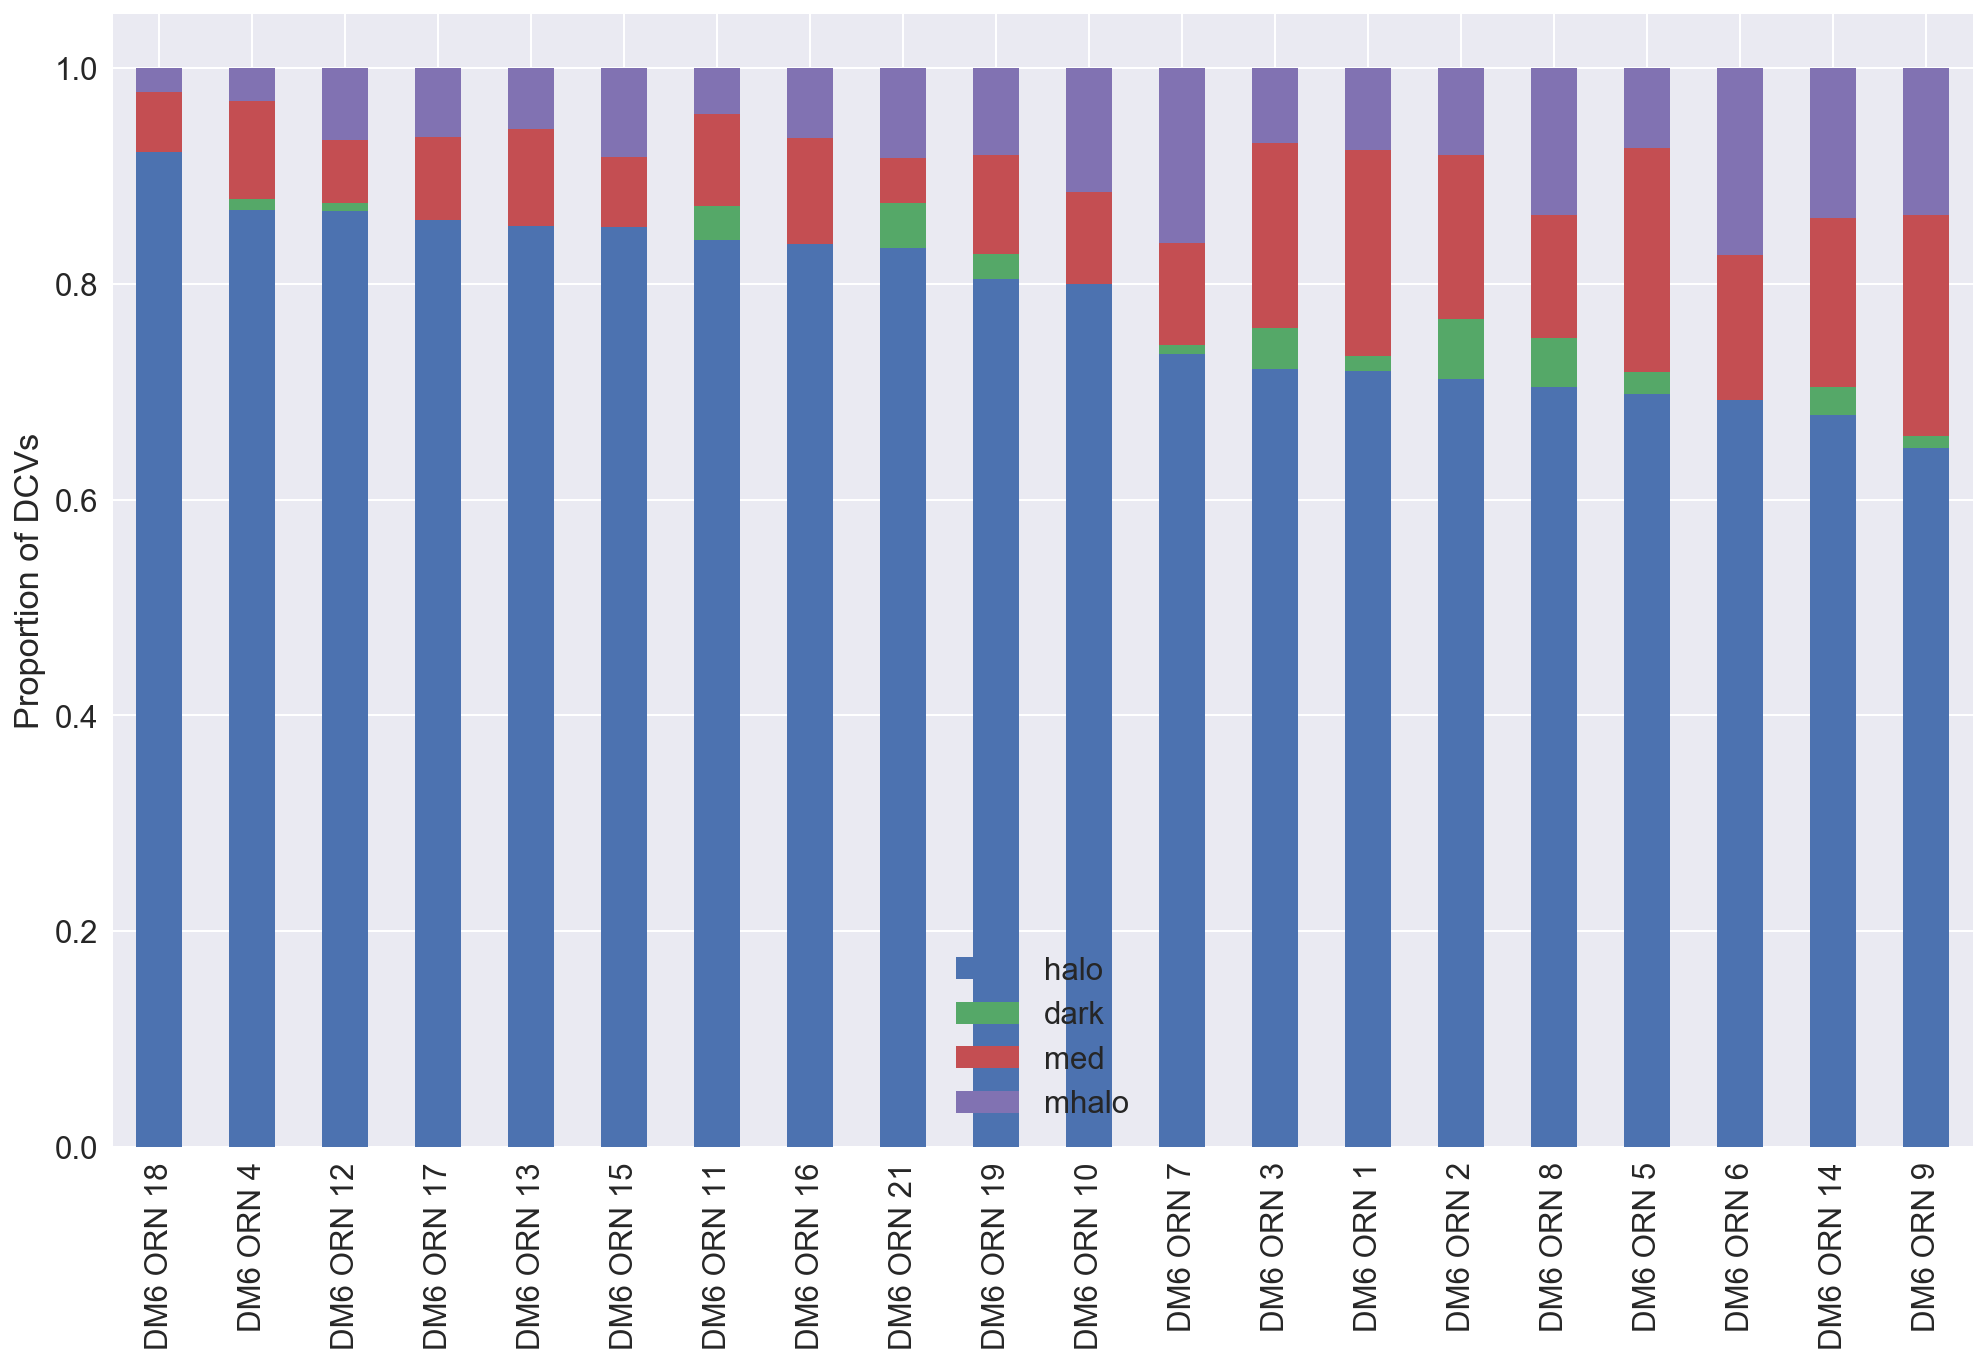

In [44]:
# Plot ORNs only --- sorted by presynaptic site

LN_prop_DCV_fill = prop_DCV_fill[prop_DCV_fill['cell_type'] == 'ORN']
test = LN_prop_DCV_fill.copy()


# Drop cells that don't have any DCVs
test = test.dropna()

# Sort this by Prop DCVs that have halo
test = test.sort_values(by='halo', ascending=0)

# Get Skel_id labels
labels = test['neuron_name'].tolist()
x = range(0 , len(test))

# Get relevant data for plot
test_core_data = test[['halo','dark','med', 'mhalo']]

sns.set(font_scale=1.5)
ax = test_core_data.plot.bar(stacked = True, figsize=(16, 10))
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Proportion of DCVs')
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV fill quant ORN.pdf')

In [45]:
# %cd /Users/hannah/git/LeeLabScripts/CSVs
# test.to_csv('sorted_ORN_DCV_fill_df.csv', encoding = 'utf-8')

/Users/hannah/git/LeeLabScripts/figures


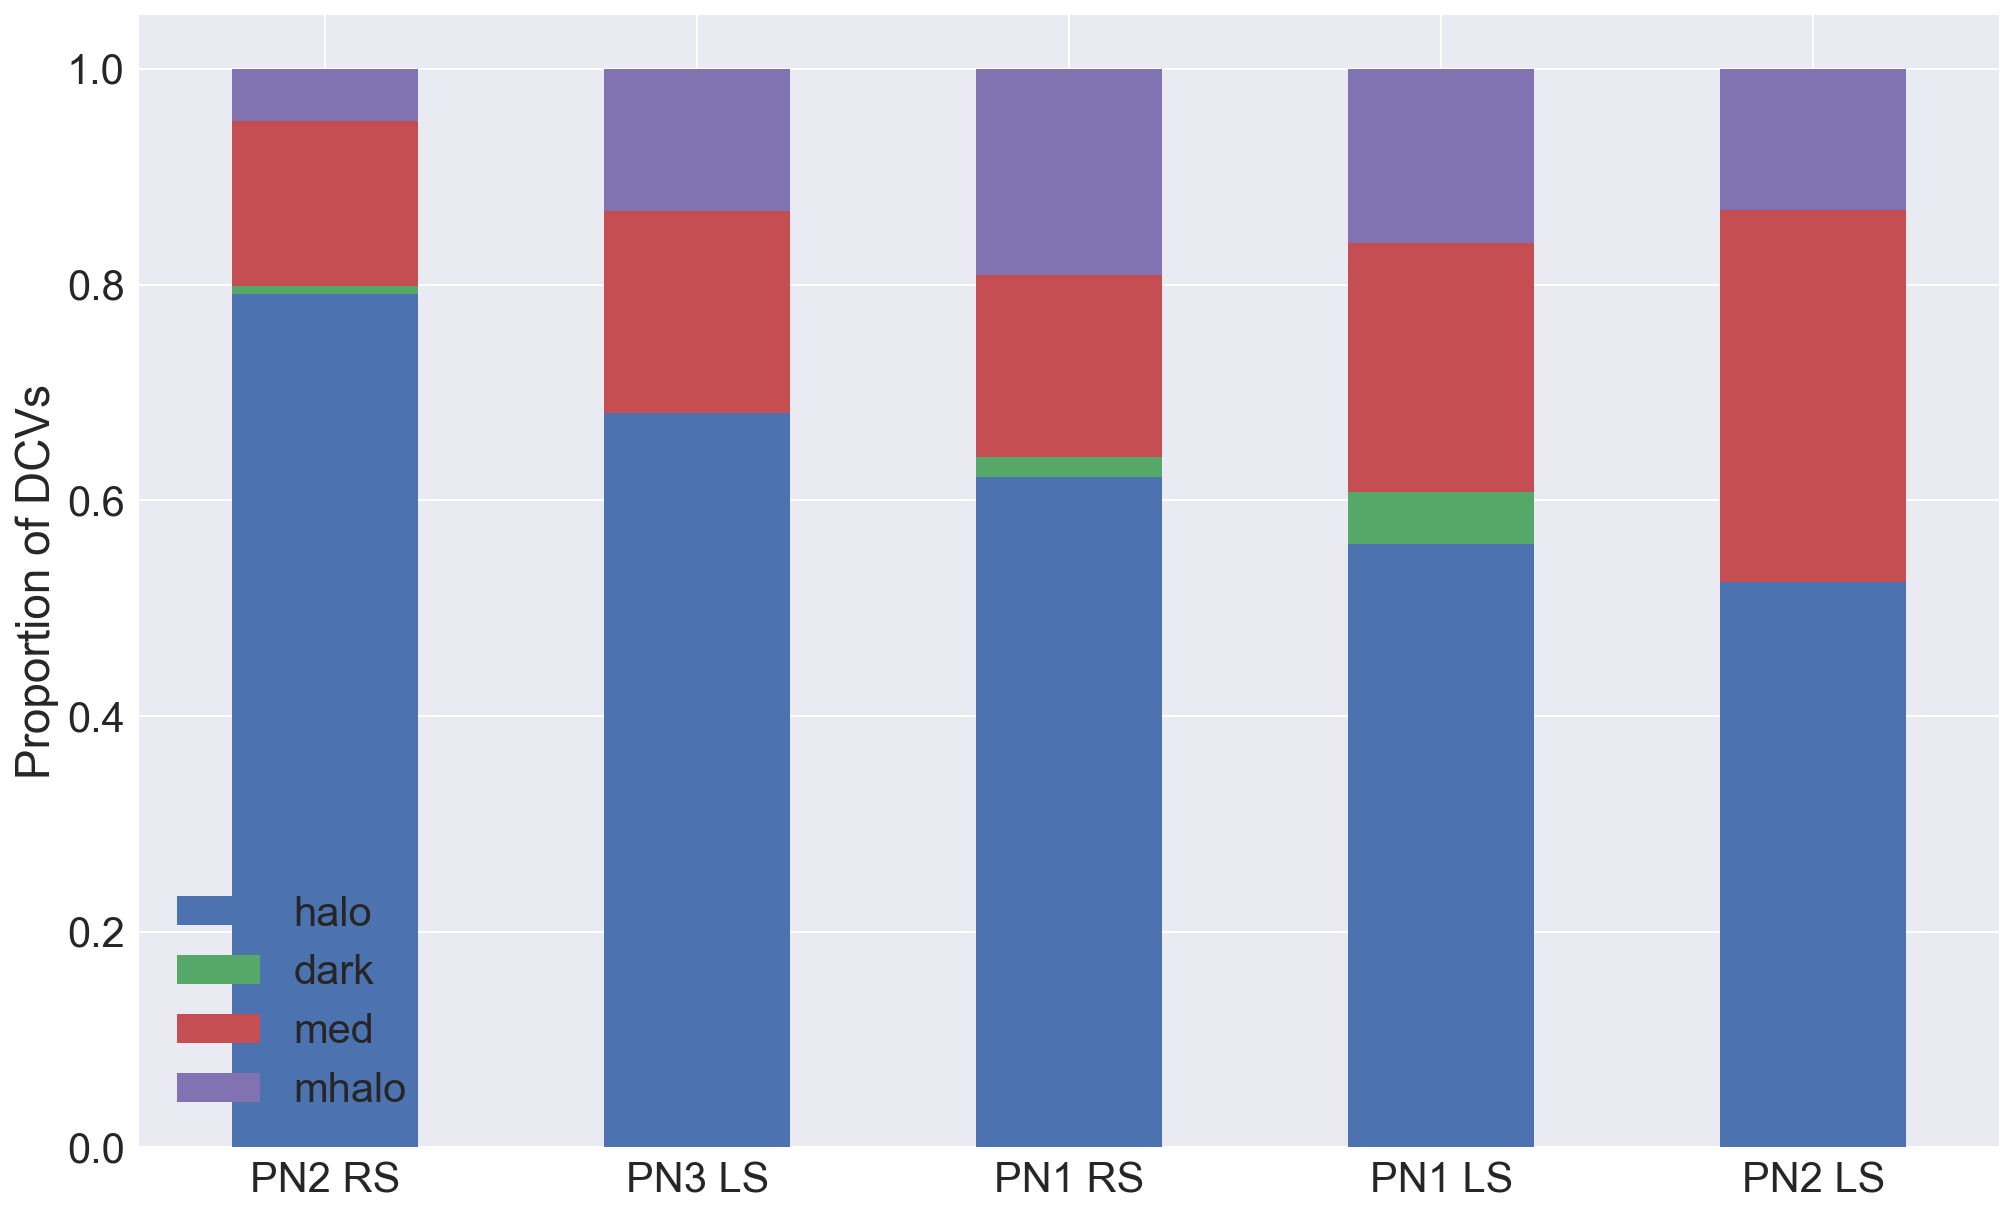

In [46]:
# Plot PNs only --- sorted by presynaptic site

LN_prop_DCV_fill = prop_DCV_fill[prop_DCV_fill['cell_type'] == 'PN']
test = LN_prop_DCV_fill.copy()


# Drop cells that don't have any DCVs
test = test.dropna()

# Sort this by Prop DCVs that have halo
test = test.sort_values(by='halo', ascending=0)

# Get Skel_id labels
labels = test['neuron_name'].tolist()
x = range(0 , len(test))

# Get relevant data for plot
test_core_data = test[['halo','dark','med', 'mhalo']]

sns.set(font_scale=2)
ax = test_core_data.plot.bar(stacked = True, figsize=(16, 10))
plt.xticks(x, labels, rotation='horizontal')
plt.ylabel('Proportion of DCVs')
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV fill quant PN.pdf')

In [47]:
# %cd /Users/hannah/git/LeeLabScripts/CSVs
# test.to_csv('sorted_PN_DCV_fill_df.csv', encoding = 'utf-8')

## DCV fill vs docked tail

In [48]:
df.head()

,skeleton_id,connector_id,x,y,z,treenode_id,type,tags,DCV,diameter,fill,small,tethered,DCV_partner_skel_id,mito,t_bar,cell_type,neuron_name
0,75022,13748947,409556,236636,14960,653871,abutting,"[39, DCV, med]",True,78,med,False,None,None,None,None,ORN,DM6 ORN 1
1,75022,13748945,406126,237142,10760,654104,abutting,"[38, DCV, mhalo]",True,76,mhalo,False,None,None,None,None,ORN,DM6 ORN 1
2,75022,13748943,410982,239006,16520,653794,abutting,"[45, DCV, small]",True,90,halo,True,None,None,None,None,ORN,DM6 ORN 1
3,75022,13748941,411066,238938,16440,653797,abutting,"[35, DCV]",True,70,halo,False,None,None,None,None,ORN,DM6 ORN 1
4,75022,13748939,405674,242092,14920,654877,abutting,"[36, DCV]",True,72,halo,False,None,None,None,None,ORN,DM6 ORN 1


In [49]:
# Get DCVs with tail on membrane
df_tail = df[df['tethered'] == 'tail'].copy()
df_tail.reset_index(drop = True, inplace = True)

# Get DCVs with docked to membrane
df_docked = df[df['tethered'] == 'docked'].copy()
df_docked.reset_index(drop = True, inplace = True)

# Get DCVs docked or tail'ed to membrane
df_tail_or_docked = pd.concat([df_tail, df_docked])
df_tail_or_docked.reset_index(drop = True, inplace = True)

# Get DCVs not docked or tail'ed to membrane
# Get DCVs with docked to membrane
df_not_docked = df[df['tethered'] == 'docked'].copy()
df_not_docked.reset_index(drop = True, inplace = True)

In [50]:
df_not_docked_fill_value_counts = df_not_docked.fill.value_counts()
df_tail_or_docked_fill_value_counts = df_tail_or_docked.fill.value_counts()
df_tail_fill_value_counts = df_tail.fill.value_counts()
df_docked_fill_value_counts = df_docked.fill.value_counts()

# Have number of dif DCV fill type across cell types.
docked_fill_dist = [['not_docked', 
              df_not_docked_fill_value_counts['dark'],
              df_not_docked_fill_value_counts['med'],
              df_not_docked_fill_value_counts['mhalo'],
              df_not_docked_fill_value_counts['halo']], 
#              ['tail_or_docked', 
#               df_tail_or_docked_fill_value_counts['dark'],
#               df_tail_or_docked_fill_value_counts['med'],
#               df_tail_or_docked_fill_value_counts['mhalo'],
#               df_tail_or_docked_fill_value_counts['halo']], 
             ['tail', 
              df_tail_fill_value_counts['dark'], 
              df_tail_fill_value_counts['med'], 
              df_tail_fill_value_counts['mhalo'], 
              df_tail_fill_value_counts['halo']], 
             ['docked', 
              df_docked_fill_value_counts['dark'],
              df_docked_fill_value_counts['med'],
              df_docked_fill_value_counts['mhalo'],
              df_docked_fill_value_counts['halo']]]
docked_fill_dist_df = pd.DataFrame(docked_fill_dist, columns = ['docked_type', 'dark', 'med', 'mhalo', 'halo'])
docked_fill_dist_df["sum"] = docked_fill_dist_df.sum(axis=1)

# Need to compute proportions
docked_fill_prop_df = docked_fill_dist_df.loc[:,"dark":"halo"].div(docked_fill_dist_df["sum"], axis=0)
docked_fill_prop_df

,dark,med,mhalo,halo
0,0.005076,0.205221,0.087745,0.701958
1,0.010799,0.288337,0.095032,0.605832
2,0.005076,0.205221,0.087745,0.701958


/Users/hannah/git/LeeLabScripts/figures


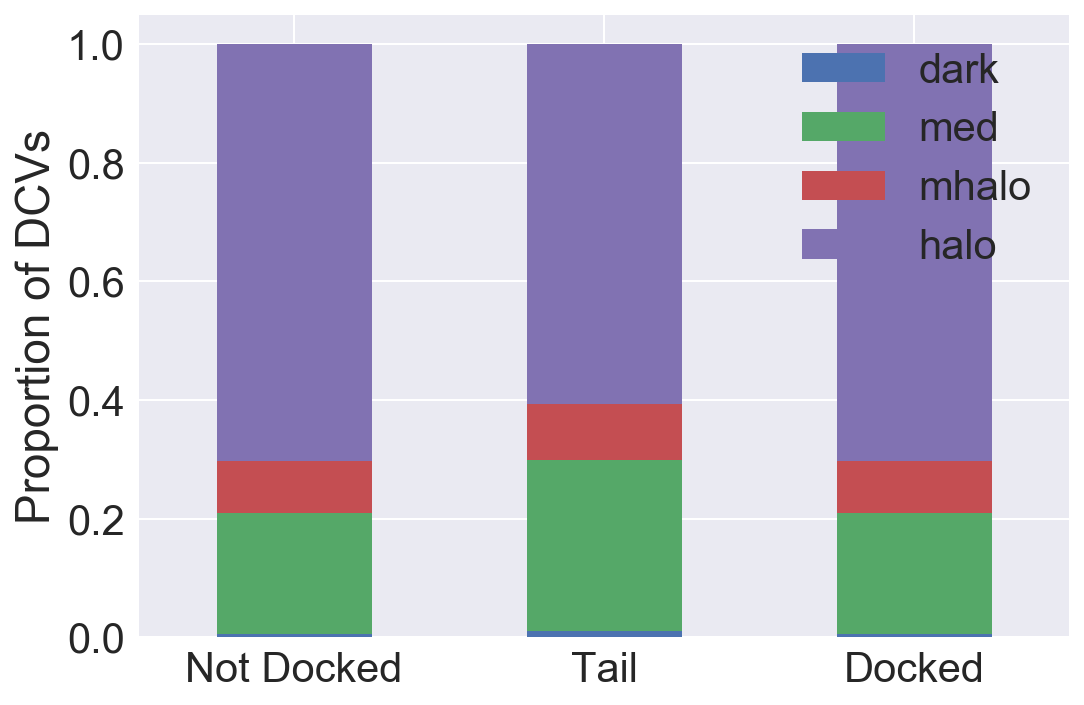

In [51]:
labels = ['Not Docked', 'Tail', 'Docked']
x = [0, 1, 2]
ax = docked_fill_prop_df.plot.bar(stacked = True)
plt.xticks(x, labels, rotation='horizontal')
plt.ylabel('Proportion of DCVs')
# plt.title('DCV Fill')
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV fill vs docked quant.pdf')

## Tethered DCVs

In [52]:
df_teth_value_counts = df.tethered.value_counts()
ORN_teth_value_counts = ORN_df.tethered.value_counts()
PN_teth_value_counts = PN_df.tethered.value_counts()
LN_teth_value_counts = LN_df.tethered.value_counts()

# Have number of "docked" DCVs across cell types.
tethered_dist = [['all', df_teth_value_counts['None'], df_teth_value_counts['docked'], df_teth_value_counts['tail']], 
                 ['ORN', ORN_teth_value_counts['None'], ORN_teth_value_counts['docked'], ORN_teth_value_counts['tail']], 
                 ['PN', PN_teth_value_counts['None'], PN_teth_value_counts['docked'], PN_teth_value_counts['tail']], 
                 ['LN', LN_teth_value_counts['None'], LN_teth_value_counts['docked'], LN_teth_value_counts['tail']]]
tethered_dist_df = pd.DataFrame(tethered_dist, columns = ['Cell_type', 'Not_tethered', 'Docked', 'Tail'])
tethered_dist_df["sum"] = tethered_dist_df.sum(axis=1)

# Need to compute proportions
tethered_prop_df = tethered_dist_df.loc[:,"Not_tethered":"Tail"].div(tethered_dist_df["sum"], axis=0)
tethered_prop_df

,Not_tethered,Docked,Tail
0,0.827612,0.103134,0.069254
1,0.771320,0.172463,0.056217
2,0.831749,0.092600,0.075651
3,0.839828,0.089574,0.070598


/Users/hannah/git/LeeLabScripts/figures


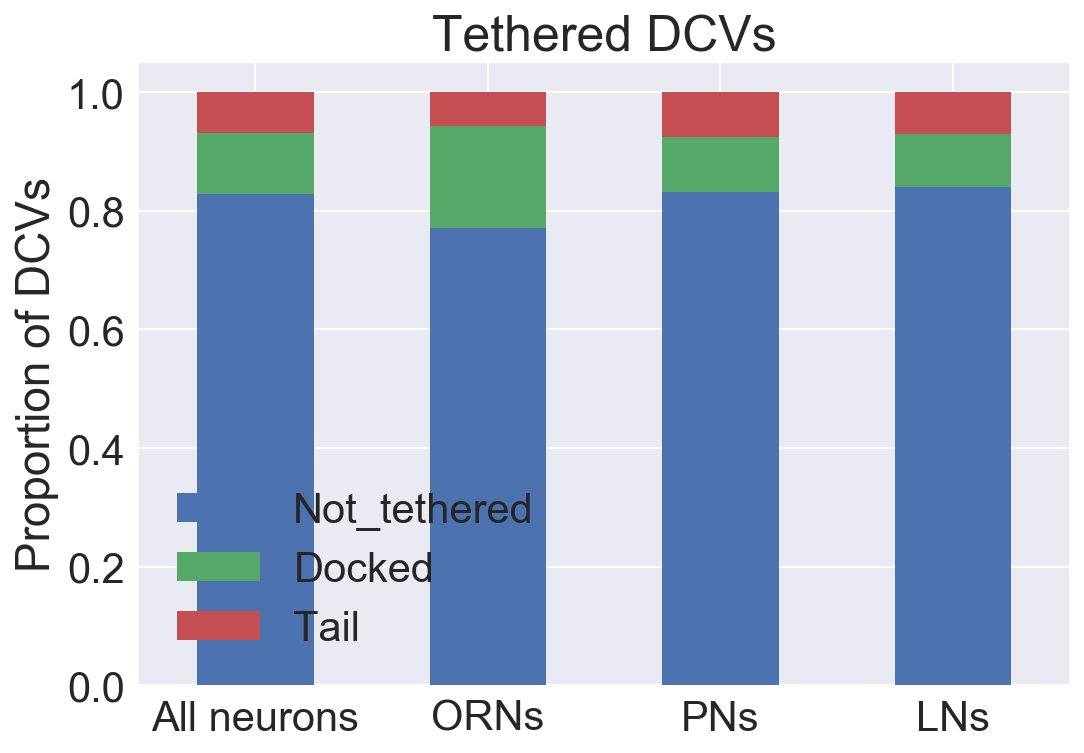

In [53]:
labels = ['All neurons', 'ORNs', 'PNs', 'LNs']
x = [0, 1, 2, 3]
ax = tethered_prop_df.plot.bar(stacked = True)
plt.xticks(x, labels, rotation='horizontal')
plt.ylabel('Proportion of DCVs')
plt.title('Tethered DCVs')
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV tethered quant.pdf')

In [54]:
df

,skeleton_id,connector_id,x,y,z,treenode_id,type,tags,DCV,diameter,fill,small,tethered,DCV_partner_skel_id,mito,t_bar,cell_type,neuron_name
0,75022,13748947,409556,236636,14960,653871,abutting,"[39, DCV, med]",True,78,med,False,None,None,None,None,ORN,DM6 ORN 1
1,75022,13748945,406126,237142,10760,654104,abutting,"[38, DCV, mhalo]",True,76,mhalo,False,None,None,None,None,ORN,DM6 ORN 1
2,75022,13748943,410982,239006,16520,653794,abutting,"[45, DCV, small]",True,90,halo,True,None,None,None,None,ORN,DM6 ORN 1
3,75022,13748941,411066,238938,16440,653797,abutting,"[35, DCV]",True,70,halo,False,None,None,None,None,ORN,DM6 ORN 1
4,75022,13748939,405674,242092,14920,654877,abutting,"[36, DCV]",True,72,halo,False,None,None,None,None,ORN,DM6 ORN 1
5,75022,13748937,405144,241334,14640,654890,abutting,"[59, DCV]",True,118,halo,False,None,None,None,None,ORN,DM6 ORN 1
6,75022,13748935,401288,232488,11560,655101,abutting,"[56, DCV, mhalo]",True,112,mhalo,False,None,None,None,None,ORN,DM6 ORN 1
7,75022,13748933,459304,228148,18160,657823,abutting,"[48, DCV, med]",True,96,med,False,None,None,None,None,ORN,DM6 ORN 1
8,75022,13748931,462590,230322,14440,657971,abutting,"[36, DCV, docked, med, p194509]",True,72,med,False,docked,194509,None,None,ORN,DM6 ORN 1
9,75022,13748929,459954,237134,10400,658161,abutting,"[40, DCV, small]",True,80,halo,True,None,None,None,None,ORN,DM6 ORN 1


In [55]:
def Prop_DCV_tethered_across_neurons(neuron_name, df):
    """Wrapper to compute the proportion of DCVs docked to membranes across neurons
       
       
    Parameters:
    -----------
    neuron_name :            list of neuron names
    
    df :                     df with all the abutting connector data
    
    
    Returns:
    --------
    
    Pandas df with 'not_tethered', 'docked', 'tail', 'neuron_name', 'cell_type'
    
    """
        
    # Initialize master df
    master_df = pd.DataFrame()
    
    for neuron in neuron_name:

        # Get relevant DCVs
        this_df = df.loc[df['neuron_name'] == neuron]
        this_df.reset_index(drop = True, inplace = True)
        
        # Get just dark
        this_not_tethered_df = this_df[this_df['tethered'] == 'None']
        
        # Get just med
        this_docked_df = this_df[this_df['tethered'] == 'docked']
        
        # Get just halo
        this_tail_df = this_df[this_df['tethered'] == 'tail']
        

        # Get the DCV number values for each category
        num_not_tethered = this_not_tethered_df.shape[0]
        num_docked = this_docked_df.shape[0]
        num_tail = this_tail_df.shape[0]
        num_total = this_df.shape[0]

       
        ################################
        # Get this data into dataframe
        count_DCV_data = [num_not_tethered,
                               num_docked,
                               num_tail,
                               num_total]

        
        count_DCV_data_df = pd.DataFrame(count_DCV_data).T
        count_DCV_data_df = count_DCV_data_df.rename(columns = {0:'not_tethered',
                                                              1:'docked',
                                                              2:'tail',
                                                              3:'total'})
        
        # Need to compute proportions
        prop_DCV_df = count_DCV_data_df.loc[:,"not_tethered":"tail"].div(count_DCV_data_df["total"], axis=0)
        prop_DCV_df['neuron_name'] = neuron
        
        # Get cell type
        if 'ORN' in neuron:
            prop_DCV_df['cell_type'] = 'ORN'
        elif 'LN' in neuron: 
            prop_DCV_df['cell_type'] = 'LN'
        elif 'PN' in neuron: 
            prop_DCV_df['cell_type'] = 'PN'   
    
        # Add data to master df
        master_df = master_df.append(prop_DCV_df)
        master_df.reset_index(drop = True, inplace = True)
        
    
    return master_df

In [56]:
prop_DCV_tethered = Prop_DCV_tethered_across_neurons(all_neuron_names, df)
prop_DCV_tethered = prop_DCV_tethered.drop_duplicates('neuron_name')
prop_DCV_tethered.head()

,not_tethered,docked,tail,neuron_name,cell_type
0,0.842466,0.116438,0.041096,DM6 ORN 1,ORN
1,0.800000,0.184000,0.016000,DM6 ORN 2,ORN
2,0.746835,0.189873,0.063291,DM6 ORN 3,ORN
3,0.717172,0.232323,0.050505,DM6 ORN 4,ORN
4,0.738255,0.140940,0.120805,DM6 ORN 5,ORN


/Users/hannah/git/LeeLabScripts/figures
/Users/hannah/git/LeeLabScripts/CSVs


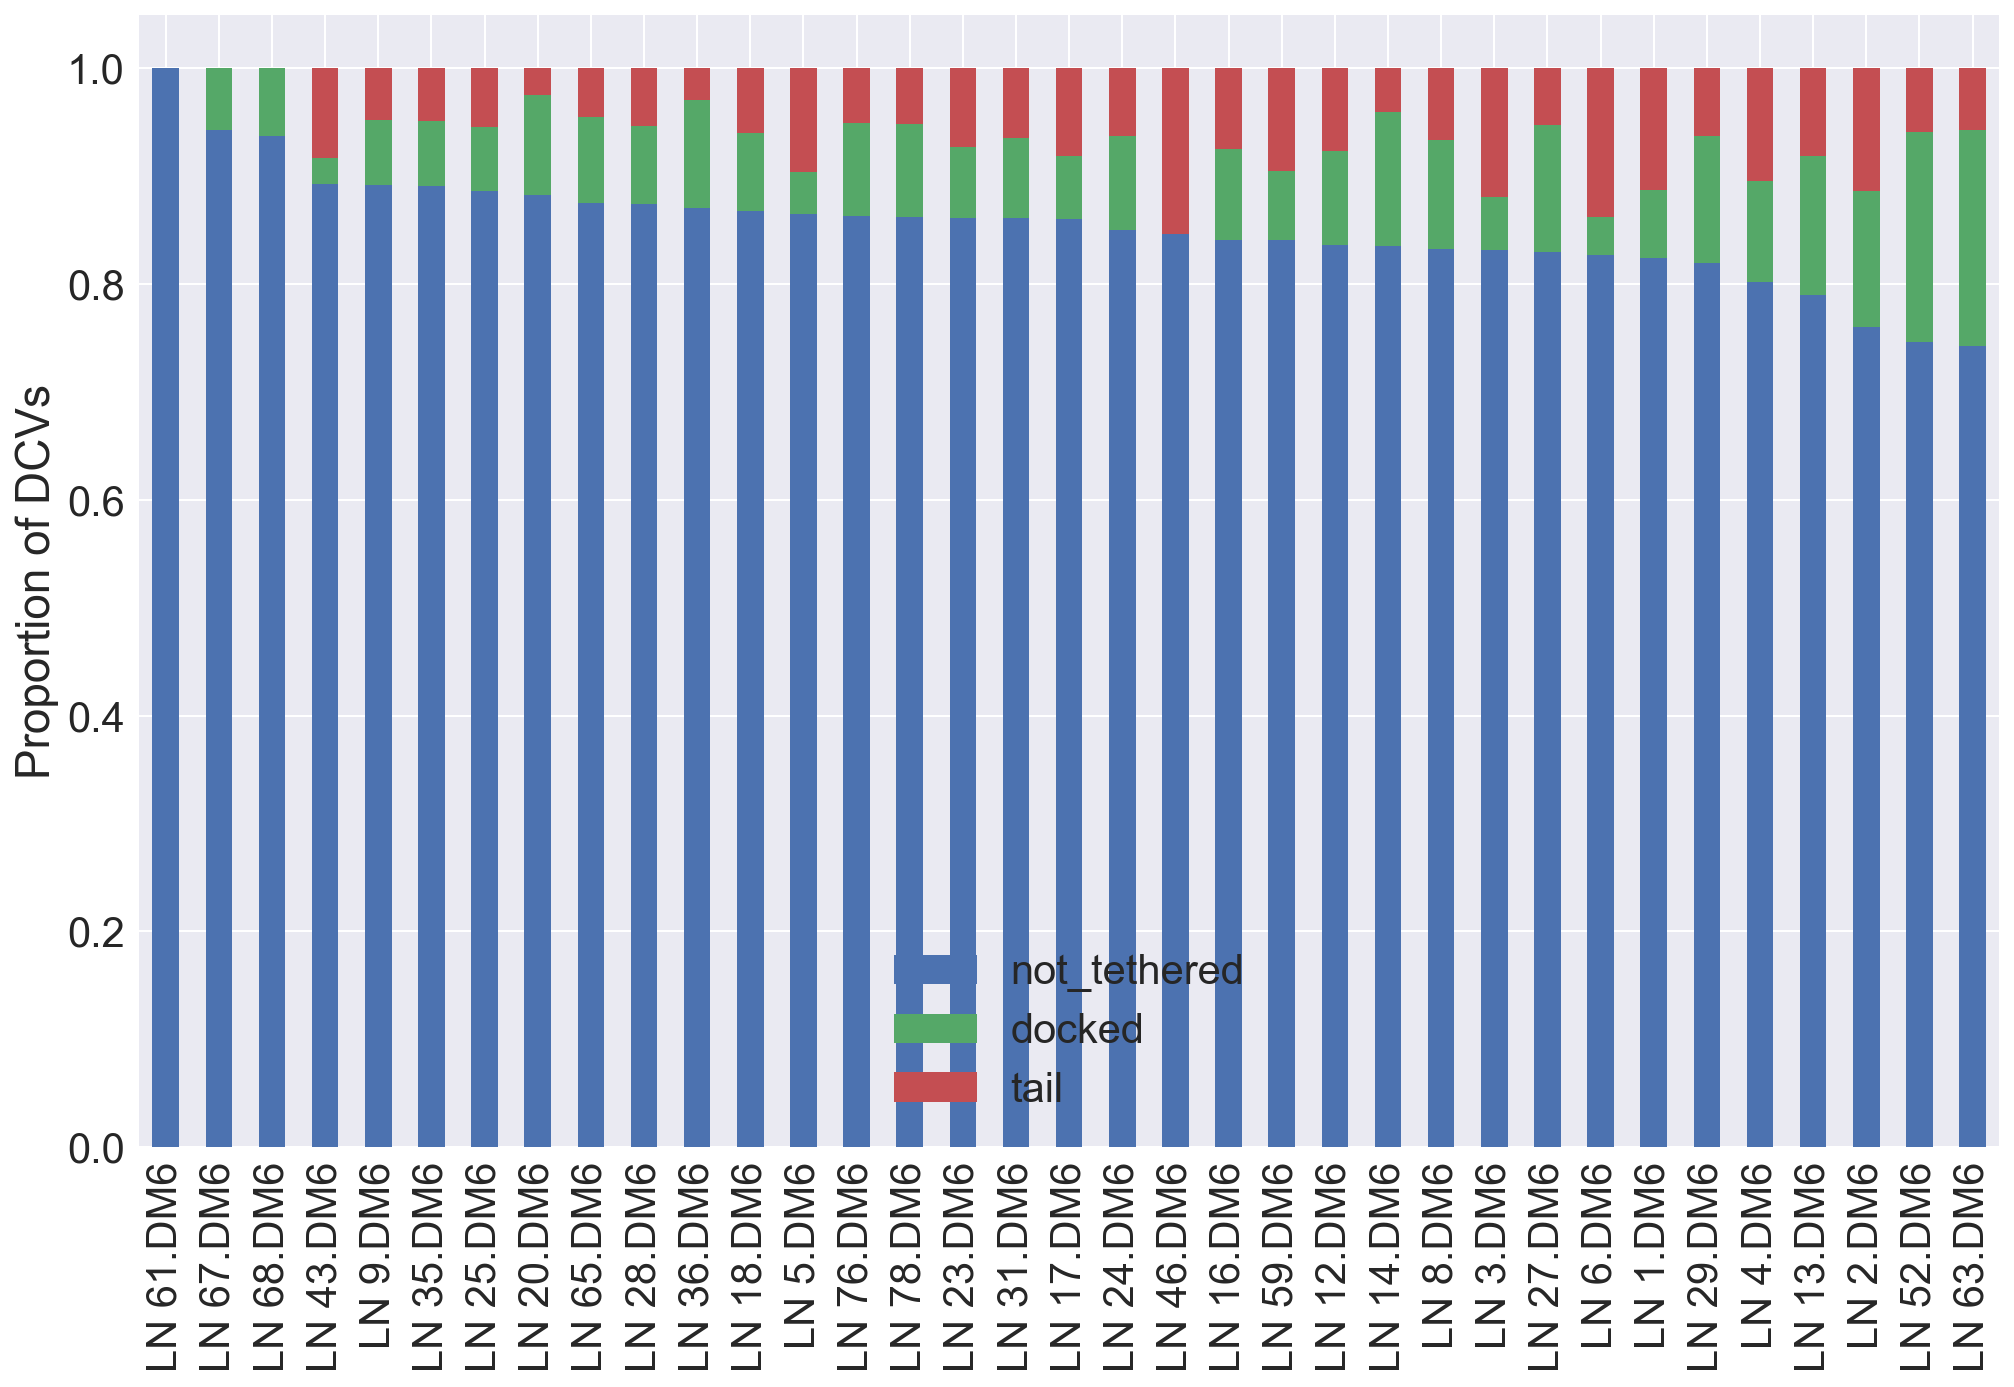

In [57]:
# Plot LNs only --- sorted by presynaptic site

LN_prop_DCV_tethered = prop_DCV_tethered[prop_DCV_tethered['cell_type'] == 'LN']
test = LN_prop_DCV_tethered.copy()


# Drop cells that don't have any DCVs
test = test.dropna()

# Sort this by Prop DCVs that have halo
test = test.sort_values(by='not_tethered', ascending=0)

# Get Skel_id labels
labels = test['neuron_name'].tolist()
x = range(0 , len(test))

# Get relevant data for plot
test_core_data = test[['not_tethered','docked','tail']]

ax = test_core_data.plot.bar(stacked = True, figsize=(16, 10))
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Proportion of DCVs')
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV tethered quant LN.pdf')
%cd /Users/hannah/git/LeeLabScripts/CSVs
LN_prop_DCV_tethered.to_csv('LN_prop_DCV_tethered.csv', encoding = 'utf-8')

/Users/hannah/git/LeeLabScripts/figures


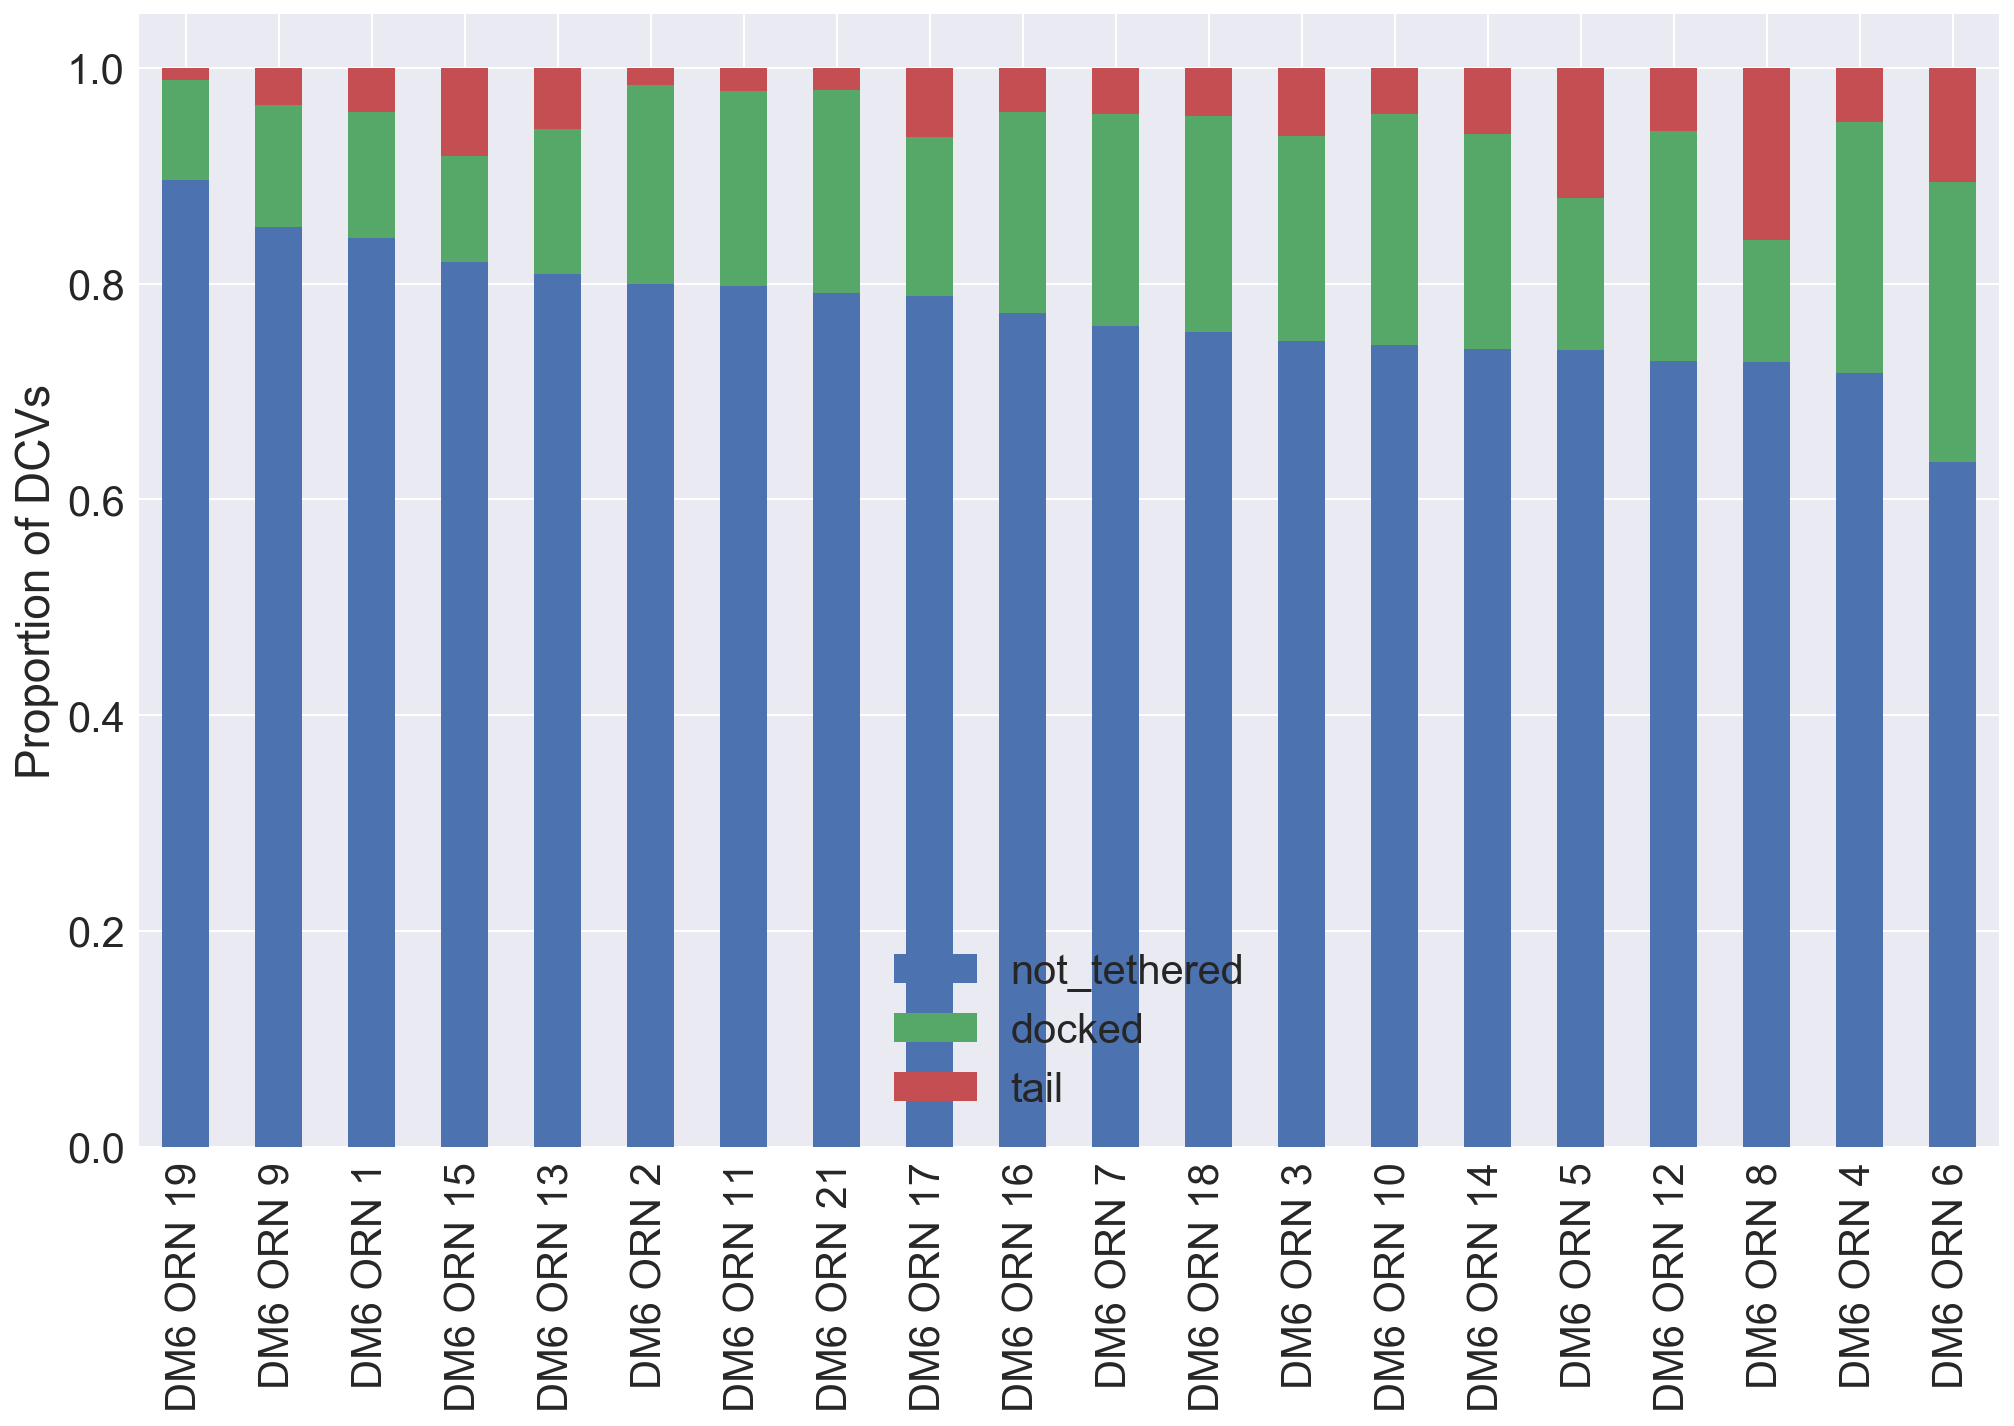

In [58]:
# Plot ORNs only --- sorted by presynaptic site

ORN_prop_DCV_tethered = prop_DCV_tethered[prop_DCV_tethered['cell_type'] == 'ORN']
test = ORN_prop_DCV_tethered.copy()


# Drop cells that don't have any DCVs
test = test.dropna()

# Sort this by Prop DCVs that have halo
test = test.sort_values(by='not_tethered', ascending=0)

# Get Skel_id labels
labels = test['neuron_name'].tolist()
x = range(0 , len(test))

# Get relevant data for plot
test_core_data = test[['not_tethered','docked','tail']]

ax = test_core_data.plot.bar(stacked = True, figsize=(16, 10))
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Proportion of DCVs')
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV tethered quant ORN.pdf')

/Users/hannah/git/LeeLabScripts/figures


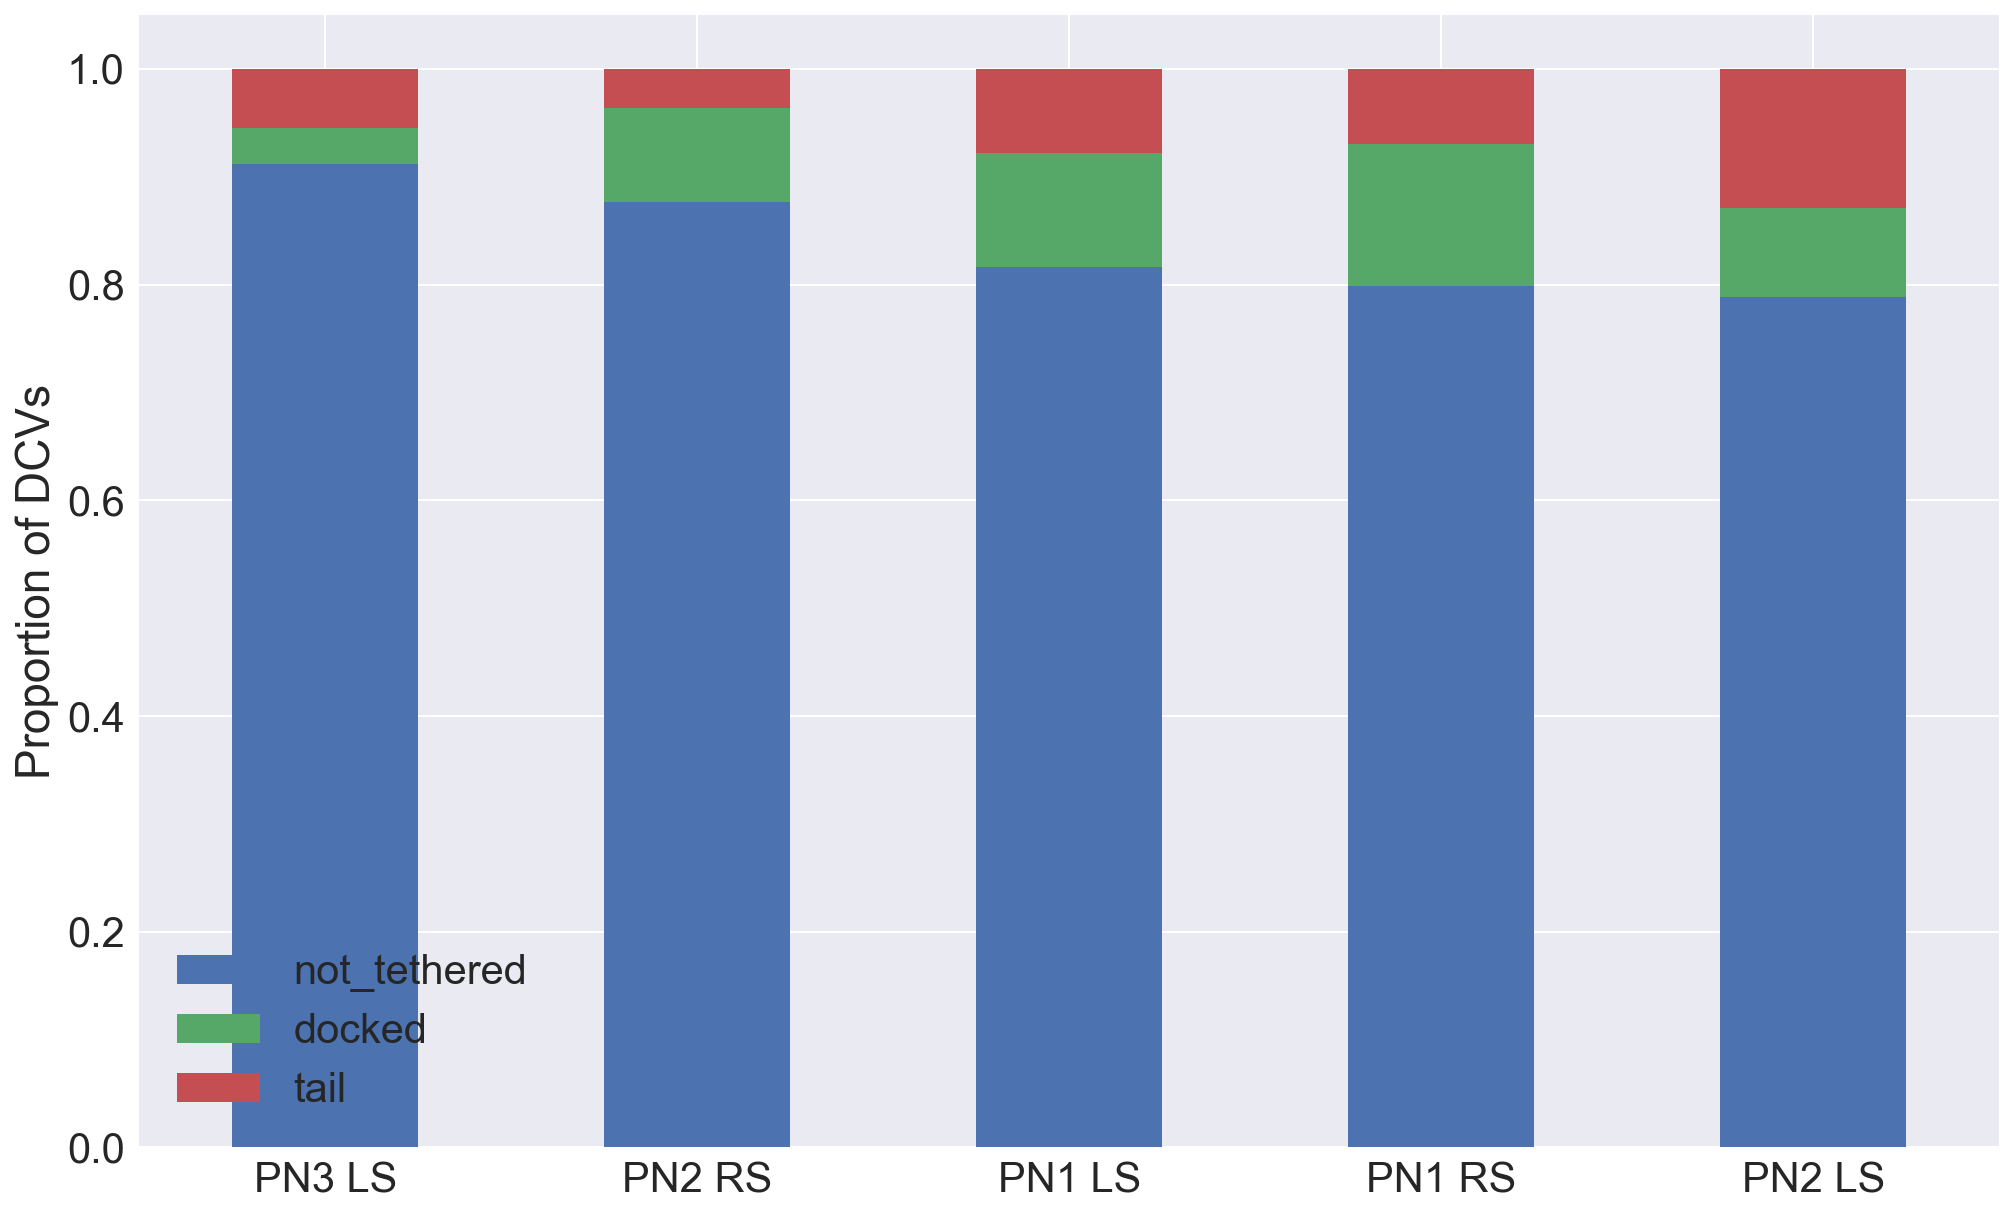

In [59]:
# Plot PNs only --- sorted by presynaptic site

PN_prop_DCV_tethered = prop_DCV_tethered[prop_DCV_tethered['cell_type'] == 'PN']
test = PN_prop_DCV_tethered.copy()


# Drop cells that don't have any DCVs
test = test.dropna()

# Sort this by Prop DCVs that have halo
test = test.sort_values(by='not_tethered', ascending=0)

# Get Skel_id labels
labels = test['neuron_name'].tolist()
x = range(0 , len(test))

# Get relevant data for plot
test_core_data = test[['not_tethered','docked','tail']]

ax = test_core_data.plot.bar(stacked = True, figsize=(16, 10))
plt.xticks(x, labels, rotation='horizontal')
plt.ylabel('Proportion of DCVs')
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV tethered quant PN.pdf')

## Mitos and DCVs

In [60]:
df_mito_value_counts = df.mito.value_counts()
ORN_mito_value_counts = ORN_df.mito.value_counts()
PN_mito_value_counts = PN_df.mito.value_counts()
LN_mito_value_counts = LN_df.mito.value_counts()

# Get number of "mito touching" DCVs across cell types.
mito_dist = [['all', df_mito_value_counts['None'], df_mito_value_counts['mito_docked'], df_mito_value_counts['mito_tail']], 
              ['ORN', ORN_mito_value_counts['None'], ORN_mito_value_counts['mito_docked'], ORN_mito_value_counts['mito_tail']], 
              ['PN', PN_mito_value_counts['None'], PN_mito_value_counts['mito_docked'], PN_mito_value_counts['mito_tail']], 
              ['LN', LN_mito_value_counts['None'], LN_mito_value_counts['mito_docked'], LN_mito_value_counts['mito_tail']]]
mito_dist_df = pd.DataFrame(mito_dist, columns = ['Cell_type', 'Not_tethered_to_mito', 'Docked_on_mito', 'Tail_on_mito'])
mito_dist_df["sum"] = mito_dist_df.sum(axis=1)

# Need to compute proportions
mito_prop_df = mito_dist_df.loc[:,"Not_tethered_to_mito":"Tail_on_mito"].div(mito_dist_df["sum"], axis=0)
mito_prop_df

,Not_tethered_to_mito,Docked_on_mito,Tail_on_mito
0,0.952210,0.034328,0.013462
1,0.959505,0.031920,0.008576
2,0.957007,0.026871,0.016122
3,0.949170,0.036937,0.013894


/Users/hannah/git/LeeLabScripts/figures


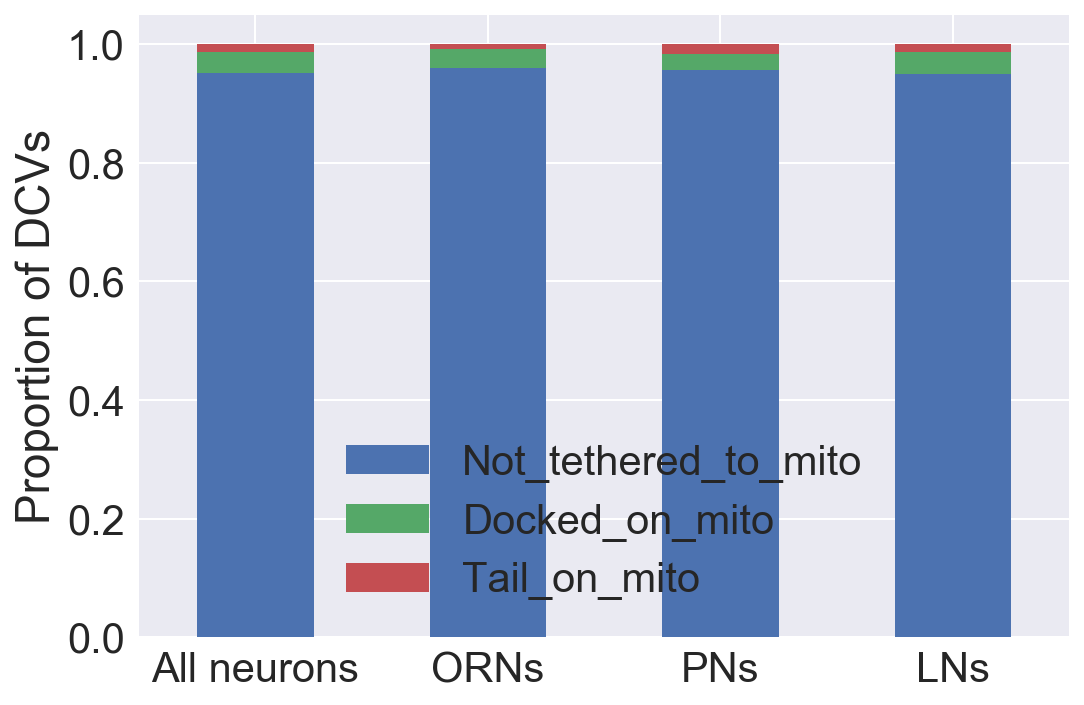

In [61]:
labels = ['All neurons', 'ORNs', 'PNs', 'LNs']
x = [0, 1, 2, 3]
ax = mito_prop_df.plot.bar(stacked = True)
plt.xticks(x, labels, rotation='horizontal')
plt.ylabel('Proportion of DCVs')
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV tethered mito quant.pdf')

In [62]:
def Prop_DCV_mito_across_neurons(neuron_name, df):
    """Wrapper to compute the proportion of DCV docked to mitos across neurons
       
       
    Parameters:
    -----------
    neuron_name :            list of neuron names
    
    df :                     df with all the abutting connector data
    
    
    Returns:
    --------
    
    Pandas df with 'not_tethered_to_mito', 'docked_on_mito', 'tail_on_mito', 'neuron_name', 'cell_type'
    
    """
        
    # Initialize master df
    master_df = pd.DataFrame()
    
    for neuron in neuron_name:

        # Get relevant DCVs
        this_df = df.loc[df['neuron_name'] == neuron]
        this_df.reset_index(drop = True, inplace = True)
        
        # Get just dark
        this_not_tethered_df = this_df[this_df['mito'] == 'None']
        
        # Get just med
        this_docked_df = this_df[this_df['mito'] == 'mito_docked']
        
        # Get just halo
        this_tail_df = this_df[this_df['mito'] == 'mito_tail']
        

        # Get the DCV number values for each category
        num_not_tethered = this_not_tethered_df.shape[0]
        num_docked = this_docked_df.shape[0]
        num_tail = this_tail_df.shape[0]
        num_total = this_df.shape[0]

       
        ################################
        # Get this data into dataframe
        count_DCV_data = [num_not_tethered,
                               num_docked,
                               num_tail,
                               num_total]

        
        count_DCV_data_df = pd.DataFrame(count_DCV_data).T
        count_DCV_data_df = count_DCV_data_df.rename(columns = {0:'not_tethered_to_mito',
                                                              1:'docked_on_mito',
                                                              2:'tail_on_mito',
                                                              3:'total'})
        
        # Need to compute proportions
        prop_DCV_df = count_DCV_data_df.loc[:,"not_tethered_to_mito":"tail_on_mito"].div(count_DCV_data_df["total"], axis=0)
        prop_DCV_df['neuron_name'] = neuron
        
        # Get cell type
        if 'ORN' in neuron:
            prop_DCV_df['cell_type'] = 'ORN'
        elif 'LN' in neuron: 
            prop_DCV_df['cell_type'] = 'LN'
        elif 'PN' in neuron: 
            prop_DCV_df['cell_type'] = 'PN'   
    
        # Add data to master df
        master_df = master_df.append(prop_DCV_df)
        master_df.reset_index(drop = True, inplace = True)
        
    
    return master_df

In [63]:
prop_DCV_tethered_mito = Prop_DCV_mito_across_neurons(all_neuron_names, df)
prop_DCV_tethered_mito = prop_DCV_tethered_mito.drop_duplicates('neuron_name')
prop_DCV_tethered_mito.head()

,not_tethered_to_mito,docked_on_mito,tail_on_mito,neuron_name,cell_type
0,0.972603,0.020548,0.006849,DM6 ORN 1,ORN
1,0.976000,0.024000,0.000000,DM6 ORN 2,ORN
2,0.987342,0.006329,0.006329,DM6 ORN 3,ORN
3,0.989899,0.010101,0.000000,DM6 ORN 4,ORN
4,0.993289,0.006711,0.000000,DM6 ORN 5,ORN


/Users/hannah/git/LeeLabScripts/figures
/Users/hannah/git/LeeLabScripts/CSVs


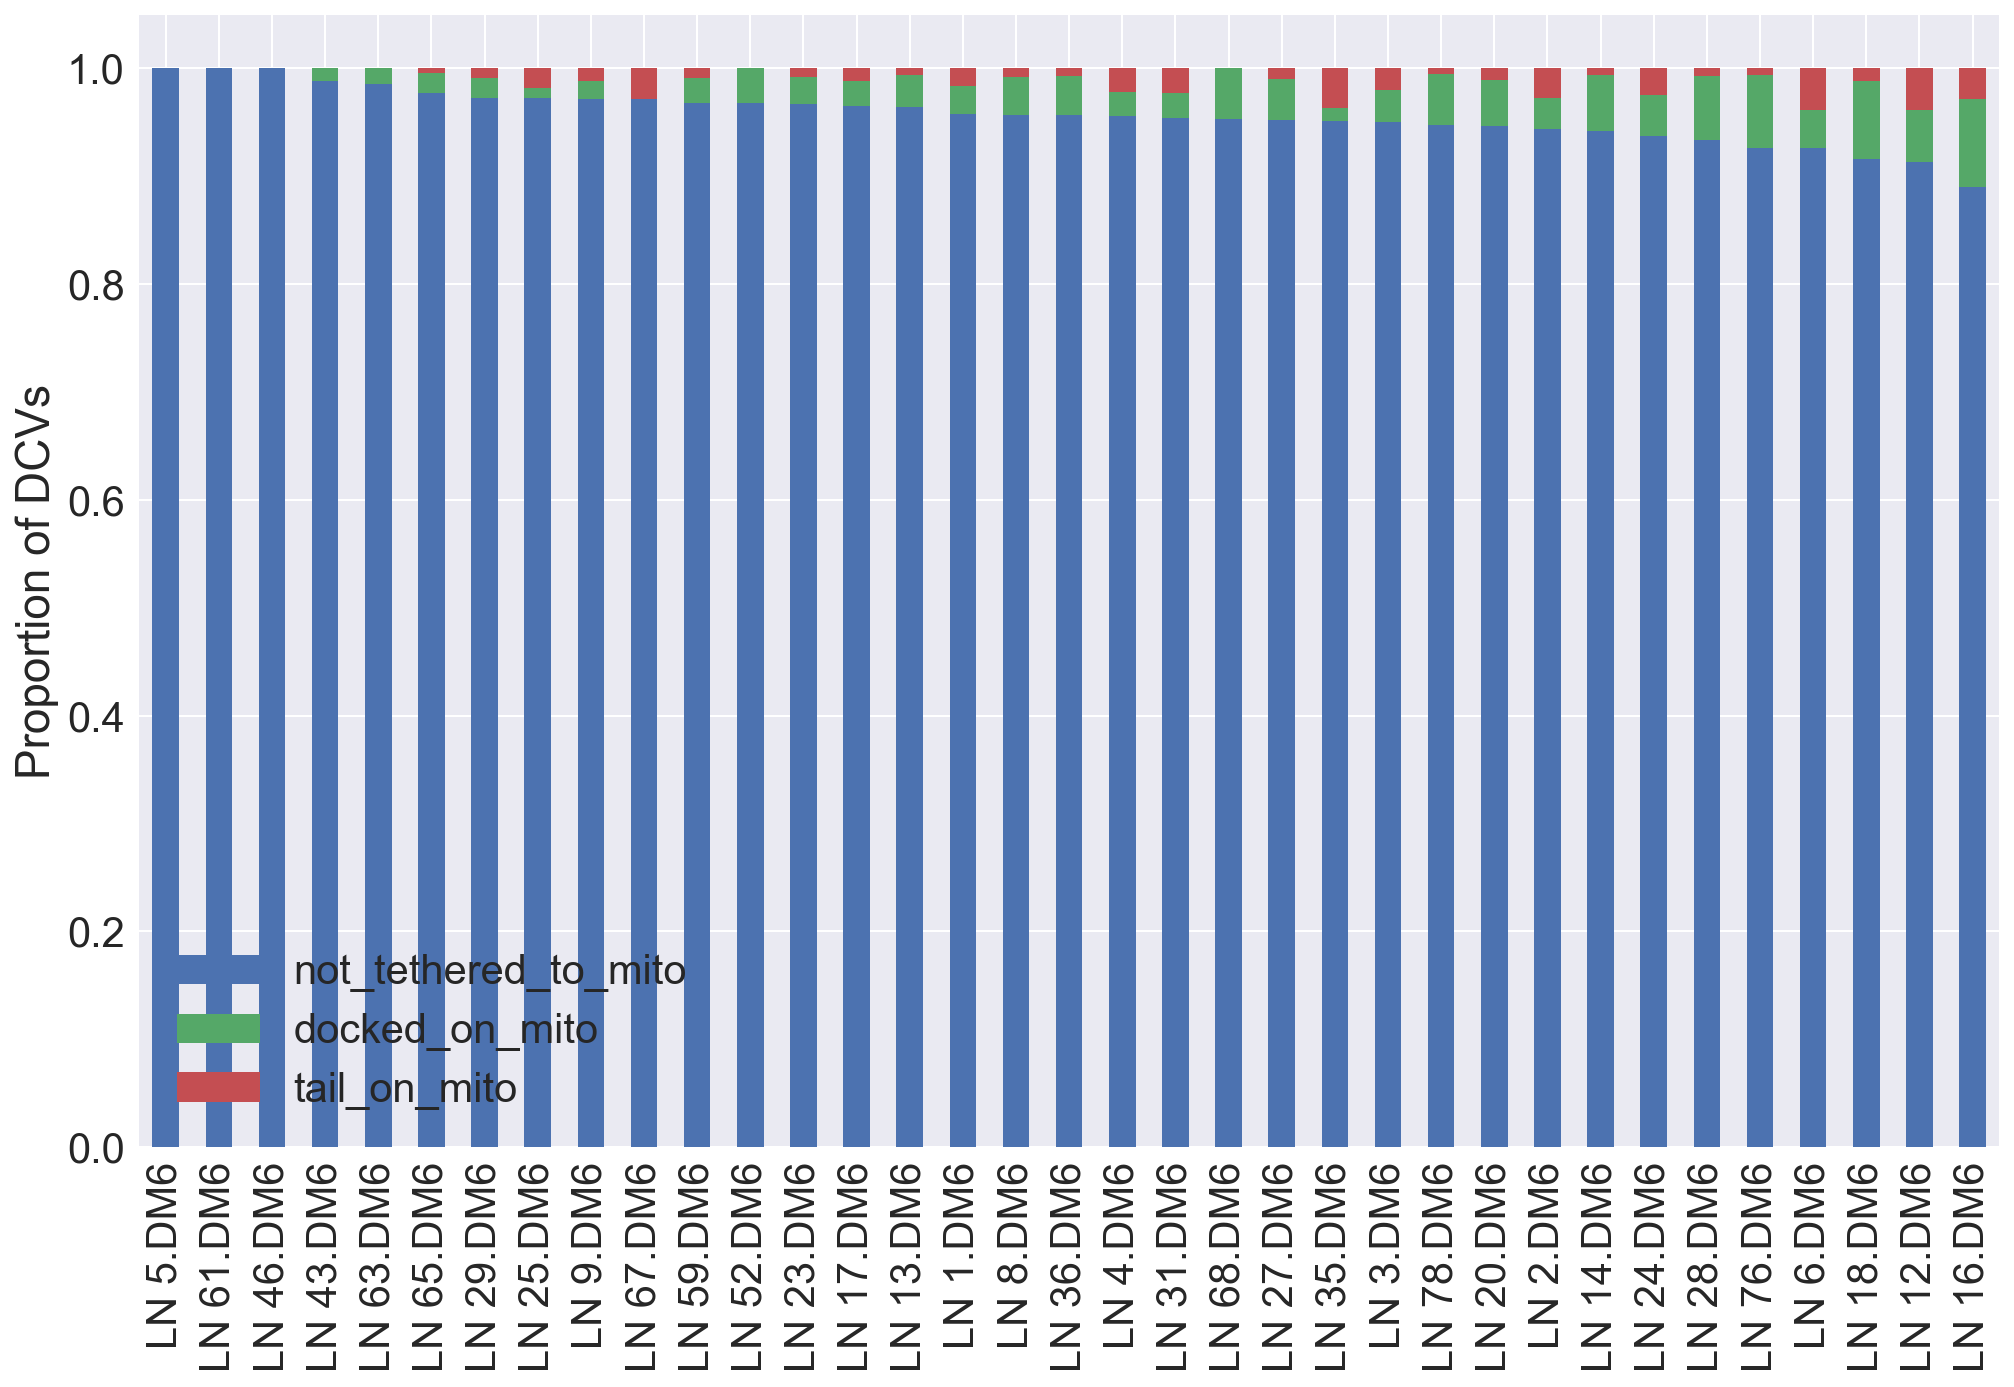

In [64]:
# Plot LNs only

LN_prop_DCV_tethered_mito = prop_DCV_tethered_mito[prop_DCV_tethered_mito['cell_type'] == 'LN']
test = LN_prop_DCV_tethered_mito.copy()


# Drop cells that don't have any DCVs
test = test.dropna()

# Sort this by Prop DCVs that have halo
test = test.sort_values(by='not_tethered_to_mito', ascending=0)

# Get Skel_id labels
labels = test['neuron_name'].tolist()
x = range(0 , len(test))

# Get relevant data for plot
test_core_data = test[['not_tethered_to_mito','docked_on_mito','tail_on_mito']]

ax = test_core_data.plot.bar(stacked = True, figsize=(16, 10))
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Proportion of DCVs')
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV tethered mito quant LN.pdf')
%cd /Users/hannah/git/LeeLabScripts/CSVs
LN_prop_DCV_tethered_mito.to_csv('LN_prop_DCV_tethered_mito.csv', encoding = 'utf-8')

/Users/hannah/git/LeeLabScripts/figures


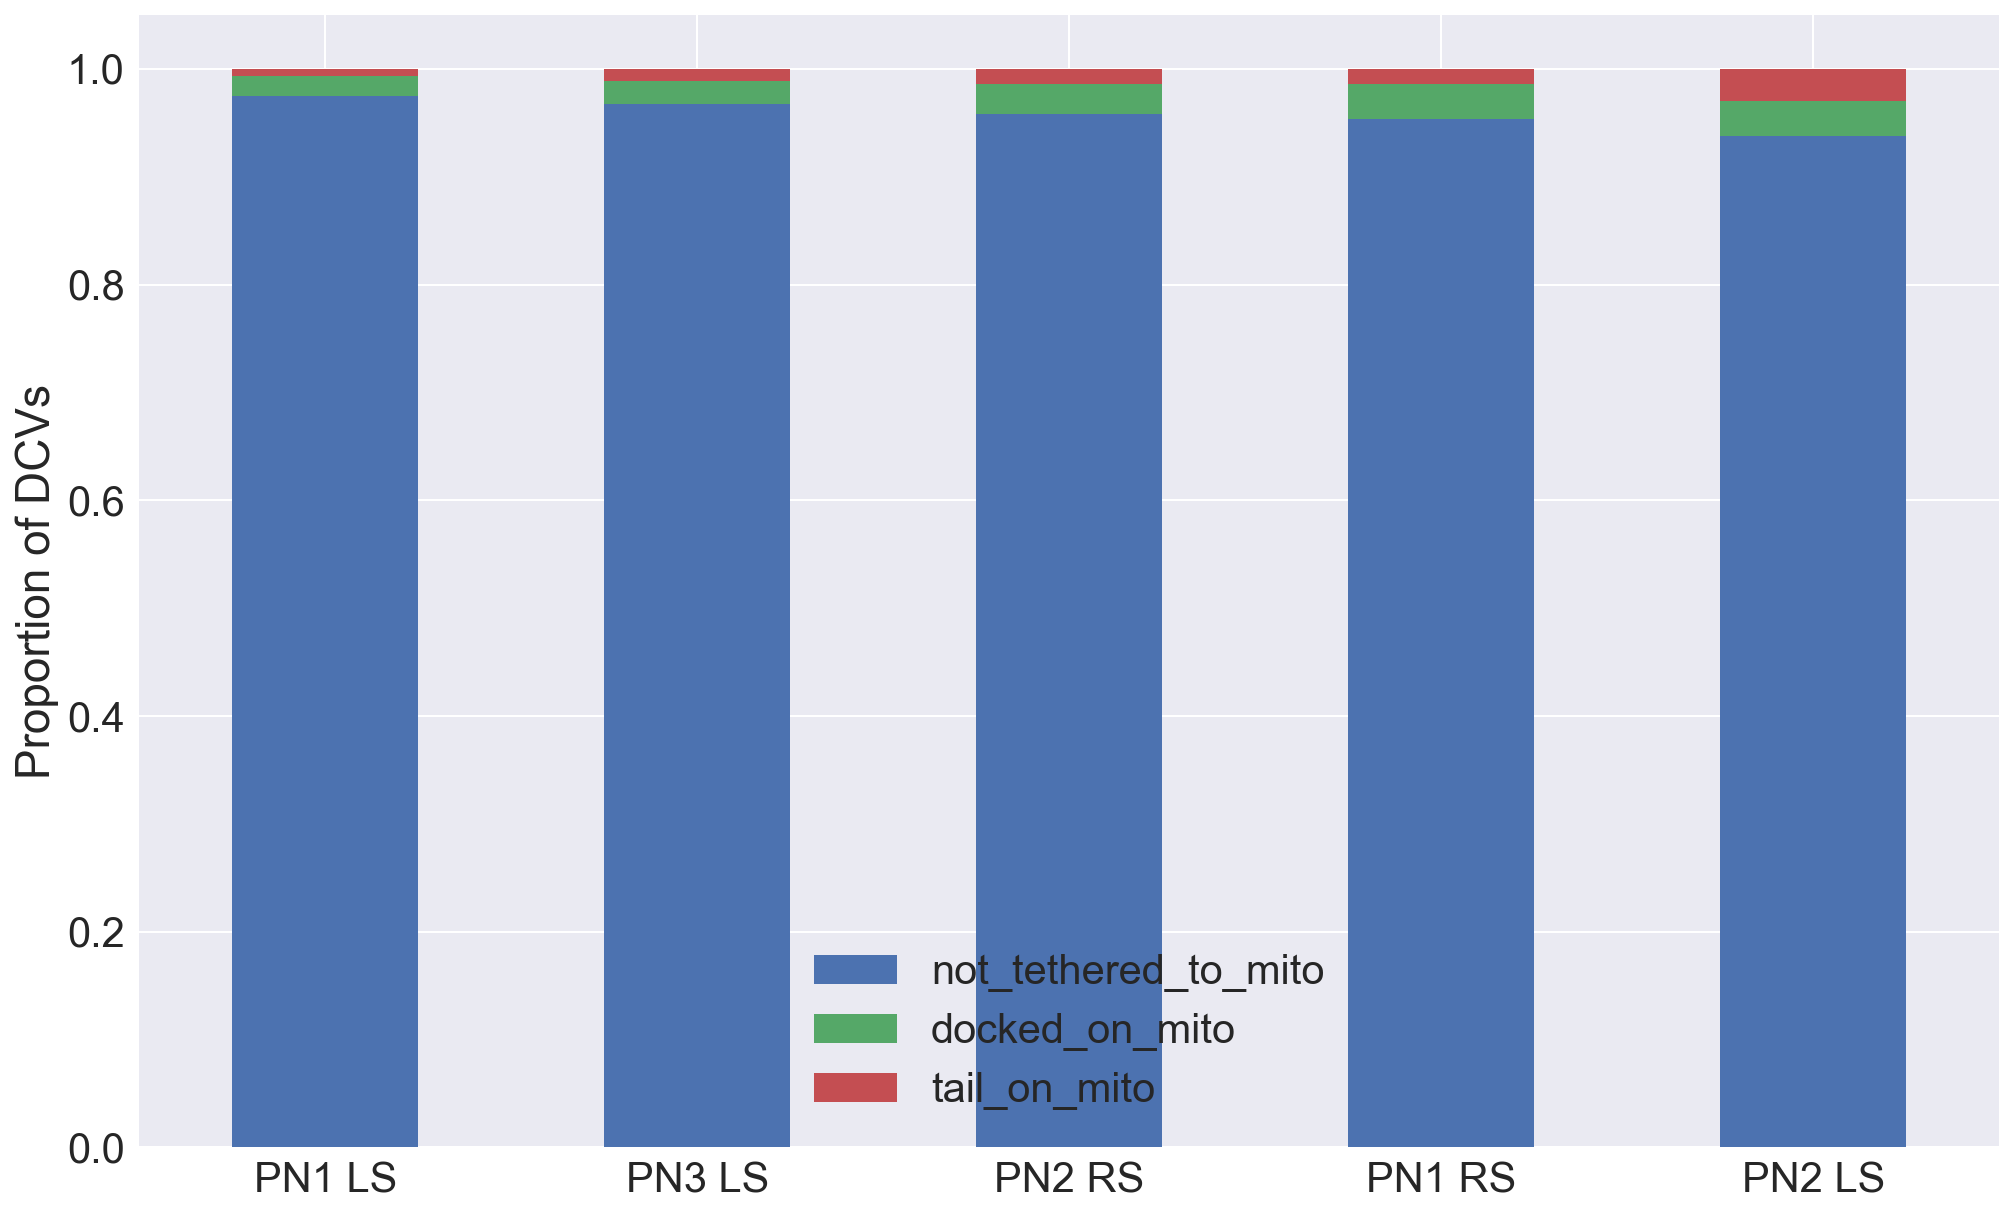

In [65]:
# Plot PNs only

PN_prop_DCV_tethered_mito = prop_DCV_tethered_mito[prop_DCV_tethered_mito['cell_type'] == 'PN']
test = PN_prop_DCV_tethered_mito.copy()


# Drop cells that don't have any DCVs
test = test.dropna()

# Sort this by Prop DCVs that have halo
test = test.sort_values(by='not_tethered_to_mito', ascending=0)

# Get Skel_id labels
labels = test['neuron_name'].tolist()
x = range(0 , len(test))

# Get relevant data for plot
test_core_data = test[['not_tethered_to_mito','docked_on_mito','tail_on_mito']]

ax = test_core_data.plot.bar(stacked = True, figsize=(16, 10))
plt.xticks(x, labels, rotation='horizontal')
plt.ylabel('Proportion of DCVs')
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV tethered mito quant PN.pdf')

/Users/hannah/git/LeeLabScripts/figures


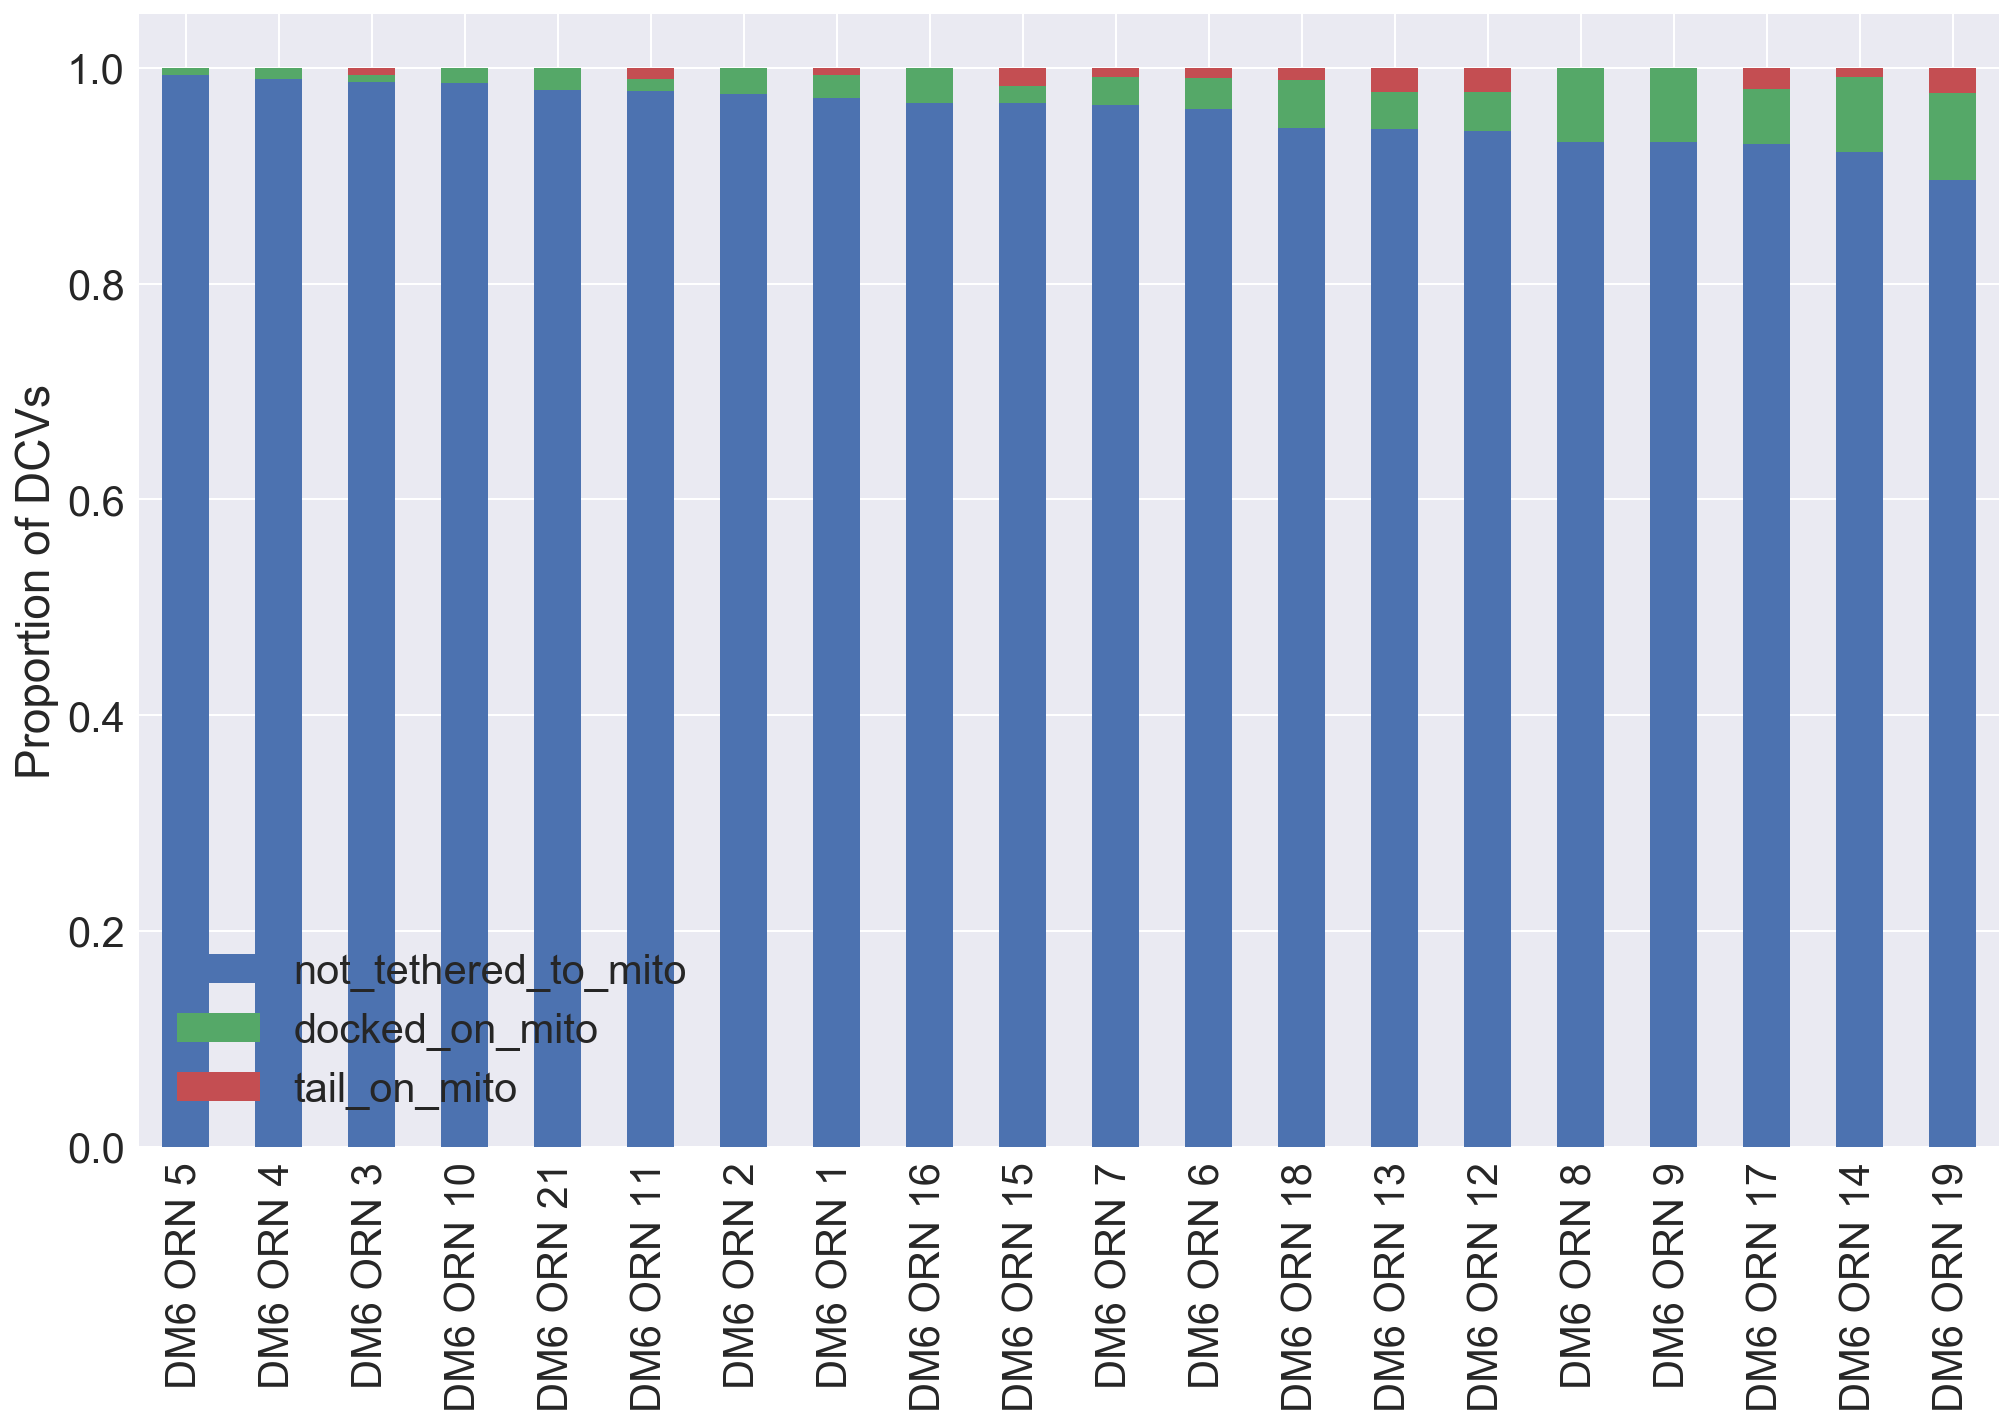

In [66]:
# Plot ORNs only

ORN_prop_DCV_tethered_mito = prop_DCV_tethered_mito[prop_DCV_tethered_mito['cell_type'] == 'ORN']
test = ORN_prop_DCV_tethered_mito.copy()


# Drop cells that don't have any DCVs
test = test.dropna()

# Sort this by Prop DCVs that have halo
test = test.sort_values(by='not_tethered_to_mito', ascending=0)

# Get Skel_id labels
labels = test['neuron_name'].tolist()
x = range(0 , len(test))

# Get relevant data for plot
test_core_data = test[['not_tethered_to_mito','docked_on_mito','tail_on_mito']]

ax = test_core_data.plot.bar(stacked = True, figsize=(16, 10))
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('Proportion of DCVs')
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV tethered mito quant ORN.pdf')

## Calculate # DCVs / neuron pathlength

In [67]:
#Get skeleton data for all neurons
skdata = get_3D_skeleton(all_neurons, 
                          Myinstance, 
                          connector_flag=1, 
                          tag_flag=1, 
                          get_history=False, 
                          get_merge_history=False, 
                          time_out=None, 
                          get_abutting=True,
                          project_id = 3
                         )
skdata.head()

,neuron_name,skeleton_id,nodes,connectors,tags
0,DM6 ORN 1,75022,treenode_id parent_id creator_id x ...,treenode_id connector_id relation x ...,"{'left axon': [650950], 'PS: maybe syn S': [65..."
1,DM6 ORN 2,214902,treenode_id parent_id creator_id x ...,treenode_id connector_id relation x ...,{'WT: The following sections are exceedingly u...
2,DM6 ORN 3,206984,treenode_id parent_id creator_id x ...,treenode_id connector_id relation x ...,"{'left axon': [3064925], 'PS: syn E': [3065244..."
3,DM6 ORN 4,197072,treenode_id parent_id creator_id x ...,treenode_id connector_id relation x ...,"{'left axon': [2908435], 'p197072': [2911131],..."
4,DM6 ORN 5,146356,treenode_id parent_id creator_id x ...,treenode_id connector_id relation x ...,{'RC: probably but not 100% confidence': [2072...


In [68]:
test_df = skdata.ix[0]
test_df.nodes.head()

,treenode_id,parent_id,creator_id,x,y,z,radius,confidence
0,650948,None,28,457253,227899,18960,-1,5
1,650950,650948,28,457156,227752,19000,-1,5
2,650951,650950,28,457104,227789,19040,-1,5
3,650953,650951,28,457104,227806,19080,-1,5
4,650955,650953,28,457120,227822,19120,-1,5


In [69]:
# Calculate cable length for each neuron
neuron_skel_id = []
neuron_lengths = []

df_index = list(range(0, skdata.shape[0]))

for index in df_index:

    # Get neuron names
    neuron_skel_id.append(skdata.ix[index]['skeleton_id'])
    
    # Get neuron length
    neuron_lengths.append(calc_cable(skdata.ix[index], 
                                     remote_instance = Myinstance, 
                                     project_id = 3))
    
# Put into dataframe
neuron_lengths_df = (pd.DataFrame([neuron_skel_id, neuron_lengths])).T
neuron_lengths_df.columns = ['skeleton_id', 'total_neuron_length_um']


# Get number of DCVs per neuron - Note that if neurons are missing from this dict that means
# that they don't have any DCVs
DCV_counts = df['skeleton_id'].value_counts()
DCV_counts_dict = DCV_counts.to_dict()


# Get number of DCVs
num_DCVs = []

for skel_id in neuron_skel_id:
    if int(skel_id) in DCV_counts_dict:
        # Get number of DCVs
        num_DCVs.append(DCV_counts_dict[int(skel_id)])
    # No DCVs in this neuron
    else:
        num_DCVs.append(0)
        
# Add these values to the df
neuron_lengths_df['num_DCVs'] = num_DCVs


# have to deal with the LNs that are broken into two fragments

# Add new column with neuron names
neuron_lengths_df['neuron_name'] = 'None'

for (index, row) in neuron_lengths_df.iterrows():
    neuron_name = str(neuron_lengths_df.iat[index, 0])
    neuron_lengths_df.iat[index, 3] = neuron_dictionary[neuron_name]
    
    
    
# Trying to sum these values in an eloquent way, but too frustrated with the groupby/sum combo not doing what I want...

# Get data
# LN_9 = neuron_lengths_df[22:24]
# LN_25 = neuron_lengths_df[33:35]
# LN_43 = neuron_lengths_df[43:45]
LN_9 = neuron_lengths_df[neuron_lengths_df['neuron_name'] == 'LN 9.DM6']
LN_25 = neuron_lengths_df[neuron_lengths_df['neuron_name'] == 'LN 25.DM6']
LN_43 = neuron_lengths_df[neuron_lengths_df['neuron_name'] == 'LN 43.DM6']

# Get sums
LN_9_sum = LN_9[['total_neuron_length_um', 'num_DCVs']].sum()
LN_25_sum = LN_25[['total_neuron_length_um', 'num_DCVs']].sum()
LN_43_sum = LN_43[['total_neuron_length_um', 'num_DCVs']].sum()

# put data into DataFrame
data = np.array([['', 'skeleton_id', 'total_neuron_length_um', 'num_DCVs', 'neuron_name'],
                            ['0', 'XXXX', LN_9_sum[0], LN_9_sum[1], 'LN 9.DM6'],
                            ['1', 'XXXX', LN_25_sum[0], LN_25_sum[1], 'LN 25.DM6'],
                            ['2', 'XXXX', LN_43_sum[0], LN_43_sum[1], 'LN 43.DM6']])
filtered_LN_data_df = pd.DataFrame(data=data[1:,1:],
                                   index=data[1:,0],
                                   columns=data[0,1:])
# Drop rows for these LN fragments from inital DataFrame
# neuron_lengths_df = neuron_lengths_df.drop(neuron_lengths_df.index[[22, 23, 33, 34, 43, 44]])
neuron_lengths_df = neuron_lengths_df[neuron_lengths_df.neuron_name != 'LN 9.DM6']
neuron_lengths_df = neuron_lengths_df[neuron_lengths_df.neuron_name != 'LN 25.DM6']
neuron_lengths_df = neuron_lengths_df[neuron_lengths_df.neuron_name != 'LN 43.DM6']

# Add new filtered rows to original df
neuron_lengths_df = neuron_lengths_df.append(filtered_LN_data_df)

# Fix index
neuron_lengths_df.reset_index(drop = True, inplace = True)

In [70]:
# Label neuron type
neuron_lengths_df['cell_type'] = 'None'

for (index, row) in neuron_lengths_df.iterrows():
    if str(neuron_lengths_df.iat[index, 0]) in ORNs:
        neuron_lengths_df.iat[index, 4] = 'ORN'
    elif str(neuron_lengths_df.iat[index, 0]) in PNs:
        neuron_lengths_df.iat[index, 4] = 'PN'
    elif str(neuron_lengths_df.iat[index, 0]) in LNs:
        neuron_lengths_df.iat[index, 4] = 'LN'
    elif str(neuron_lengths_df.iat[index, 0]) == 'XXXX':
        neuron_lengths_df.iat[index, 4] = 'LN'
neuron_lengths_df.head()

#Convert data columns to correct type
neuron_lengths_df['total_neuron_length_um'] = neuron_lengths_df['total_neuron_length_um'].astype('float')
neuron_lengths_df['num_DCVs'] = neuron_lengths_df['num_DCVs'].astype('float')

/Users/hannah/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



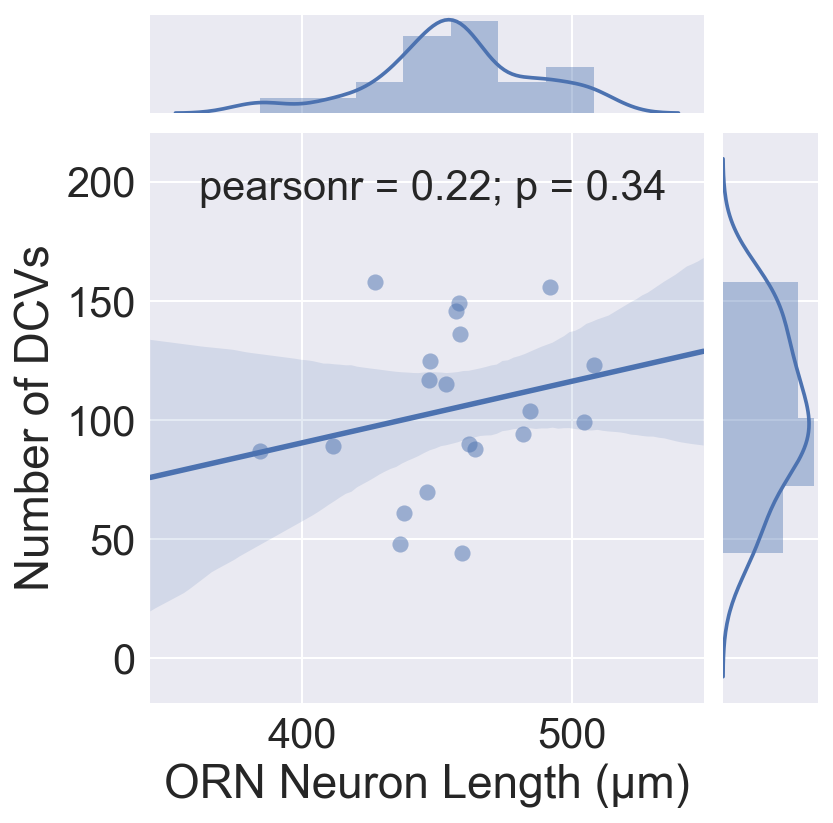

In [71]:
# Get only ORNs
ORN_lengths_df = neuron_lengths_df[neuron_lengths_df['cell_type'] == 'ORN']
sns.jointplot(x="total_neuron_length_um", y="num_DCVs", data=ORN_lengths_df, kind = "reg",
             scatter_kws={"s": 60, "alpha": .5})
plt.ylabel('Number of DCVs')
plt.xlabel('ORN Neuron Length (µm)')

/Users/hannah/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



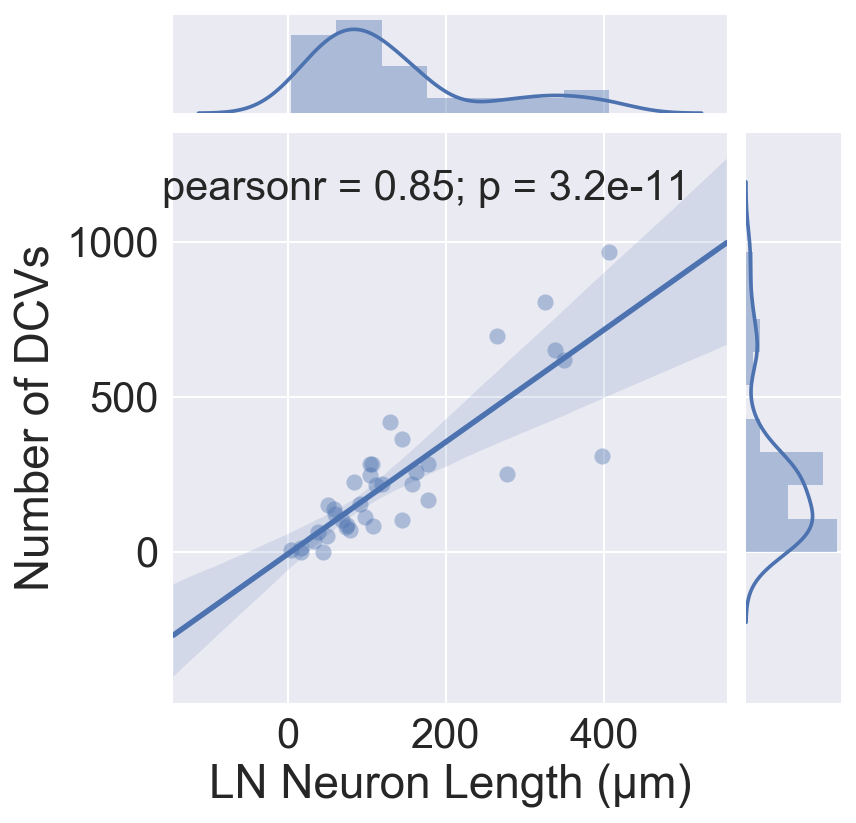

In [72]:
# Get only LNs
LN_lengths_df = neuron_lengths_df[neuron_lengths_df['cell_type'] == 'LN']
sns.jointplot(x="total_neuron_length_um", y="num_DCVs", data=LN_lengths_df, kind = "reg",
             scatter_kws={"s": 60, "alpha": .4})
plt.ylabel('Number of DCVs')
plt.xlabel('LN Neuron Length (µm)')

/Users/hannah/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



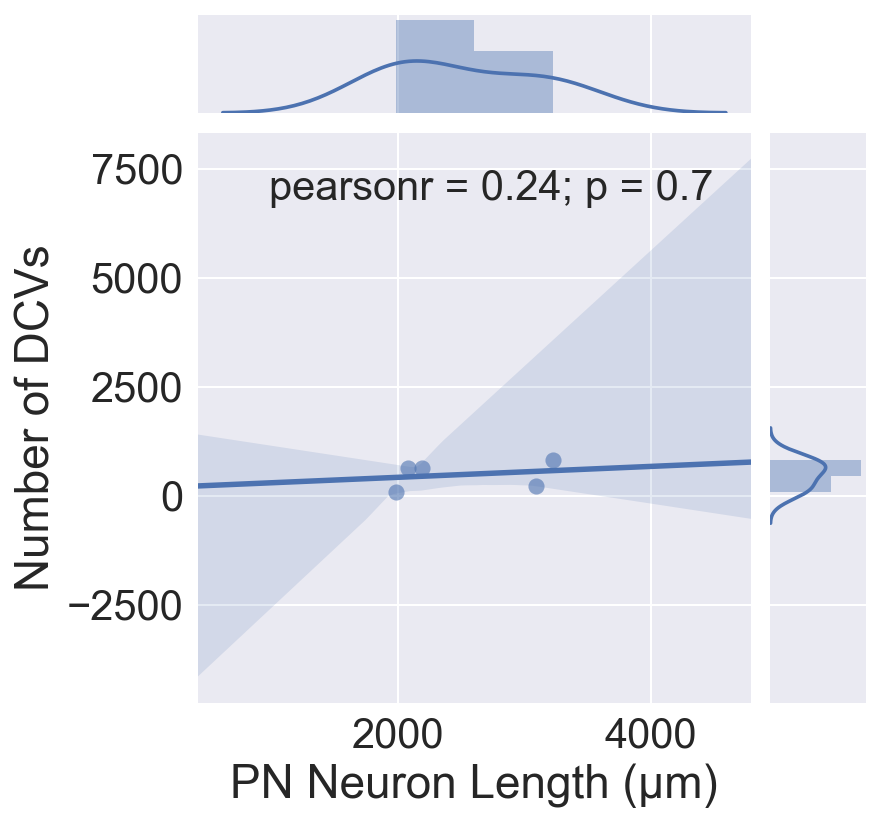

In [73]:
# Get only PNs
PN_lengths_df = neuron_lengths_df[neuron_lengths_df['cell_type'] == 'PN']
sns.jointplot(x="total_neuron_length_um", y="num_DCVs", data=PN_lengths_df, kind = "reg",
             scatter_kws={"s": 60, "alpha": .6})
plt.ylabel('Number of DCVs')
plt.xlabel('PN Neuron Length (µm)')

/Users/hannah/git/LeeLabScripts/figures


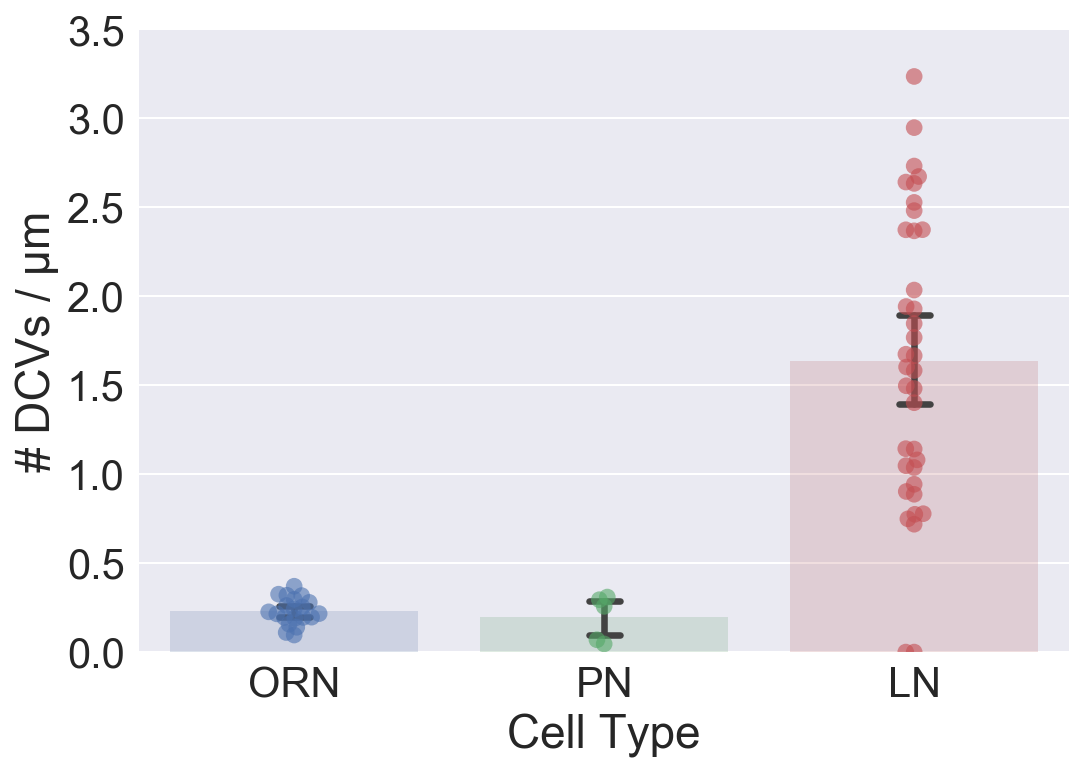

In [74]:
# Get number of DCVs/neuron length
neuron_lengths_df['DCV/length'] = neuron_lengths_df['num_DCVs'] / neuron_lengths_df['total_neuron_length_um']

# Plot these values
sns.swarmplot(x="cell_type", y="DCV/length", data = neuron_lengths_df, alpha = .6, size = 8, marker = 'o')
sns.barplot(x="cell_type", y="DCV/length", data = neuron_lengths_df, alpha = .2, capsize = .1)
plt.ylabel('# DCVs / µm')
plt.xlabel('Cell Type')
plt.ylim([0,3.5])
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV per um full cells.pdf')

In [75]:
neuron_lengths_df.head()

,skeleton_id,total_neuron_length_um,num_DCVs,neuron_name,cell_type,DCV/length
0,75022,457.090026,146.0,DM6 ORN 1,ORN,0.319412
1,214902,447.529698,125.0,DM6 ORN 2,ORN,0.279311
2,206984,426.903165,158.0,DM6 ORN 3,ORN,0.370107
3,197072,504.287580,99.0,DM6 ORN 4,ORN,0.196317
4,146356,457.974623,149.0,DM6 ORN 5,ORN,0.325346


In [76]:
LN_neuron_lengths_df = neuron_lengths_df[neuron_lengths_df['cell_type'] == 'LN']
LN_neuron_lengths_df = LN_neuron_lengths_df.sort_values(by = 'DCV/length', ascending = 0)
LN_neuron_lengths_df.head()

,skeleton_id,total_neuron_length_um,num_DCVs,neuron_name,cell_type,DCV/length
41,80973,129.232048,418.0,LN 27.DM6,LN,3.234492
42,44197,51.239827,151.0,LN 28.DM6,LN,2.946926
35,57278,103.616833,283.0,LN 16.DM6,LN,2.731216
53,81961,83.824667,224.0,LN 65.DM6,LN,2.672244
38,80018,106.774216,282.0,LN 20.DM6,LN,2.641087


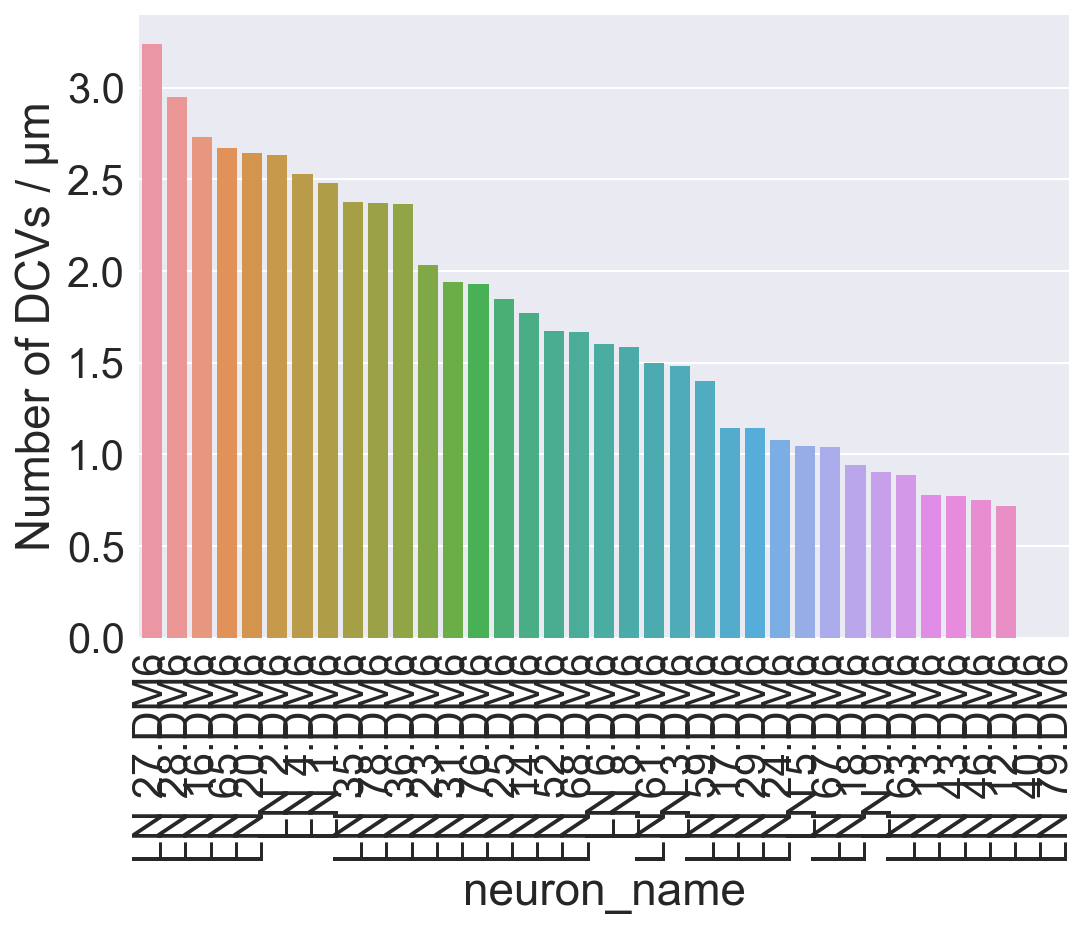

In [77]:
sns.barplot(x = 'neuron_name', y = 'DCV/length', data = LN_neuron_lengths_df)
plt.xticks(rotation='vertical')
plt.ylabel('Number of DCVs / µm')

In [78]:
%cd /Users/hannah/git/LeeLabScripts/CSVs
# Get data for LNs to download for PCA
LN_DCV_per_neuron_lengths_df = neuron_lengths_df[neuron_lengths_df['cell_type'] == 'LN']
LN_DCV_per_neuron_lengths_df.to_csv('LN_DCV_per_neuron_lengths_df.csv', encoding = 'utf-8')

/Users/hannah/git/LeeLabScripts/CSVs


So we see a huge amount of variablility in the number of DCVs/µm within LNs, which is to be expected. However, it is difficult to compare across cell types, because we have pathlengths for ORNs and PNs extending outside of DM6, but only for DM6 for LNs. Thus, we need to repeat these calculations, but for DCVs only within DM6 for ORNs and PNs.

## Plot DCVs in XYZ space

In [79]:
LNs_only_df = df[df['cell_type'] == 'LN']
PNs_only_df = df[df['cell_type'] == 'PN']
ORNs_only_df = df[df['cell_type'] == 'ORN']
PNs_only_df.head()

,skeleton_id,connector_id,x,y,z,treenode_id,type,tags,DCV,diameter,fill,small,tethered,DCV_partner_skel_id,mito,t_bar,cell_type,neuron_name
2099,109478,13720820,457130,233354,15400,1352677,abutting,"[33, DCV, mhalo]",True,66,mhalo,False,None,None,None,None,PN,PN1 LS
2100,109478,13720818,456924,233692,15360,1352678,abutting,"[46, DCV]",True,92,halo,False,None,None,None,None,PN,PN1 LS
2101,109478,13720816,456804,234062,15320,1352680,abutting,"[32, DCV, mhalo, mito_tail]",True,64,mhalo,False,None,None,mito_tail,None,PN,PN1 LS
2102,109478,13720814,457178,233902,15320,1352680,abutting,"[36, DCV]",True,72,halo,False,None,None,None,None,PN,PN1 LS
2103,109478,13720812,457018,233774,15320,1352680,abutting,"[36, DCV]",True,72,halo,False,None,None,None,None,PN,PN1 LS


In [80]:
# import plotly.plotly as py
# import plotly.graph_objs as go

# # trace1 = go.Scatter3d(
# #     x=LNs_only_df['x'],
# #     y=LNs_only_df['y'],
# #     z=LNs_only_df['z'],
# #     mode='marker+text',
# #     name = 'Markers and Text',
# #     text = LNs_only_df['neuron_name'].tolist(),
# #     textposition = 'bottom',
# #     marker=dict(
# #         size=3,
# #         line=dict(width=0.5),
# #         opacity=0.7
# #     )
# # )


# # data = [trace1]
# # layout = go.Layout(
# #     margin=dict(
# #         l=0,
# #         r=0,
# #         b=0,
# #         t=0
# #     )
# # )
# # fig = go.Figure(data=data, layout=layout)
# # py.iplot(fig, filename='simple-3d-scatter')
    
# # Plotting LN DCVs only

# trace1 = go.Scatter3d(
#     x=LNs_only_df['x'],
#     y=LNs_only_df['y'],
#     z=LNs_only_df['z'],
#     mode='markers',
#     marker=dict(
#         size=3,
#         line=dict(width=0.5),
#         opacity=0.7
#     )
# )


# data = [trace1]
# layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='simple-3d-scatter')

LNs only plotted above. Why are there DCVs outside of DM6???

In [81]:
# # Plotting PN DCVs only

# trace1 = go.Scatter3d(
#     x=PNs_only_df['x'],
#     y=PNs_only_df['y'],
#     z=PNs_only_df['z'],
#     mode='markers',
#     marker=dict(
#         size=3,
#         line=dict(width=0.5),
#         opacity=0.7
#     )
# )


# data = [trace1]
# layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='simple-3d-scatter')

In [82]:
# # Plotting ORN DCVs only

# trace1 = go.Scatter3d(
#     x=ORNs_only_df['x'],
#     y=ORNs_only_df['y'],
#     z=ORNs_only_df['z'],
#     mode='markers',
#     marker=dict(
#         size=3,
#         line=dict(width=0.5),
#         opacity=0.7
#     )
# )


# data = [trace1]
# layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='simple-3d-scatter')

# # Lets look at DCVs/ µm within the DM6 glomerulus only.

In [83]:
# Let treenode df for part of PNs in DM6
def DM6_treenode_df_for_PNs(skel_ids, all_neurons, skdata):
    """Wrapper to get the treenodes within DM6 for PNs

       
    Parameters:
    -----------
    skel_ids :        list of skeleton_ids
    
    all_neurons :     list of all neurons used to generate skdata
    
    skdata :          skeleton data for neurons (from get_3D_skeleton())
    
    
    
    Returns:
    --------
    
    Pandas df with 'treenode_id', 'parent_id', 'creator_id', 'x', 'y', 'z', 'radius', 'confidence',
                    'type', 'has_synapses', 'skel_id'
    
    
    """
    
    ############## Note that cut_neuron returns tags for entire neuron for both dist and prox, 
    ############## not just those for the given part.
    
    
    # Initialize master df
    master_DM6_df = pd.DataFrame()
    
    for skeleton_id in skel_ids:

        # Get all tags and their associated treenode_ids for this skel_id
        index = all_neurons.index(skeleton_id)
        tags = skdata.ix[index].tags
        
        # Does PN have one or two dendrites (entry points into DM6 (only PN2 LS has two, all others have one))?
        # initialize dendrite starts
        dendrite_1_start = []
        dendrite_2_start = []
        
        # Has only one entry point
        if 'dendrite begins' in tags:
            dendrite_1_start = tags['dendrite begins'][0]
            print('One dendrite')
        
        # Has two entry points
        elif 'dendrite 1 begins' in tags:
            dendrite_1_start = tags['dendrite 1 begins'][0]
            dendrite_2_start = tags['dendrite 2 begins'][0]
            print('Two dendrites')
            
        print(skeleton_id)
        print(dendrite_1_start)
        print(dendrite_2_start)
        print(index)

            
        # Get soma treenode id
        soma = tags['soma'][0]
        
        prox1_df = pd.DataFrame()
        dist1_df = pd.DataFrame()
        
        
        # Cut neuron at dendrite start point
        dist1, prox1 = cut_neuron(skdata.ix[index], dendrite_1_start)
        
        # put in dataframe
        prox1_df = prox1.to_frame()
        dist1_df = dist1.to_frame()
        
        # Get nodes
        dist1_nodes = dist1_df.at['nodes', 0]
        prox1_nodes = prox1_df.at['nodes', 0]
        
        # put treenode_ids into list
        dist1_node_list = dist1_nodes['treenode_id'].tolist()
        prox1_node_list = prox1_nodes['treenode_id'].tolist()
        
        # Rename column
        prox1_df.rename(columns={0: skeleton_id}, inplace=True)
        dist1_df.rename(columns={0: skeleton_id}, inplace=True)
        
        # Check with part of neuron is DM6 (does not contain soma)
        if soma in dist1_node_list:    
            master_DM6_df = pd.concat([master_DM6_df, prox1_df], axis = 1)
        else:
            master_DM6_df = pd.concat([master_DM6_df, dist1_df], axis = 1)
            
        
        
        
        # if there are 2 entry points
        # if dendrite_2_start is not empty
        if dendrite_2_start:
            dist2, prox2 = cut_neuron(skdata.ix[index], dendrite_2_start)
            
            # put in dataframe
            prox2_df = prox2.to_frame()
            dist2_df = dist2.to_frame()
        
            # Get nodes
            dist2_nodes = dist2_df.at['nodes', 0]
            prox2_nodes = prox2_df.at['nodes', 0]
        
            # put treenode_ids into list
            dist2_node_list = dist2_nodes['treenode_id'].tolist()
            prox2_node_list = prox2_nodes['treenode_id'].tolist()
            
            # Rename column
            prox2_df.rename(columns={0: skeleton_id + '_2'}, inplace=True)
            dist2_df.rename(columns={0: skeleton_id + '_2'}, inplace=True)
        
            # Check with part of neuron is DM6 (does not contain soma)
            if soma in dist2_node_list:
                master_DM6_df = pd.concat([master_DM6_df, prox2_df], axis = 1)
            else:
                master_DM6_df = pd.concat([master_DM6_df, dist2_df], axis = 1)
                
    return master_DM6_df

In [84]:
PN_DM6_treenodes = DM6_treenode_df_for_PNs(PNs, all_neurons, skdata)
PN_DM6_treenodes

2018-01-12 16:20:08,692 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...


One dendrite
109478
1346700
[]
20


2018-01-12 16:20:09,782 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
/Users/hannah/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

2018-01-12 16:20:11,008 - pymaid.morpho - INFO - Cutting finished in 2s
INFO:pymaid.morpho:Cutting finished in 2s
2018-01-12 16:20:11,009 - pymaid.morpho - INFO - Distal to cut node: 15237 nodes/2303 synapses
INFO:pymaid.morpho:Distal to cut node: 15237 nodes/2303 synapses
2018-01-12 16:20:11,011 - pymaid.morpho - INFO - Proximal to cut node: 1840 nodes/25 synapses
INFO:pymaid.morpho:Proximal to cut node: 1840 nodes/25 synapses
2018-01-12 16:20:11,021 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...


One dendrite
157967
2238889
[]
21


2018-01-12 16:20:12,200 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:13,788 - pymaid.morpho - INFO - Cutting finished in 3s
INFO:pymaid.morpho:Cutting finished in 3s
2018-01-12 16:20:13,789 - pymaid.morpho - INFO - Distal to cut node: 20106 nodes/2522 synapses
INFO:pymaid.morpho:Distal to cut node: 20106 nodes/2522 synapses
2018-01-12 16:20:13,791 - pymaid.morpho - INFO - Proximal to cut node: 1953 nodes/2 synapses
INFO:pymaid.morpho:Proximal to cut node: 1953 nodes/2 synapses
2018-01-12 16:20:13,800 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...


Two dendrites
200272
2968357
2995113
22


2018-01-12 16:20:14,579 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:15,564 - pymaid.morpho - INFO - Cutting finished in 2s
INFO:pymaid.morpho:Cutting finished in 2s
2018-01-12 16:20:15,565 - pymaid.morpho - INFO - Distal to cut node: 9184 nodes/1686 synapses
INFO:pymaid.morpho:Distal to cut node: 9184 nodes/1686 synapses
2018-01-12 16:20:15,567 - pymaid.morpho - INFO - Proximal to cut node: 6837 nodes/538 synapses
INFO:pymaid.morpho:Proximal to cut node: 6837 nodes/538 synapses
2018-01-12 16:20:15,574 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:15,636 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:16,503 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:16,505 - pymaid.morpho - INFO - Distal to cut node: 4820 nodes/519 synapses
INFO:pymaid.morpho:Distal to cu

One dendrite
60706
421391
[]
23


2018-01-12 16:20:18,052 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:19,963 - pymaid.morpho - INFO - Cutting finished in 3s
INFO:pymaid.morpho:Cutting finished in 3s
2018-01-12 16:20:19,964 - pymaid.morpho - INFO - Distal to cut node: 21473 nodes/3221 synapses
INFO:pymaid.morpho:Distal to cut node: 21473 nodes/3221 synapses
2018-01-12 16:20:19,966 - pymaid.morpho - INFO - Proximal to cut node: 2042 nodes/4 synapses
INFO:pymaid.morpho:Proximal to cut node: 2042 nodes/4 synapses
2018-01-12 16:20:19,977 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...


One dendrite
135327
1853225
[]
24


2018-01-12 16:20:20,539 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:21,418 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:21,420 - pymaid.morpho - INFO - Distal to cut node: 13138 nodes/1556 synapses
INFO:pymaid.morpho:Distal to cut node: 13138 nodes/1556 synapses
2018-01-12 16:20:21,422 - pymaid.morpho - INFO - Proximal to cut node: 1711 nodes/2 synapses
INFO:pymaid.morpho:Proximal to cut node: 1711 nodes/2 synapses


,109478,157967,200272,200272_2,60706,135327
neuron_name,PN1 LS_dist,PN1 RS_dist,PN2 LS_dist,PN2 LS_dist,PN2 RS_dist,PN3 LS_dist
skeleton_id,109478,157967,200272,200272,60706,135327
nodes,treenode_id parent_id creator_id ...,treenode_id parent_id creator_id ...,treenode_id parent_id creator_id x...,treenode_id parent_id creator_id x...,treenode_id parent_id creator_id ...,treenode_id parent_id creator_id ...
connectors,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...
tags,"{'DM6': [1415300], 'PN3 merge?': [1348170], 'p...","{'DM6': [2237776], 'PS: maybe syn E': [2280815...","{'DM6': [3009017], 'PN3 merge?': [2980542, 298...","{'DM6': [3009017], 'PN3 merge?': [2980542, 298...","{'DM6': [420278], 'RC: synapse NW?': [452498],...","{'DM6': [1852289], 'uncertain end': [1856409, ..."


In [85]:
# %cd /Users/hannah/git/LeeLabScripts/CSVs
# PN_DM6_treenodes.to_csv('PN_DM6_treenodes.csv', encoding = 'utf-8')

In [86]:
# get cable length for each PN DM6 region

# Get list of PN skel_ids
DM6_PN_skel_ids = list(PN_DM6_treenodes.columns.values)

# Initiate list for PN cable lengths
cable_lengths = []

for skel_id in DM6_PN_skel_ids:
    PN_df = PN_DM6_treenodes[skel_id]
    
    # Get cable length
    cable_length = calc_cable(PN_df,
                          remote_instance = Myinstance, 
                          project_id = 3)

    # Add cable length to list
    cable_lengths.append(cable_length)
    
    
# Put PN skel_ids and cable lengths into dict
PN_DM6_cable_lengths = dict(zip(DM6_PN_skel_ids, cable_lengths))

# Put 200272 fragments together
PN_DM6_cable_lengths['200272'] = PN_DM6_cable_lengths['200272'] + PN_DM6_cable_lengths['200272_2']
PN_DM6_cable_lengths.pop('200272_2')
PN_DM6_cable_lengths

{'109478': 1999.2590251129338,
 '135327': 1791.2999470501964,
 '157967': 2880.621223195821,
 '200272': 1877.8602881505676,
 '60706': 3016.292708671044}

In [87]:
# Get number of DCVs for each PN DM6 region
all_DM6_DCVs = pd.DataFrame()

DM6_PN_num_DCVs = {}

DM6_fragments = ['109478', '157967', '200272', '200272_2', '60706', '135327']

# First get DCVs within DM6 for each neuron
for DM6_fragment in DM6_fragments:
    these_DM6 = PN_DM6_treenodes[DM6_fragment]
    these_DM6_df = these_DM6.to_frame()
    
    # Get list of treenodes in the DM6 region
    treenodes = these_DM6_df.at['nodes', DM6_fragment]
    treenode_list = treenodes['treenode_id'].tolist()
    
    if DM6_fragment == '200272_2':
        skel_id = '200272'
    else:
        skel_id = DM6_fragment 
    
    this_skel_id_DCVs = df.loc[df['skeleton_id'] == int(skel_id)].copy()

    # Only get DCVs that are connected to treenodes in DM6 region
    this_skel_id_DCVs_DM6_only = this_skel_id_DCVs[this_skel_id_DCVs['treenode_id'].isin(treenode_list)]
    
    # Count number of DCVs
    num_DCVs = this_skel_id_DCVs_DM6_only.shape[0]
    
    DM6_PN_num_DCVs[DM6_fragment] = num_DCVs

    # Add to master list
    all_DM6_DCVs = all_DM6_DCVs.append(this_skel_id_DCVs_DM6_only)
    all_DM6_DCVs.reset_index(drop = True, inplace = True)

DM6_PN_num_DCVs

{'109478': 618,
 '135327': 89,
 '157967': 212,
 '200272': 564,
 '200272_2': 60,
 '60706': 825}

In [88]:
# Put 200272 fragments together
DM6_PN_num_DCVs['200272'] = DM6_PN_num_DCVs['200272'] + DM6_PN_num_DCVs['200272_2']
DM6_PN_num_DCVs.pop('200272_2')
DM6_PN_num_DCVs

{'109478': 618, '135327': 89, '157967': 212, '200272': 624, '60706': 825}

In [89]:
# Get total number of DCVs in each (full) PN
total_number_DCVs_PN = {}

for skel_id in PNs:
    total_number_DCVs_PN[str(skel_id)] = DCV_counts_dict[int(skel_id)]
    
total_number_DCVs_PN

{'109478': 643, '135327': 91, '157967': 214, '200272': 643, '60706': 828}

In [90]:
# Make dictionary specifying R or L side of PNs
R_or_L_PN = {'109478': 'LS', '135327': 'LS', '157967': 'RS', '200272': 'LS', '60706': 'RS'}

In [91]:
DM6_PN_DCV_counts = pd.DataFrame(
    {'skel_id': ['None', 'None', 'None', 'None', 'None'],
     'num_DCVs_in_DM6_part': ['None', 'None', 'None', 'None', 'None'],
     'num_DCVs_in_full_neuron': ['None', 'None', 'None', 'None', 'None'],
     'DM6_cable_length_um': ['None', 'None', 'None', 'None', 'None'],
     'R_or_L': ['None', 'None', 'None', 'None', 'None'],
     'cell_type': 'PN'
    })

# Fill the df
for index, skel_id in enumerate(PNs): 
    DM6_PN_DCV_counts.at[index, 'skel_id'] = skel_id
    DM6_PN_DCV_counts.at[index, 'num_DCVs_in_DM6_part'] = DM6_PN_num_DCVs[skel_id]
    DM6_PN_DCV_counts.at[index, 'num_DCVs_in_full_neuron'] = total_number_DCVs_PN[skel_id]
    DM6_PN_DCV_counts.at[index, 'DM6_cable_length_um'] = PN_DM6_cable_lengths[skel_id]
    DM6_PN_DCV_counts.at[index, 'R_or_L'] = R_or_L_PN[skel_id]
    
# Change datatypes
DM6_PN_DCV_counts['DM6_cable_length_um'] = DM6_PN_DCV_counts.DM6_cable_length_um.astype(float)
DM6_PN_DCV_counts['num_DCVs_in_DM6_part'] = DM6_PN_DCV_counts.num_DCVs_in_DM6_part.astype(int)
DM6_PN_DCV_counts['num_DCVs_in_full_neuron'] = DM6_PN_DCV_counts.num_DCVs_in_full_neuron.astype(int)
DM6_PN_DCV_counts['skel_id'] = DM6_PN_DCV_counts.skel_id.astype(int)
    
# Get number of DCVs/DM6 neuron length
DM6_PN_DCV_counts['DM6_DCV/DM6_length'] = DM6_PN_DCV_counts['num_DCVs_in_DM6_part'] / DM6_PN_DCV_counts['DM6_cable_length_um']

# Get number prop of DCVs within DM6
DM6_PN_DCV_counts['prop_DCVs_within_DM6'] = DM6_PN_DCV_counts['num_DCVs_in_DM6_part'] / DM6_PN_DCV_counts['num_DCVs_in_full_neuron']


DM6_PN_DCV_counts

,DM6_cable_length_um,R_or_L,cell_type,num_DCVs_in_DM6_part,num_DCVs_in_full_neuron,skel_id,DM6_DCV/DM6_length,prop_DCVs_within_DM6
0,1999.259025,LS,PN,618,643,109478,0.309115,0.961120
1,2880.621223,RS,PN,212,214,157967,0.073595,0.990654
2,1877.860288,LS,PN,624,643,200272,0.332293,0.970451
3,3016.292709,RS,PN,825,828,60706,0.273515,0.996377
4,1791.299947,LS,PN,89,91,135327,0.049685,0.978022


In [92]:
# Change datatypes
DM6_PN_DCV_counts.dtypes

DM6_cable_length_um        float64
R_or_L                      object
cell_type                   object
num_DCVs_in_DM6_part         int64
num_DCVs_in_full_neuron      int64
skel_id                      int64
DM6_DCV/DM6_length         float64
prop_DCVs_within_DM6       float64
dtype: object

/Users/hannah/git/LeeLabScripts/figures


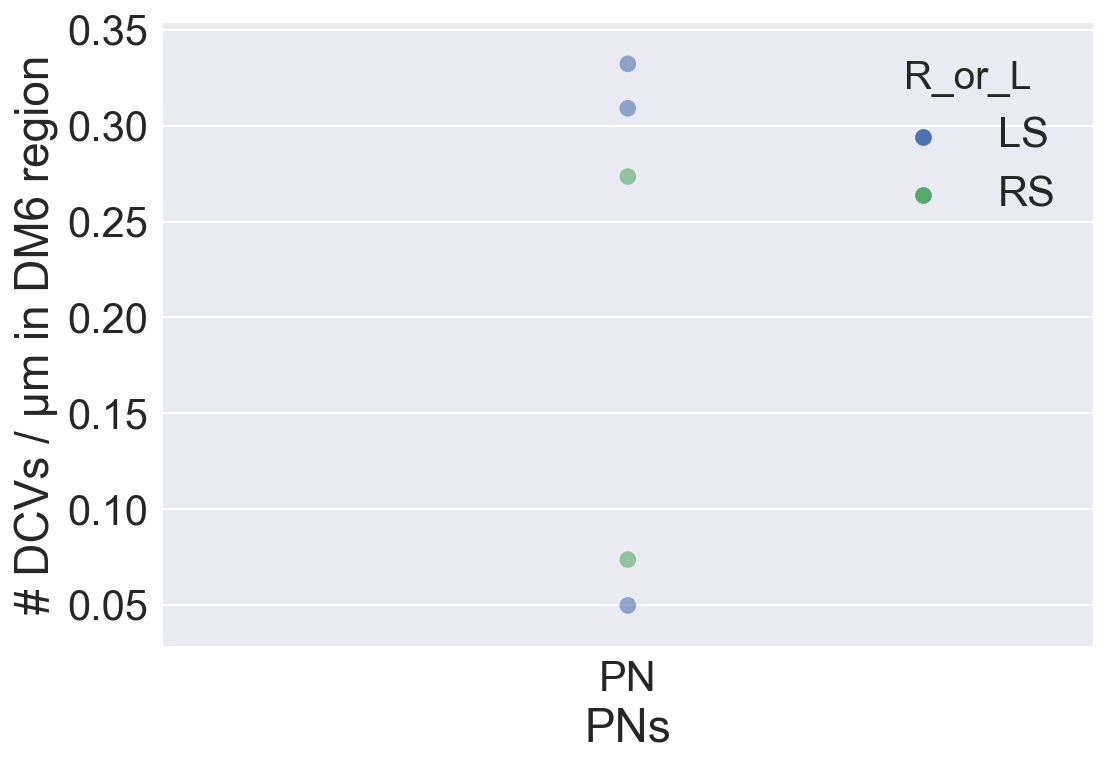

In [93]:
# Plot these values
sns.swarmplot(x = 'cell_type', y="DM6_DCV/DM6_length", hue = "R_or_L", data = DM6_PN_DCV_counts, alpha = .6, size = 8)
plt.ylabel('# DCVs / µm in DM6 region')
plt.xlabel('PNs')
# plt.ylim([0,3.5])
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV per um full cells.pdf')

/Users/hannah/git/LeeLabScripts/figures


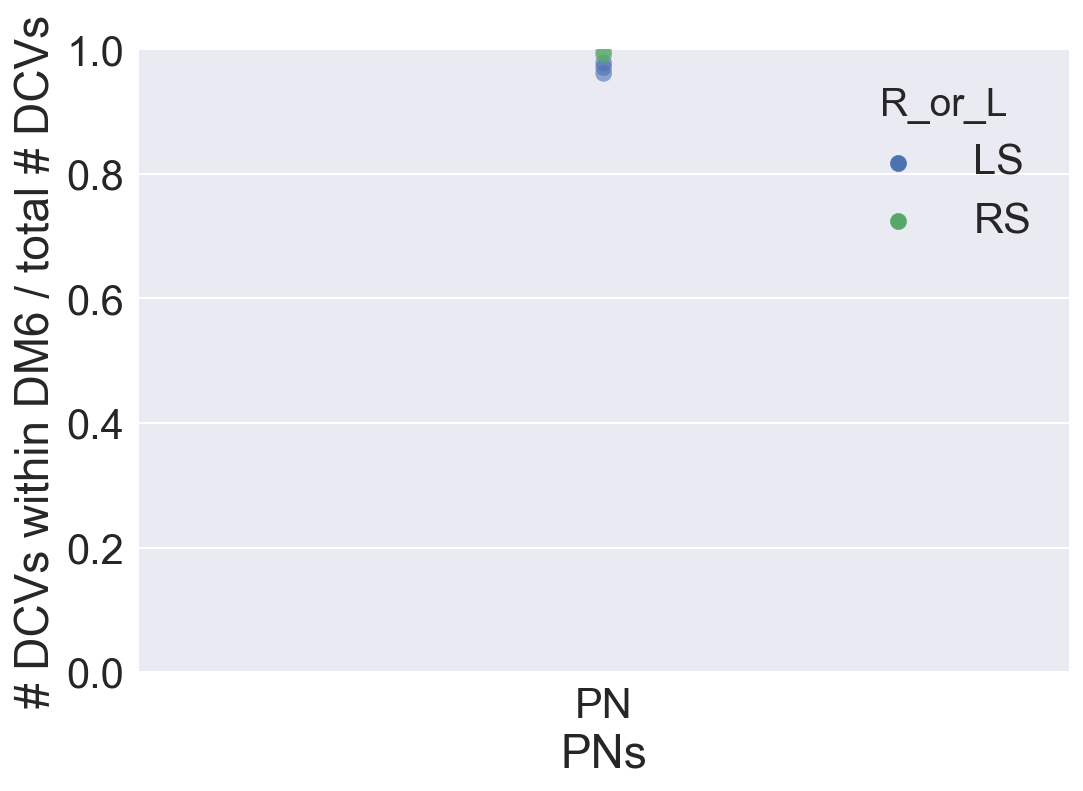

In [94]:
# Plot these values
sns.swarmplot(x = 'cell_type', y="prop_DCVs_within_DM6", hue = "R_or_L", data = DM6_PN_DCV_counts, alpha = .6, size = 8)
plt.ylabel('# DCVs within DM6 / total # DCVs')
plt.xlabel('PNs')
plt.ylim([0,1])
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV per um full cells.pdf')

In [95]:
# Let treenode df for part of ORNs in DM6
def DM6_treenode_df_for_ORNs(skel_ids, all_neurons, skdata):
    """Wrapper to get the treenodes within DM6 for PNs

       
    Parameters:
    -----------
    skel_ids :        list of skeleton_ids
    
    all_neurons :     list of all neurons used to generate skdata
    
    skdata :          skeleton data for neurons (from get_3D_skeleton())
    
    
    
    Returns:
    --------
    
    Pandas df with 'treenode_id', 'parent_id', 'creator_id', 'x', 'y', 'z', 'radius', 'confidence',
                    'type', 'has_synapses', 'skel_id'
    
    
    """
    
    # Initialize master df
    master_DM6_df = pd.DataFrame()
    
    for skeleton_id in skel_ids:

        # Get all tags and their associated treenode_ids for this skel_id
        index = all_neurons.index(skeleton_id)
        tags = skdata.ix[index].tags
        
        # Does PN have one or two dendrites (entry points into DM6)?
        # initialize dendrite starts
        left_axon_1 = []
        left_axon_2 = []
        right_axon_1 = []
        right_axon_2 = []
        
        # Left axon first
        
        # Has only one entry point
        if 'left axon' in tags:
            left_axon_1 = tags['left axon'][0]
            print('One left axon')
        
        # Has two entry points
        elif 'left axon 1' in tags:
            left_axon_1 = tags['left axon 1'][0]
            left_axon_2 = tags['left axon 2'][0]
            print('Two left axons')
            
        # Right axon now
        
        # there is a typo I have to correct for ORN3 (206984)
        if skeleton_id == '000':  # 206984
            print('We found ORN3')
            right_axon_1 = tags['right axon new'][0]
        
        # for all the other neurons
        else:
            # Has only one entry point
            if 'right axon' in tags:
                right_axon_1 = tags['right axon'][0]
                print('One right axon')
        
            # Has two entry points
            elif 'right axon 1' in tags:
                right_axon_1 = tags['right axon 1'][0]
                right_axon_2 = tags['right axon 2'][0]
                print('Two right axons')
            
        print(skeleton_id)
        print(left_axon_1)
        print(left_axon_2)
        print(right_axon_1)
        print(right_axon_2)
        print(index)

            
        # Get commissure treenode id (after cut, neuron fragment that has this is not DM6)
        commissure = tags['commissure'][0]
        
        
        # Left cutting
        
        left_prox1_df = pd.DataFrame()
        left_dist1_df = pd.DataFrame()
        
        
        # Cut neuron at dendrite start point
        left_dist1, left_prox1 = cut_neuron(skdata.ix[index], left_axon_1)
        
        # put in dataframe
        left_prox1_df = left_prox1.to_frame()
        left_dist1_df = left_dist1.to_frame()
        
        # Get nodes
        left_dist1_nodes = left_dist1_df.at['nodes', 0]
        left_prox1_nodes = left_prox1_df.at['nodes', 0]
        
        # put treenode_ids into list
        left_dist1_node_list = left_dist1_nodes['treenode_id'].tolist()
        left_prox1_node_list = left_prox1_nodes['treenode_id'].tolist()
        
        # Rename column
        left_prox1_df.rename(columns={0: skeleton_id + '_left1'}, inplace=True)
        left_dist1_df.rename(columns={0: skeleton_id + '_left1'}, inplace=True)
        
        # Check with part of neuron is DM6 (does not contain commissure)
        if commissure in left_dist1_node_list:    
            master_DM6_df = pd.concat([master_DM6_df, left_prox1_df], axis = 1)
        else:
            master_DM6_df = pd.concat([master_DM6_df, left_dist1_df], axis = 1)
            
        
        
        
        # if there are 2 entry points
        # if dendrite_2_start is not empty
        if left_axon_2:
            left_dist2, left_prox2 = cut_neuron(skdata.ix[index], left_axon_2)
            
            # put in dataframe
            left_prox2_df = left_prox2.to_frame()
            left_dist2_df = left_dist2.to_frame()
        
            # Get nodes
            left_dist2_nodes = left_dist2_df.at['nodes', 0]
            left_prox2_nodes = left_prox2_df.at['nodes', 0]
        
            # put treenode_ids into list
            left_dist2_node_list = left_dist2_nodes['treenode_id'].tolist()
            left_prox2_node_list = left_prox2_nodes['treenode_id'].tolist()
            
            # Rename column
            left_prox2_df.rename(columns={0: skeleton_id + '_left2'}, inplace=True)
            left_dist2_df.rename(columns={0: skeleton_id + '_left2'}, inplace=True)
        
            # Check with part of neuron is DM6 (does not contain commissure)
            if commissure in left_dist2_node_list:
                master_DM6_df = pd.concat([master_DM6_df, left_prox2_df], axis = 1)
            else:
                master_DM6_df = pd.concat([master_DM6_df, left_dist2_df], axis = 1)
                
                
        # Right cutting
        
        right_prox1_df = pd.DataFrame()
        right_dist1_df = pd.DataFrame()
        
        
        # Cut neuron at dendrite start point
        right_dist1, right_prox1 = cut_neuron(skdata.ix[index], right_axon_1)
        
        # put in dataframe
        right_prox1_df = right_prox1.to_frame()
        right_dist1_df = right_dist1.to_frame()
        
        # Get nodes
        right_dist1_nodes = right_dist1_df.at['nodes', 0]
        right_prox1_nodes = right_prox1_df.at['nodes', 0]
        
        # put treenode_ids into list
        right_dist1_node_list = right_dist1_nodes['treenode_id'].tolist()
        right_prox1_node_list = right_prox1_nodes['treenode_id'].tolist()
        
        # Rename column
        right_prox1_df.rename(columns={0: skeleton_id + '_right1'}, inplace=True)
        right_dist1_df.rename(columns={0: skeleton_id + '_right1'}, inplace=True)
        
        # Check with part of neuron is DM6 (does not contain soma)
        if commissure in right_dist1_node_list:    
            master_DM6_df = pd.concat([master_DM6_df, right_prox1_df], axis = 1)
        else:
            master_DM6_df = pd.concat([master_DM6_df, right_dist1_df], axis = 1)
            
        
        
        
        # if there are 2 entry points
        # if dendrite_2_start is not empty
        if right_axon_2:
            right_dist2, right_prox2 = cut_neuron(skdata.ix[index], right_axon_2)
            
            # put in dataframe
            right_prox2_df = right_prox2.to_frame()
            right_dist2_df = right_dist2.to_frame()
        
            # Get nodes
            right_dist2_nodes = right_dist2_df.at['nodes', 0]
            right_prox2_nodes = right_prox2_df.at['nodes', 0]
        
            # put treenode_ids into list
            right_dist2_node_list = right_dist2_nodes['treenode_id'].tolist()
            right_prox2_node_list = right_prox2_nodes['treenode_id'].tolist()
            
            # Rename column
            right_prox2_df.rename(columns={0: skeleton_id + '_right2'}, inplace=True)
            right_dist2_df.rename(columns={0: skeleton_id + '_right2'}, inplace=True)
        
            # Check with part of neuron is DM6 (does not contain soma)
            if commissure in right_dist2_node_list:
                master_DM6_df = pd.concat([master_DM6_df, right_prox2_df], axis = 1)
            else:
                master_DM6_df = pd.concat([master_DM6_df, right_dist2_df], axis = 1)
                
    return master_DM6_df

In [96]:
ORN_DM6_treenodes = DM6_treenode_df_for_ORNs(ORNs, all_neurons, skdata)
ORN_DM6_treenodes

2018-01-12 16:20:23,082 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:23,179 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...


One left axon
One right axon
75022
650950
[]
653547
[]
0


/Users/hannah/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

2018-01-12 16:20:23,676 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:23,678 - pymaid.morpho - INFO - Distal to cut node: 3465 nodes/235 synapses
INFO:pymaid.morpho:Distal to cut node: 3465 nodes/235 synapses
2018-01-12 16:20:23,680 - pymaid.morpho - INFO - Proximal to cut node: 627 nodes/72 synapses
INFO:pymaid.morpho:Proximal to cut node: 627 nodes/72 synapses
2018-01-12 16:20:23,685 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:23,705 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:24,146 - pymaid.morpho - 

Two left axons
One right axon
214902
3226226
3227115
3223979
[]
1


2018-01-12 16:20:24,667 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:24,669 - pymaid.morpho - INFO - Distal to cut node: 502 nodes/20 synapses
INFO:pymaid.morpho:Distal to cut node: 502 nodes/20 synapses
2018-01-12 16:20:24,670 - pymaid.morpho - INFO - Proximal to cut node: 3400 nodes/243 synapses
INFO:pymaid.morpho:Proximal to cut node: 3400 nodes/243 synapses
2018-01-12 16:20:24,675 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:24,695 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:25,129 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:25,131 - pymaid.morpho - INFO - Distal to cut node: 803 nodes/97 synapses
INFO:pymaid.morpho:Distal to cut node: 803 nodes/97 synapses
2018-01-12 16:20:25,132 - pymaid.morpho - INFO - Proximal to cut node: 3099 nodes/

One left axon
One right axon
206984
3064925
[]
3070193
[]
2


2018-01-12 16:20:26,113 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:26,115 - pymaid.morpho - INFO - Distal to cut node: 814 nodes/137 synapses
INFO:pymaid.morpho:Distal to cut node: 814 nodes/137 synapses
2018-01-12 16:20:26,117 - pymaid.morpho - INFO - Proximal to cut node: 2754 nodes/161 synapses
INFO:pymaid.morpho:Proximal to cut node: 2754 nodes/161 synapses
2018-01-12 16:20:26,122 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:26,141 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:26,594 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:26,595 - pymaid.morpho - INFO - Distal to cut node: 714 nodes/145 synapses
INFO:pymaid.morpho:Distal to cut node: 714 nodes/145 synapses
2018-01-12 16:20:26,597 - pymaid.morpho - INFO - Proximal to cut node: 2854 no

One left axon
One right axon
197072
2908435
[]
2906259
[]
3


2018-01-12 16:20:27,131 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:27,132 - pymaid.morpho - INFO - Distal to cut node: 1181 nodes/146 synapses
INFO:pymaid.morpho:Distal to cut node: 1181 nodes/146 synapses
2018-01-12 16:20:27,133 - pymaid.morpho - INFO - Proximal to cut node: 3279 nodes/90 synapses
INFO:pymaid.morpho:Proximal to cut node: 3279 nodes/90 synapses
2018-01-12 16:20:27,139 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:27,161 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:27,600 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:27,602 - pymaid.morpho - INFO - Distal to cut node: 931 nodes/90 synapses
INFO:pymaid.morpho:Distal to cut node: 931 nodes/90 synapses
2018-01-12 16:20:27,603 - pymaid.morpho - INFO - Proximal to cut node: 3529 node

One left axon
One right axon
146356
2064902
[]
2070339
[]
4


2018-01-12 16:20:28,124 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:28,125 - pymaid.morpho - INFO - Distal to cut node: 839 nodes/132 synapses
INFO:pymaid.morpho:Distal to cut node: 839 nodes/132 synapses
2018-01-12 16:20:28,126 - pymaid.morpho - INFO - Proximal to cut node: 3011 nodes/171 synapses
INFO:pymaid.morpho:Proximal to cut node: 3011 nodes/171 synapses
2018-01-12 16:20:28,131 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:28,151 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:28,589 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:28,590 - pymaid.morpho - INFO - Distal to cut node: 986 nodes/157 synapses
INFO:pymaid.morpho:Distal to cut node: 986 nodes/157 synapses
2018-01-12 16:20:28,592 - pymaid.morpho - INFO - Proximal to cut node: 2864 no

One left axon
One right axon
208985
3100430
[]
3103037
[]
5


2018-01-12 16:20:29,118 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:29,119 - pymaid.morpho - INFO - Distal to cut node: 3193 nodes/193 synapses
INFO:pymaid.morpho:Distal to cut node: 3193 nodes/193 synapses
2018-01-12 16:20:29,120 - pymaid.morpho - INFO - Proximal to cut node: 1075 nodes/82 synapses
INFO:pymaid.morpho:Proximal to cut node: 1075 nodes/82 synapses
2018-01-12 16:20:29,126 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:29,147 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:29,580 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:29,581 - pymaid.morpho - INFO - Distal to cut node: 1739 nodes/191 synapses
INFO:pymaid.morpho:Distal to cut node: 1739 nodes/191 synapses
2018-01-12 16:20:29,583 - pymaid.morpho - INFO - Proximal to cut node: 2529 

Two left axons
One right axon
142725
2012147
2011151
2016343
[]
6


2018-01-12 16:20:30,096 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:30,098 - pymaid.morpho - INFO - Distal to cut node: 570 nodes/99 synapses
INFO:pymaid.morpho:Distal to cut node: 570 nodes/99 synapses
2018-01-12 16:20:30,099 - pymaid.morpho - INFO - Proximal to cut node: 3195 nodes/168 synapses
INFO:pymaid.morpho:Proximal to cut node: 3195 nodes/168 synapses
2018-01-12 16:20:30,104 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:30,125 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:30,562 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:30,563 - pymaid.morpho - INFO - Distal to cut node: 285 nodes/24 synapses
INFO:pymaid.morpho:Distal to cut node: 285 nodes/24 synapses
2018-01-12 16:20:30,565 - pymaid.morpho - INFO - Proximal to cut node: 3480 nodes/

One left axon
One right axon
203583
3020058
[]
3025109
[]
7


2018-01-12 16:20:31,535 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:31,536 - pymaid.morpho - INFO - Distal to cut node: 897 nodes/102 synapses
INFO:pymaid.morpho:Distal to cut node: 897 nodes/102 synapses
2018-01-12 16:20:31,538 - pymaid.morpho - INFO - Proximal to cut node: 2872 nodes/98 synapses
INFO:pymaid.morpho:Proximal to cut node: 2872 nodes/98 synapses
2018-01-12 16:20:31,542 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:31,563 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:32,001 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:32,003 - pymaid.morpho - INFO - Distal to cut node: 948 nodes/92 synapses
INFO:pymaid.morpho:Distal to cut node: 948 nodes/92 synapses
2018-01-12 16:20:32,004 - pymaid.morpho - INFO - Proximal to cut node: 2821 nodes/

One left axon
One right axon
103373
1218914
[]
1223699
[]
8


2018-01-12 16:20:32,522 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:32,523 - pymaid.morpho - INFO - Distal to cut node: 1078 nodes/128 synapses
INFO:pymaid.morpho:Distal to cut node: 1078 nodes/128 synapses
2018-01-12 16:20:32,525 - pymaid.morpho - INFO - Proximal to cut node: 3071 nodes/114 synapses
INFO:pymaid.morpho:Proximal to cut node: 3071 nodes/114 synapses
2018-01-12 16:20:32,530 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:32,553 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:32,997 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:32,998 - pymaid.morpho - INFO - Distal to cut node: 1158 nodes/108 synapses
INFO:pymaid.morpho:Distal to cut node: 1158 nodes/108 synapses
2018-01-12 16:20:33,000 - pymaid.morpho - INFO - Proximal to cut node: 299

One left axon
One right axon
188110
2759189
[]
2764157
[]
9


2018-01-12 16:20:33,512 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:33,513 - pymaid.morpho - INFO - Distal to cut node: 1019 nodes/115 synapses
INFO:pymaid.morpho:Distal to cut node: 1019 nodes/115 synapses
2018-01-12 16:20:33,514 - pymaid.morpho - INFO - Proximal to cut node: 2836 nodes/103 synapses
INFO:pymaid.morpho:Proximal to cut node: 2836 nodes/103 synapses
2018-01-12 16:20:33,520 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:33,540 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:33,983 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:33,984 - pymaid.morpho - INFO - Distal to cut node: 856 nodes/100 synapses
INFO:pymaid.morpho:Distal to cut node: 856 nodes/100 synapses
2018-01-12 16:20:33,986 - pymaid.morpho - INFO - Proximal to cut node: 2999 

One left axon
One right axon
52598
255577
[]
260518
[]
10


2018-01-12 16:20:34,518 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:34,520 - pymaid.morpho - INFO - Distal to cut node: 3336 nodes/160 synapses
INFO:pymaid.morpho:Distal to cut node: 3336 nodes/160 synapses
2018-01-12 16:20:34,521 - pymaid.morpho - INFO - Proximal to cut node: 908 nodes/84 synapses
INFO:pymaid.morpho:Proximal to cut node: 908 nodes/84 synapses
2018-01-12 16:20:34,526 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:34,549 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:34,998 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:34,999 - pymaid.morpho - INFO - Distal to cut node: 1196 nodes/158 synapses
INFO:pymaid.morpho:Distal to cut node: 1196 nodes/158 synapses
2018-01-12 16:20:35,001 - pymaid.morpho - INFO - Proximal to cut node: 3048 no

One left axon
One right axon
91515
979685
[]
982444
[]
11


2018-01-12 16:20:35,536 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:35,537 - pymaid.morpho - INFO - Distal to cut node: 2780 nodes/185 synapses
INFO:pymaid.morpho:Distal to cut node: 2780 nodes/185 synapses
2018-01-12 16:20:35,539 - pymaid.morpho - INFO - Proximal to cut node: 1252 nodes/143 synapses
INFO:pymaid.morpho:Proximal to cut node: 1252 nodes/143 synapses
2018-01-12 16:20:35,544 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:35,565 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:36,011 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:36,012 - pymaid.morpho - INFO - Distal to cut node: 1330 nodes/180 synapses
INFO:pymaid.morpho:Distal to cut node: 1330 nodes/180 synapses
2018-01-12 16:20:36,014 - pymaid.morpho - INFO - Proximal to cut node: 270

One left axon
Two right axons
185052
2686325
[]
2691565
2693823
12


2018-01-12 16:20:36,520 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:36,522 - pymaid.morpho - INFO - Distal to cut node: 998 nodes/73 synapses
INFO:pymaid.morpho:Distal to cut node: 998 nodes/73 synapses
2018-01-12 16:20:36,523 - pymaid.morpho - INFO - Proximal to cut node: 2740 nodes/142 synapses
INFO:pymaid.morpho:Proximal to cut node: 2740 nodes/142 synapses
2018-01-12 16:20:36,528 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:36,547 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:36,983 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:36,985 - pymaid.morpho - INFO - Distal to cut node: 736 nodes/122 synapses
INFO:pymaid.morpho:Distal to cut node: 736 nodes/122 synapses
2018-01-12 16:20:36,986 - pymaid.morpho - INFO - Proximal to cut node: 3002 node

One left axon
One right axon
54588
295681
[]
301345
[]
13


2018-01-12 16:20:37,969 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:37,971 - pymaid.morpho - INFO - Distal to cut node: 1081 nodes/172 synapses
INFO:pymaid.morpho:Distal to cut node: 1081 nodes/172 synapses
2018-01-12 16:20:37,972 - pymaid.morpho - INFO - Proximal to cut node: 2907 nodes/111 synapses
INFO:pymaid.morpho:Proximal to cut node: 2907 nodes/111 synapses
2018-01-12 16:20:37,977 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:37,998 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:38,438 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:38,440 - pymaid.morpho - INFO - Distal to cut node: 988 nodes/102 synapses
INFO:pymaid.morpho:Distal to cut node: 988 nodes/102 synapses
2018-01-12 16:20:38,441 - pymaid.morpho - INFO - Proximal to cut node: 3000 

One left axon
One right axon
168431
2411977
[]
2414487
[]
14


2018-01-12 16:20:38,968 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:38,970 - pymaid.morpho - INFO - Distal to cut node: 2881 nodes/124 synapses
INFO:pymaid.morpho:Distal to cut node: 2881 nodes/124 synapses
2018-01-12 16:20:38,971 - pymaid.morpho - INFO - Proximal to cut node: 1020 nodes/78 synapses
INFO:pymaid.morpho:Proximal to cut node: 1020 nodes/78 synapses
2018-01-12 16:20:38,976 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:38,996 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:39,442 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:39,443 - pymaid.morpho - INFO - Distal to cut node: 1476 nodes/121 synapses
INFO:pymaid.morpho:Distal to cut node: 1476 nodes/121 synapses
2018-01-12 16:20:39,445 - pymaid.morpho - INFO - Proximal to cut node: 2425 

Two left axons
One right axon
130007
1757311
1755111
1761793
[]
15


2018-01-12 16:20:39,971 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:39,972 - pymaid.morpho - INFO - Distal to cut node: 1125 nodes/30 synapses
INFO:pymaid.morpho:Distal to cut node: 1125 nodes/30 synapses
2018-01-12 16:20:39,973 - pymaid.morpho - INFO - Proximal to cut node: 3306 nodes/245 synapses
INFO:pymaid.morpho:Proximal to cut node: 3306 nodes/245 synapses
2018-01-12 16:20:39,978 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:39,999 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:40,442 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:40,444 - pymaid.morpho - INFO - Distal to cut node: 871 nodes/122 synapses
INFO:pymaid.morpho:Distal to cut node: 871 nodes/122 synapses
2018-01-12 16:20:40,445 - pymaid.morpho - INFO - Proximal to cut node: 3560 no

One left axon
Two right axons
77885
714663
[]
711586
711949
16


2018-01-12 16:20:41,453 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:41,455 - pymaid.morpho - INFO - Distal to cut node: 955 nodes/108 synapses
INFO:pymaid.morpho:Distal to cut node: 955 nodes/108 synapses
2018-01-12 16:20:41,456 - pymaid.morpho - INFO - Proximal to cut node: 3159 nodes/239 synapses
INFO:pymaid.morpho:Proximal to cut node: 3159 nodes/239 synapses
2018-01-12 16:20:41,461 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:41,482 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:41,926 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:41,927 - pymaid.morpho - INFO - Distal to cut node: 182 nodes/14 synapses
INFO:pymaid.morpho:Distal to cut node: 182 nodes/14 synapses
2018-01-12 16:20:41,929 - pymaid.morpho - INFO - Proximal to cut node: 3932 node

One left axon
Two right axons
120789
1569580
[]
1574847
1574712
17


2018-01-12 16:20:42,935 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:42,936 - pymaid.morpho - INFO - Distal to cut node: 1193 nodes/113 synapses
INFO:pymaid.morpho:Distal to cut node: 1193 nodes/113 synapses
2018-01-12 16:20:42,938 - pymaid.morpho - INFO - Proximal to cut node: 2871 nodes/116 synapses
INFO:pymaid.morpho:Proximal to cut node: 2871 nodes/116 synapses
2018-01-12 16:20:42,943 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:42,965 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:43,409 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:43,410 - pymaid.morpho - INFO - Distal to cut node: 1010 nodes/109 synapses
INFO:pymaid.morpho:Distal to cut node: 1010 nodes/109 synapses
2018-01-12 16:20:43,412 - pymaid.morpho - INFO - Proximal to cut node: 305

One left axon
One right axon
157043
2223150
[]
2225518
[]
18


2018-01-12 16:20:44,393 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:44,394 - pymaid.morpho - INFO - Distal to cut node: 2797 nodes/160 synapses
INFO:pymaid.morpho:Distal to cut node: 2797 nodes/160 synapses
2018-01-12 16:20:44,395 - pymaid.morpho - INFO - Proximal to cut node: 724 nodes/71 synapses
INFO:pymaid.morpho:Proximal to cut node: 724 nodes/71 synapses
2018-01-12 16:20:44,400 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:44,420 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:44,865 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:44,867 - pymaid.morpho - INFO - Distal to cut node: 1470 nodes/156 synapses
INFO:pymaid.morpho:Distal to cut node: 1470 nodes/156 synapses
2018-01-12 16:20:44,868 - pymaid.morpho - INFO - Proximal to cut node: 2051 no

One left axon
Two right axons
173737
2500559
[]
2504131
2505096
19


2018-01-12 16:20:45,386 - pymaid.morpho - INFO - Cutting finished in 1s
INFO:pymaid.morpho:Cutting finished in 1s
2018-01-12 16:20:45,388 - pymaid.morpho - INFO - Distal to cut node: 2923 nodes/109 synapses
INFO:pymaid.morpho:Distal to cut node: 2923 nodes/109 synapses
2018-01-12 16:20:45,390 - pymaid.morpho - INFO - Proximal to cut node: 1037 nodes/88 synapses
INFO:pymaid.morpho:Proximal to cut node: 1037 nodes/88 synapses
2018-01-12 16:20:45,395 - pymaid.morpho - INFO - Preparing to cut neuron...
INFO:pymaid.morpho:Preparing to cut neuron...
2018-01-12 16:20:45,416 - pymaid.morpho - INFO - Cutting neuron...
INFO:pymaid.morpho:Cutting neuron...
2018-01-12 16:20:45,857 - pymaid.morpho - INFO - Cutting finished in 0s
INFO:pymaid.morpho:Cutting finished in 0s
2018-01-12 16:20:45,858 - pymaid.morpho - INFO - Distal to cut node: 430 nodes/40 synapses
INFO:pymaid.morpho:Distal to cut node: 430 nodes/40 synapses
2018-01-12 16:20:45,860 - pymaid.morpho - INFO - Proximal to cut node: 3530 node

,75022_left1,75022_right1,214902_left1,214902_left2,214902_right1,206984_left1,206984_right1,197072_left1,197072_right1,146356_left1,...,77885_right1,77885_right2,120789_left1,120789_right1,120789_right2,157043_left1,157043_right1,173737_left1,173737_right1,173737_right2
neuron_name,DM6 ORN 1_prox,DM6 ORN 1_dist,DM6 ORN 2_dist,DM6 ORN 2_dist,DM6 ORN 2_dist,DM6 ORN 3_dist,DM6 ORN 3_dist,DM6 ORN 4_dist,DM6 ORN 4_dist,DM6 ORN 5_dist,...,DM6 ORN 17_dist,DM6 ORN 17_dist,DM6 ORN 18_dist,DM6 ORN 18_dist,DM6 ORN 18_dist,DM6 ORN 19_prox,DM6 ORN 19_dist,DM6 ORN 21_prox,DM6 ORN 21_dist,DM6 ORN 21_dist
skeleton_id,75022,75022,214902,214902,214902,206984,206984,197072,197072,146356,...,77885,77885,120789,120789,120789,157043,157043,173737,173737,173737
nodes,treenode_id parent_id creator_id x ...,treenode_id parent_id creator_id x...,treenode_id parent_id creator_id x ...,treenode_id parent_id creator_id x ...,treenode_id parent_id creator_id x...,treenode_id parent_id creator_id x ...,treenode_id parent_id creator_id x ...,treenode_id parent_id creator_id x...,treenode_id parent_id creator_id x ...,treenode_id parent_id creator_id x ...,...,treenode_id parent_id creator_id x ...,treenode_id parent_id creator_id x...,treenode_id parent_id creator_id x...,treenode_id parent_id creator_id x...,treenode_id parent_id creator_id x ...,treenode_id parent_id creator_id x ...,treenode_id parent_id creator_id x...,treenode_id parent_id creator_id x...,treenode_id parent_id creator_id x ...,treenode_id parent_id creator_id x ...
connectors,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...,index treenode_id connector_id relation ...
tags,"{'left axon': [650950], 'PS: maybe syn S': [65...","{'left axon': [650950], 'PS: maybe syn S': [65...",{'WT: The following sections are exceedingly u...,{'WT: The following sections are exceedingly u...,{'WT: The following sections are exceedingly u...,"{'left axon': [3064925], 'PS: syn E': [3065244...","{'left axon': [3064925], 'PS: syn E': [3065244...","{'left axon': [2908435], 'p197072': [2911131],...","{'left axon': [2908435], 'p197072': [2911131],...",{'RC: probably but not 100% confidence': [2072...,...,"{'left axon': [714663], 'PS: maybe syn E': [71...","{'left axon': [714663], 'PS: maybe syn E': [71...","{'left axon': [1569580], 'right axon 2': [1574...","{'left axon': [1569580], 'right axon 2': [1574...","{'left axon': [1569580], 'right axon 2': [1574...","{'PS: obl syn?': [2226064], 'left axon': [2223...","{'PS: obl syn?': [2226064], 'left axon': [2223...","{'left axon': [2500559], 'PS: syn NW?': [25046...","{'left axon': [2500559], 'PS: syn NW?': [25046...","{'left axon': [2500559], 'PS: syn NW?': [25046..."


In [97]:
# get cable length for each ORN DM6 (L & R) region

# Get list of PN skel_ids
DM6_ORN_axon_fragments = list(ORN_DM6_treenodes.columns.values)

# Initiate list for PN cable lengths
cable_lengths = []

for fragment in DM6_ORN_axon_fragments:
    ORN_df = ORN_DM6_treenodes[fragment]
    
    print(fragment)
    
    # Get cable length
    cable_length = calc_cable(ORN_df,
                          remote_instance = Myinstance, 
                          project_id = 3)

    # Add cable length to list
    cable_lengths.append(cable_length)
    
    
# Put PN skel_ids and cable lengths into dict
ORN_DM6_cable_lengths = dict(zip(DM6_ORN_axon_fragments, cable_lengths))

# Put ORN2 left fragments together (214902)
ORN_DM6_cable_lengths['214902_left1'] = ORN_DM6_cable_lengths['214902_left1'] + ORN_DM6_cable_lengths['214902_left2']
ORN_DM6_cable_lengths.pop('214902_left2')

# Put ORN7 left fragments together (142725)
ORN_DM6_cable_lengths['142725_left1'] = ORN_DM6_cable_lengths['142725_left1'] + ORN_DM6_cable_lengths['142725_left2']
ORN_DM6_cable_lengths.pop('142725_left2')

# Put ORN13 left fragments together (185052)
ORN_DM6_cable_lengths['185052_right1'] = ORN_DM6_cable_lengths['185052_right1'] + ORN_DM6_cable_lengths['185052_right2']
ORN_DM6_cable_lengths.pop('185052_right2')

# Put ORN16 left fragments together (130007)
ORN_DM6_cable_lengths['130007_left1'] = ORN_DM6_cable_lengths['130007_left1'] + ORN_DM6_cable_lengths['130007_left2']
ORN_DM6_cable_lengths.pop('130007_left2')

# Put ORN17 left fragments together (77885)
ORN_DM6_cable_lengths['77885_right1'] = ORN_DM6_cable_lengths['77885_right1'] + ORN_DM6_cable_lengths['77885_right2']
ORN_DM6_cable_lengths.pop('77885_right2')

# Put ORN18 left fragments together (120789)
ORN_DM6_cable_lengths['120789_right1'] = ORN_DM6_cable_lengths['120789_right1'] + ORN_DM6_cable_lengths['120789_right2']
ORN_DM6_cable_lengths.pop('120789_right2')

# Put ORN21 left fragments together (173737)
ORN_DM6_cable_lengths['173737_right1'] = ORN_DM6_cable_lengths['173737_right1'] + ORN_DM6_cable_lengths['173737_right2']
ORN_DM6_cable_lengths.pop('173737_right2')

ORN_DM6_cable_lengths

75022_left1
75022_right1
214902_left1
214902_left2
214902_right1
206984_left1
206984_right1
197072_left1
197072_right1
146356_left1
146356_right1
208985_left1
208985_right1
142725_left1
142725_left2
142725_right1
203583_left1
203583_right1
103373_left1
103373_right1
188110_left1
188110_right1
52598_left1
52598_right1
91515_left1
91515_right1
185052_left1
185052_right1
185052_right2
54588_left1
54588_right1
168431_left1
168431_right1
130007_left1
130007_left2
130007_right1
77885_left1
77885_right1
77885_right2
120789_left1
120789_right1
120789_right2
157043_left1
157043_right1
173737_left1
173737_right1
173737_right2


{'103373_left1': 132.76369178645362,
 '103373_right1': 151.5595517213183,
 '120789_left1': 145.3010182789417,
 '120789_right1': 147.9510633270637,
 '130007_left1': 263.7136512315178,
 '130007_right1': 125.81901191539968,
 '142725_left1': 116.71189392874652,
 '142725_right1': 137.55568255696383,
 '146356_left1': 115.24490768496577,
 '146356_right1': 140.06377890217053,
 '157043_left1': 88.89372296272978,
 '157043_right1': 188.95314153765884,
 '168431_left1': 115.19234870829574,
 '168431_right1': 212.19899707410823,
 '173737_left1': 140.6330016882759,
 '173737_right1': 117.51537381649855,
 '185052_left1': 133.17179699058136,
 '185052_right1': 106.39145186314373,
 '188110_left1': 139.94047054227318,
 '188110_right1': 110.0119891257963,
 '197072_left1': 140.72098447947334,
 '197072_right1': 117.18203568505905,
 '203583_left1': 120.69243831826057,
 '203583_right1': 144.2096270185429,
 '206984_left1': 107.94067969586217,
 '206984_right1': 107.98011483126396,
 '208985_left1': 135.347264950546

In [98]:
# Split these cable lengths into two dicts (one for left and right DM6s)
left_ORN_DM6_cable_lengths = {}
right_ORN_DM6_cable_lengths = {}

ORN_DM6_names = list(ORN_DM6_cable_lengths.keys())

for name in ORN_DM6_names:
    if 'right' in name:
        right_ORN_DM6_cable_lengths[name] = ORN_DM6_cable_lengths[name]
    elif 'left' in name:
        left_ORN_DM6_cable_lengths[name] = ORN_DM6_cable_lengths[name]

In [99]:
# Get number of DCVs for each ORN DM6 region
all_ORN_DM6_DCVs = pd.DataFrame()

DM6_ORN_num_DCVs = {}

# Get list of all ORN DM6 fragments
ORN_DM6_fragments = list(ORN_DM6_cable_lengths.keys())
ORN_DM6_fragments.append('142725_left2')
ORN_DM6_fragments.append('214902_left2')
ORN_DM6_fragments.append('185052_right2')
ORN_DM6_fragments.append('130007_left2')
ORN_DM6_fragments.append('77885_right2')
ORN_DM6_fragments.append('120789_right2')
ORN_DM6_fragments.append('173737_right2')

# First get DCVs within DM6 for each neuron
for DM6_fragment in ORN_DM6_fragments:
    these_DM6 = ORN_DM6_treenodes[DM6_fragment]
    these_DM6_df = these_DM6.to_frame()
    
    # Get list of treenodes in the DM6 region
    treenodes = these_DM6_df.at['nodes', DM6_fragment]
    treenode_list = treenodes['treenode_id'].tolist()
    
    # Get skel_id for this DM6 fragment - it's the numbers before the _ in the fragment name 
    skel_id = DM6_fragment.split('_')[0] 
    
    this_skel_id_DCVs = df.loc[df['skeleton_id'] == int(skel_id)].copy()

    # Only get DCVs that are connected to treenodes in DM6 region
    this_skel_id_DCVs_DM6_only = this_skel_id_DCVs[this_skel_id_DCVs['treenode_id'].isin(treenode_list)]
    
    # Count number of DCVs
    num_DCVs = this_skel_id_DCVs_DM6_only.shape[0]
    
    DM6_ORN_num_DCVs[DM6_fragment] = num_DCVs

    # Add to master list
    all_ORN_DM6_DCVs = all_DM6_DCVs.append(this_skel_id_DCVs_DM6_only)
    all_ORN_DM6_DCVs.reset_index(drop = True, inplace = True)

# Put ORN2 left fragments together (214902)
DM6_ORN_num_DCVs['214902_left1'] = DM6_ORN_num_DCVs['214902_left1'] + DM6_ORN_num_DCVs['214902_left2']
DM6_ORN_num_DCVs.pop('214902_left2')

# Put ORN7 left fragments together (142725)
DM6_ORN_num_DCVs['142725_left1'] = DM6_ORN_num_DCVs['142725_left1'] + DM6_ORN_num_DCVs['142725_left2']
DM6_ORN_num_DCVs.pop('142725_left2')

# Put ORN13 left fragments together (185052)
DM6_ORN_num_DCVs['185052_right1'] = DM6_ORN_num_DCVs['185052_right1'] + DM6_ORN_num_DCVs['185052_right2']
DM6_ORN_num_DCVs.pop('185052_right2')

# Put ORN16 left fragments together (130007)
DM6_ORN_num_DCVs['130007_left1'] = DM6_ORN_num_DCVs['130007_left1'] + DM6_ORN_num_DCVs['130007_left2']
DM6_ORN_num_DCVs.pop('130007_left2')

# Put ORN17 left fragments together (77885)
DM6_ORN_num_DCVs['77885_right1'] = DM6_ORN_num_DCVs['77885_right1'] + DM6_ORN_num_DCVs['77885_right2']
DM6_ORN_num_DCVs.pop('77885_right2')

print(DM6_ORN_num_DCVs['120789_left1'])
print(DM6_ORN_num_DCVs['120789_right1'])
print(DM6_ORN_num_DCVs['120789_right2'])
# Put ORN18 left fragments together (120789)
DM6_ORN_num_DCVs['120789_right1'] = DM6_ORN_num_DCVs['120789_right1'] + DM6_ORN_num_DCVs['120789_right2']
DM6_ORN_num_DCVs.pop('120789_right2')

# Put ORN21 left fragments together (173737)
DM6_ORN_num_DCVs['173737_right1'] = DM6_ORN_num_DCVs['173737_right1'] + DM6_ORN_num_DCVs['173737_right2']
DM6_ORN_num_DCVs.pop('173737_right2')

DM6_ORN_num_DCVs

49
37
1


{'103373_left1': 44,
 '103373_right1': 43,
 '120789_left1': 49,
 '120789_right1': 38,
 '130007_left1': 70,
 '130007_right1': 50,
 '142725_left1': 50,
 '142725_right1': 55,
 '146356_left1': 66,
 '146356_right1': 73,
 '157043_left1': 24,
 '157043_right1': 59,
 '168431_left1': 22,
 '168431_right1': 38,
 '173737_left1': 19,
 '173737_right1': 28,
 '185052_left1': 22,
 '185052_right1': 57,
 '188110_left1': 38,
 '188110_right1': 29,
 '197072_left1': 67,
 '197072_right1': 32,
 '203583_left1': 17,
 '203583_right1': 21,
 '206984_left1': 56,
 '206984_right1': 86,
 '208985_left1': 25,
 '208985_right1': 77,
 '214902_left1': 47,
 '214902_right1': 71,
 '52598_left1': 28,
 '52598_right1': 65,
 '54588_left1': 76,
 '54588_right1': 32,
 '75022_left1': 32,
 '75022_right1': 107,
 '77885_left1': 45,
 '77885_right1': 110,
 '91515_left1': 61,
 '91515_right1': 70}

In [100]:
# Split these cable lengths into two dicts (one for left and right DM6s)
left_DM6_ORN_num_DCVs = {}
right_DM6_ORN_num_DCVs = {}

ORN_DM6_names = list(DM6_ORN_num_DCVs.keys())

for name in ORN_DM6_names:
    if 'right' in name:
        right_DM6_ORN_num_DCVs[name] = DM6_ORN_num_DCVs[name]
    elif 'left' in name:
        left_DM6_ORN_num_DCVs[name] = DM6_ORN_num_DCVs[name]

In [101]:
# Get total number of DCVs in each (full) ORN
total_number_DCVs_ORN = {}

for skel_id in ORNs:
    total_number_DCVs_ORN[str(skel_id)] = DCV_counts_dict[int(skel_id)]
    
total_number_DCVs_ORN

{'103373': 88,
 '120789': 90,
 '130007': 123,
 '142725': 117,
 '146356': 149,
 '157043': 87,
 '168431': 61,
 '173737': 48,
 '185052': 89,
 '188110': 70,
 '197072': 99,
 '203583': 44,
 '206984': 158,
 '208985': 104,
 '214902': 125,
 '52598': 94,
 '54588': 115,
 '75022': 146,
 '77885': 156,
 '91515': 136}

In [102]:
# Make dictionary specifying R or L side of ORNs (which side they enter)
R_or_L_ORN = {'75022': 'R', '214902': 'L', '206984': 'L', '197072': 'L', '146356': 'R', '208985': 'R',
             '142725': 'L', '203583': 'L', '103373': 'L', '188110': 'L', '52598': 'R',
             '91515': 'R', '185052': 'R', '54588': 'L', '168431': 'R', '130007': 'L',
             '77885': 'R', '120789': 'R', '157043': 'R', '173737': 'R'}

In [103]:
R_or_L_ORN

{'103373': 'L',
 '120789': 'R',
 '130007': 'L',
 '142725': 'L',
 '146356': 'R',
 '157043': 'R',
 '168431': 'R',
 '173737': 'R',
 '185052': 'R',
 '188110': 'L',
 '197072': 'L',
 '203583': 'L',
 '206984': 'L',
 '208985': 'R',
 '214902': 'L',
 '52598': 'R',
 '54588': 'L',
 '75022': 'R',
 '77885': 'R',
 '91515': 'R'}

In [104]:
none_list = ['None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
            'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']

DM6_ORN_DCV_counts = pd.DataFrame(
    {'skel_id': none_list,
     'num_DCVs_in_LEFT_DM6_part': none_list,
     'num_DCVs_in_RIGHT_DM6_part': none_list,
     'num_DCVs_in_full_neuron': none_list,
     'DM6_cable_length_um_LEFT': none_list,
     'DM6_cable_length_um_RIGHT': none_list,
     'R_or_L': none_list,
     'cell_type': 'ORN'
    })

# Fill the df
for index, skel_id in enumerate(ORNs): 
    DM6_ORN_DCV_counts.at[index, 'skel_id'] = skel_id
    DM6_ORN_DCV_counts.at[index, 'num_DCVs_in_LEFT_DM6_part'] = DM6_ORN_num_DCVs[skel_id + '_left1']
    DM6_ORN_DCV_counts.at[index, 'num_DCVs_in_RIGHT_DM6_part'] = DM6_ORN_num_DCVs[skel_id + '_right1']
    DM6_ORN_DCV_counts.at[index, 'num_DCVs_in_full_neuron'] = total_number_DCVs_ORN[skel_id]
    DM6_ORN_DCV_counts.at[index, 'DM6_cable_length_um_LEFT'] = ORN_DM6_cable_lengths[skel_id + '_left1']
    DM6_ORN_DCV_counts.at[index, 'DM6_cable_length_um_RIGHT'] = ORN_DM6_cable_lengths[skel_id + '_right1']
    DM6_ORN_DCV_counts.at[index, 'R_or_L'] = R_or_L_ORN[skel_id]
    
# Change datatypes
DM6_ORN_DCV_counts['DM6_cable_length_um_LEFT'] = DM6_ORN_DCV_counts.DM6_cable_length_um_LEFT.astype(float)
DM6_ORN_DCV_counts['DM6_cable_length_um_RIGHT'] = DM6_ORN_DCV_counts.DM6_cable_length_um_RIGHT.astype(float)
DM6_ORN_DCV_counts['num_DCVs_in_LEFT_DM6_part'] = DM6_ORN_DCV_counts.num_DCVs_in_LEFT_DM6_part.astype(int)
DM6_ORN_DCV_counts['num_DCVs_in_RIGHT_DM6_part'] = DM6_ORN_DCV_counts.num_DCVs_in_RIGHT_DM6_part.astype(int)
DM6_ORN_DCV_counts['num_DCVs_in_full_neuron'] = DM6_ORN_DCV_counts.num_DCVs_in_full_neuron.astype(int)
DM6_ORN_DCV_counts['skel_id'] = DM6_ORN_DCV_counts.skel_id.astype(int)
    
# Get number of LEFT DCVs/DM6 neuron length
DM6_ORN_DCV_counts['LEFT_DM6_DCV/DM6_length'] = DM6_ORN_DCV_counts['num_DCVs_in_LEFT_DM6_part'] / DM6_ORN_DCV_counts['DM6_cable_length_um_LEFT']

# Get number of RIGHT DCVs/DM6 neuron length
DM6_ORN_DCV_counts['RIGHT_DM6_DCV/DM6_length'] = DM6_ORN_DCV_counts['num_DCVs_in_RIGHT_DM6_part'] / DM6_ORN_DCV_counts['DM6_cable_length_um_RIGHT']

# Get number of RIGHT & LEFT DCVs/DM6 neuron length
DM6_ORN_DCV_counts['BOTH_L&R_DM6_DCV/DM6_length'] = (DM6_ORN_DCV_counts['num_DCVs_in_RIGHT_DM6_part'] + DM6_ORN_DCV_counts['num_DCVs_in_LEFT_DM6_part']) / DM6_ORN_DCV_counts['DM6_cable_length_um_RIGHT']

# Get number prop of DCVs within LEFT DM6
DM6_ORN_DCV_counts['prop_DCVs_within_LEFT_DM6'] = DM6_ORN_DCV_counts['num_DCVs_in_LEFT_DM6_part'] / DM6_ORN_DCV_counts['num_DCVs_in_full_neuron']

# Get number prop of DCVs within RIGHT DM6
DM6_ORN_DCV_counts['prop_DCVs_within_RIGHT_DM6'] = DM6_ORN_DCV_counts['num_DCVs_in_RIGHT_DM6_part'] / DM6_ORN_DCV_counts['num_DCVs_in_full_neuron']

# Get number prop of DCVs within BOTH DM6
DM6_ORN_DCV_counts['prop_DCVs_within_BOTH_DM6'] = (DM6_ORN_DCV_counts['num_DCVs_in_RIGHT_DM6_part'] + DM6_ORN_DCV_counts['num_DCVs_in_LEFT_DM6_part']) / DM6_ORN_DCV_counts['num_DCVs_in_full_neuron']

# Get pathlength in BOTH DM6
DM6_ORN_DCV_counts['pathlength_in_BOTH_DM6s'] = DM6_ORN_DCV_counts['DM6_cable_length_um_LEFT'] + DM6_ORN_DCV_counts['DM6_cable_length_um_RIGHT']


# DM6_ORN_DCV_counts['check'] = DM6_ORN_DCV_counts['num_DCVs_in_full_neuron'] - (DM6_ORN_DCV_counts['num_DCVs_in_LEFT_DM6_part'] + DM6_ORN_DCV_counts['num_DCVs_in_RIGHT_DM6_part'])

DM6_ORN_DCV_counts

,DM6_cable_length_um_LEFT,DM6_cable_length_um_RIGHT,R_or_L,cell_type,num_DCVs_in_LEFT_DM6_part,num_DCVs_in_RIGHT_DM6_part,num_DCVs_in_full_neuron,skel_id,LEFT_DM6_DCV/DM6_length,RIGHT_DM6_DCV/DM6_length,BOTH_L&R_DM6_DCV/DM6_length,prop_DCVs_within_LEFT_DM6,prop_DCVs_within_RIGHT_DM6,prop_DCVs_within_BOTH_DM6,pathlength_in_BOTH_DM6s
0,78.181137,265.874938,R,ORN,32,107,146,75022,0.409306,0.402445,0.522802,0.219178,0.732877,0.952055,344.056075
1,193.252726,130.260717,L,ORN,47,71,125,214902,0.243205,0.545061,0.905876,0.376000,0.568000,0.944000,323.513443
2,107.940680,107.980115,L,ORN,56,86,158,206984,0.518803,0.796443,1.315057,0.354430,0.544304,0.898734,215.920795
3,140.720984,117.182036,L,ORN,67,32,99,197072,0.476119,0.273079,0.844839,0.676768,0.323232,1.000000,257.903020
4,115.244908,140.063779,R,ORN,66,73,149,146356,0.572693,0.521191,0.992405,0.442953,0.489933,0.932886,255.308687
5,135.347265,231.038592,R,ORN,25,77,104,208985,0.184710,0.333278,0.441485,0.240385,0.740385,0.980769,366.385857
6,116.711894,137.555683,L,ORN,50,55,117,142725,0.428405,0.399838,0.763327,0.427350,0.470085,0.897436,254.267576
7,120.692438,144.209627,L,ORN,17,21,44,203583,0.140854,0.145621,0.263505,0.386364,0.477273,0.863636,264.902065
8,132.763692,151.559552,L,ORN,44,43,88,103373,0.331416,0.283717,0.574032,0.500000,0.488636,0.988636,284.323244
9,139.940471,110.011989,L,ORN,38,29,70,188110,0.271544,0.263608,0.609025,0.542857,0.414286,0.957143,249.952460


In [105]:
right = DM6_ORN_DCV_counts[DM6_ORN_DCV_counts['R_or_L'] == 'R']

left = DM6_ORN_DCV_counts[DM6_ORN_DCV_counts['R_or_L'] == 'L']
left

,DM6_cable_length_um_LEFT,DM6_cable_length_um_RIGHT,R_or_L,cell_type,num_DCVs_in_LEFT_DM6_part,num_DCVs_in_RIGHT_DM6_part,num_DCVs_in_full_neuron,skel_id,LEFT_DM6_DCV/DM6_length,RIGHT_DM6_DCV/DM6_length,BOTH_L&R_DM6_DCV/DM6_length,prop_DCVs_within_LEFT_DM6,prop_DCVs_within_RIGHT_DM6,prop_DCVs_within_BOTH_DM6,pathlength_in_BOTH_DM6s
1,193.252726,130.260717,L,ORN,47,71,125,214902,0.243205,0.545061,0.905876,0.376000,0.568000,0.944000,323.513443
2,107.940680,107.980115,L,ORN,56,86,158,206984,0.518803,0.796443,1.315057,0.354430,0.544304,0.898734,215.920795
3,140.720984,117.182036,L,ORN,67,32,99,197072,0.476119,0.273079,0.844839,0.676768,0.323232,1.000000,257.903020
6,116.711894,137.555683,L,ORN,50,55,117,142725,0.428405,0.399838,0.763327,0.427350,0.470085,0.897436,254.267576
7,120.692438,144.209627,L,ORN,17,21,44,203583,0.140854,0.145621,0.263505,0.386364,0.477273,0.863636,264.902065
8,132.763692,151.559552,L,ORN,44,43,88,103373,0.331416,0.283717,0.574032,0.500000,0.488636,0.988636,284.323244
9,139.940471,110.011989,L,ORN,38,29,70,188110,0.271544,0.263608,0.609025,0.542857,0.414286,0.957143,249.952460
13,140.450637,120.634970,L,ORN,76,32,115,54588,0.541115,0.265263,0.895263,0.660870,0.278261,0.939130,261.085607
15,263.713651,125.819012,L,ORN,70,50,123,130007,0.265439,0.397396,0.953751,0.569106,0.406504,0.975610,389.532663


/Users/hannah/git/LeeLabScripts/figures


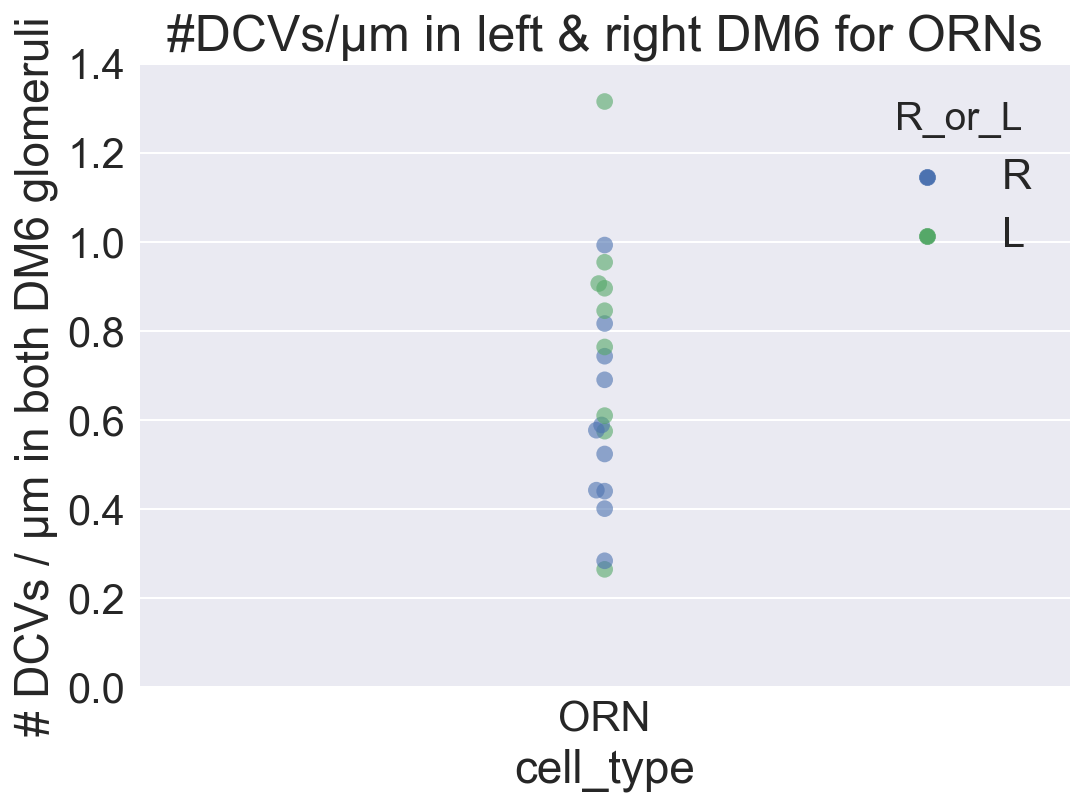

In [106]:
# Plot prop of DCVs within DM6 (both L & R)
sns.swarmplot(x = 'cell_type', y="BOTH_L&R_DM6_DCV/DM6_length", hue = "R_or_L", data = DM6_ORN_DCV_counts, alpha = .6, size = 8)
plt.ylabel('# DCVs / µm in both DM6 glomeruli')
plt.title('#DCVs/µm in left & right DM6 for ORNs')
# plt.xlabel('ONs')
plt.ylim([0,1.4])
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV per um full cells.pdf')

/Users/hannah/git/LeeLabScripts/figures


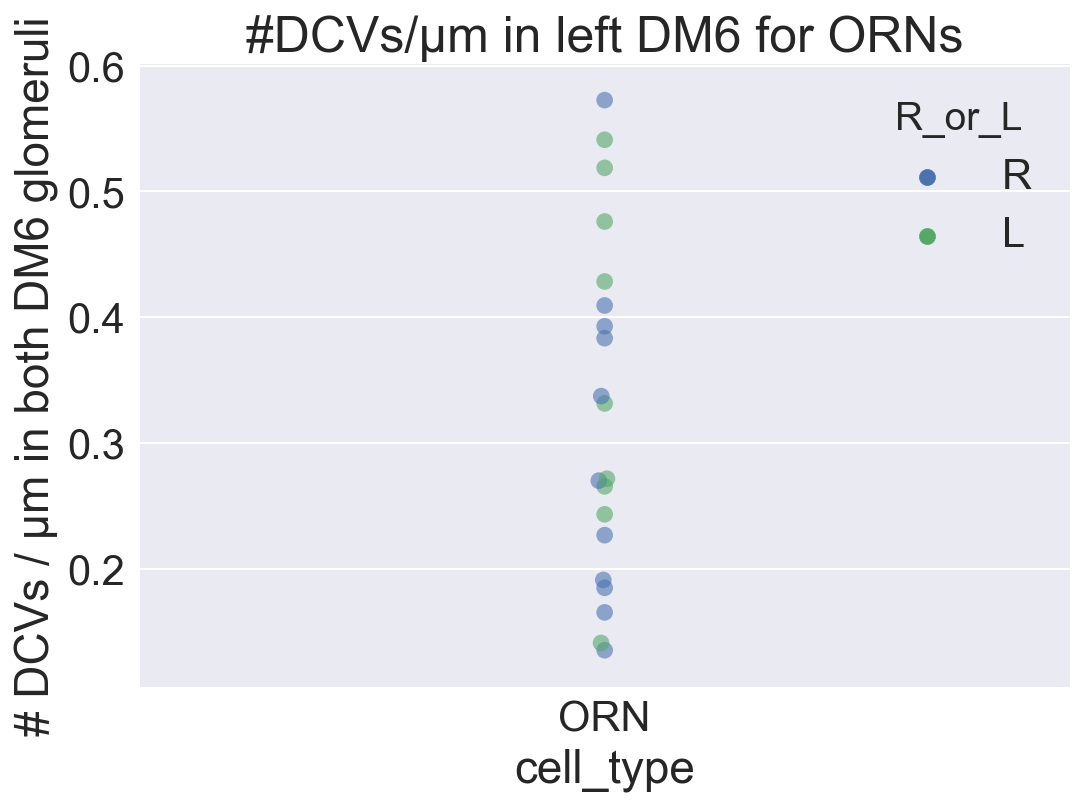

In [107]:
# Plot prop of DCVs within DM6 (L)
sns.swarmplot(x = "cell_type", y='LEFT_DM6_DCV/DM6_length', hue = "R_or_L", data = DM6_ORN_DCV_counts, alpha = .6, size = 8)
plt.ylabel('# DCVs / µm in both DM6 glomeruli')
plt.title('#DCVs/µm in left DM6 for ORNs')
# plt.xlabel('ONs')
# plt.ylim([0,1.4])
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV per um full cells.pdf')

/Users/hannah/git/LeeLabScripts/figures


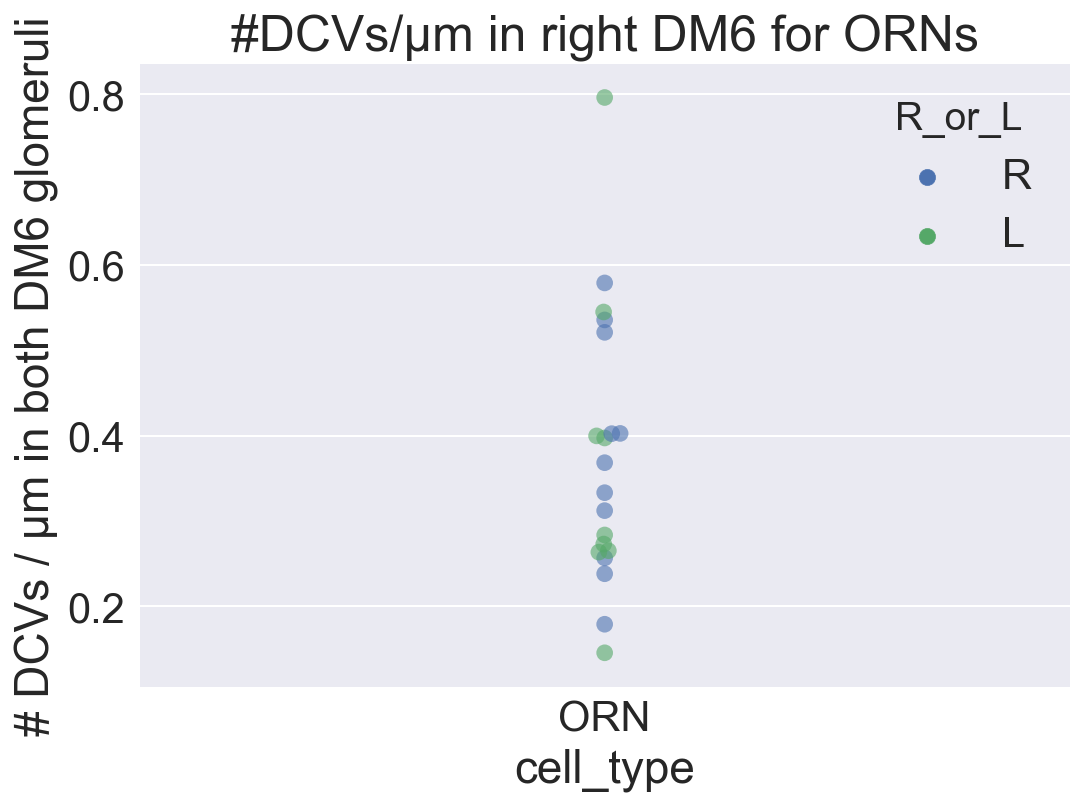

In [108]:
# Plot prop of DCVs within DM6 (R)
sns.swarmplot(x = "cell_type", y='RIGHT_DM6_DCV/DM6_length', hue = "R_or_L", data = DM6_ORN_DCV_counts, alpha = .6, size = 8)
plt.ylabel('# DCVs / µm in both DM6 glomeruli')
plt.title('#DCVs/µm in right DM6 for ORNs')
# plt.xlabel('ONs')
# plt.ylim([0,1.4])
%cd /Users/hannah/git/LeeLabScripts/figures
# plt.savefig('DCV per um full cells.pdf')

# Calculate distance from pre- and post-synaptic sites

Schlegel et al., 2016 excluded DCVs within in 3,000 nm radius of the neurons' somata (likely because immature DCVs can be found within the cell body). They also calculated the percent of presynaptic sites that have DCVs in their proximity (DCVs located within 1000nm radius of presynaptic site). I will use the same criteria, and also perform similar analyses on postsynaptic sites. However, I want to first get a sense for how close presynaptic sites are to eachother. For example, presynaptic "regions" may overlap, which would mean that we might need to adjust are distance criteria or think about whether it's reasonable to have DCVs blonging to two different presynaptic sites. -- Would this really be that problematic??

In [109]:
# Get pre and post-synaptic sites
All_prepost_df = get_connectors(   all_neurons,
                            Myinstance,
                            incoming_synapses = True,
                            outgoing_synapses = True,
                            abutting = False,
                            gap_junctions = False,
                            project_id = 3,
                            tag_flag = False
                        )
print('Connectors retrieved:', len(All_prepost_df))

# Remove unwanted columns
All_prepost_df = All_prepost_df.drop(['confidence', 'creator_id', 'creation_time', 'edition_time'], axis=1)

All_prepost_df.head()

2018-01-12 16:20:51,095 - pymaid.pymaid - INFO - 28660 connectors for 65 neurons retrieved
INFO:pymaid.pymaid:28660 connectors for 65 neurons retrieved


Connectors retrieved: 28660


,skeleton_id,connector_id,x,y,z,treenode_id,type
0,75022,10508,459804,239488,16480,13908805,presynaptic_to
1,75022,10699,412476,236776,17640,653754,presynaptic_to
2,75022,9388,411704,238752,17280,653767,presynaptic_to
3,75022,14712,411190,238872,16600,653792,presynaptic_to
4,75022,6887,410602,238056,15680,653831,presynaptic_to


Since there was an issue with duplicate DCVs using get_connectors, I want to make sure that there are no duplicates in pre/post synaptic sites obtained using the same function

In [110]:
# Are there duplicated pre/post??????
prepost_df_test = All_prepost_df.copy()
# Dropping dup with both cn_id and (type, treenode_id) because pre/post pairs will have the same cn_id. This way,
# pre/post pairs are kept, and one is not mistakenly dropped
prepost_df_test = prepost_df_test.drop_duplicates(subset = ['connector_id', 'type', 'treenode_id'], keep = 'first')
prepost_df_test.reset_index(drop = True, inplace = True)
print(All_prepost_df.shape)
print(prepost_df_test.shape)

non_dup_prepost = prepost_df_test['connector_id'].tolist()

(28660, 7)
(15949, 7)


In [111]:
# Get list of duplicated pre/post
duplicated_prepost = All_prepost_df[All_prepost_df.duplicated(subset = ['connector_id', 'type', 'treenode_id'], keep=False)]
duplicated_prepost = duplicated_prepost.drop_duplicates(subset = ['connector_id', 'type', 'treenode_id'])

# Find skel_ids that show duplicated pre/post
dupl_prepost_skel_id = duplicated_prepost['skeleton_id'].tolist()

# Get list of skel_ids showing duplicates for pre/post sites
dupl_prepost_skel_id = list(set(dupl_prepost_skel_id))
print(len(dupl_prepost_skel_id))

35


SO yes, pre/post connectors are showing duplicates when obtained using get_connectors with a list of ALL skel_ids. However, if we break up the list and run get_conenctors with fewer skel_ids, it seems to be fine. There is something strange in Phillip's notes in the get_connectors function where he said there is an issuing running >50 skel_ids at once. Maybe something re that is at play.

In [112]:
#Retrieve all abutting connectors for neurons
# ORNs
ORNs_prepost_df = get_connectors(   ORNs,
                            Myinstance,
                            incoming_synapses = True,
                            outgoing_synapses = True,
                            abutting = False,
                            gap_junctions = False,
                            project_id = 3,
                            tag_flag = True
                        )
print('Connectors retrieved:', len(ORNs_prepost_df))

# PNs
PNs_prepost_df = get_connectors(   PNs,
                            Myinstance,
                            incoming_synapses = True,
                            outgoing_synapses = True,
                            abutting = False,
                            gap_junctions = False,
                            project_id = 3,
                            tag_flag = True
                        )
print('Connectors retrieved:', len(PNs_prepost_df))

# LNs
LNs_prepost_df = get_connectors(   LNs,
                            Myinstance,
                            incoming_synapses = True,
                            outgoing_synapses = True,
                            abutting = False,
                            gap_junctions = False,
                            project_id = 3,
                            tag_flag = True
                        )
print('Connectors retrieved:', len(LNs_prepost_df))

prepost_df = pd.concat([ORNs_prepost_df, PNs_prepost_df, LNs_prepost_df],axis=0)
prepost_df.reset_index(drop = True, inplace = True)
prepost_df.shape

2018-01-12 16:20:51,457 - pymaid.pymaid - INFO - 3061 connectors for 20 neurons retrieved
INFO:pymaid.pymaid:3061 connectors for 20 neurons retrieved


Connectors retrieved: 3061


2018-01-12 16:20:52,702 - pymaid.pymaid - INFO - 9440 connectors for 5 neurons retrieved
INFO:pymaid.pymaid:9440 connectors for 5 neurons retrieved


Connectors retrieved: 9440


2018-01-12 16:20:53,298 - pymaid.pymaid - INFO - 3448 connectors for 40 neurons retrieved
INFO:pymaid.pymaid:3448 connectors for 40 neurons retrieved


Connectors retrieved: 3448


(15949, 12)

In [113]:
# Let's double check that there are no issues when I get pre/post sites with cell groups individually
# This is the df gathered with all neurons with dup removed: prepost_df_test
# This is the df gathered with diff cell types run individually: prepost_df

rows_in_both = pd.merge(prepost_df_test, prepost_df, on = ['connector_id', 'type', 'treenode_id'], how = 'inner')
print(rows_in_both.shape)

(15949, 16)


Yes, these are both the same. So it looks like we can get non-dup pre/post by filtering df gathered from running 
all neurons or running the difference cell types individually. I will write PS to make sure he is aware of this. I'd hate for this bug to mess with his analyses.

In [114]:
def distance(xyz_list):
    """Calcualtes distance between two xyz points
    
    Input list of xyz values for two points 
    EXAMPLE: [x1, y1, z1, x2, y2, z2]
    
    Output: distance
    
    """
    if len(xyz_list) != 6:
        print('Please provide a list of 2 zyz values')
    else:
        # Spelling this out so the input is clear
        x1 = xyz_list[0]
        y1 = xyz_list[1]
        z1 = xyz_list[2]
        x2 = xyz_list[3]
        y2 = xyz_list[4]
        z2 = xyz_list[5]
    return sum([(((x2 - x1) ** 2) + ((y2 - y1) ** 2) + ((z2 - z1) ** 2)) ** 0.5])  

In [115]:
# # Get presyanptic sites
# pre_75022_df = prepost_df[prepost_df['skeleton_id'] == 75022]
# pre_75022_df = pre_75022_df[pre_75022_df['type'] == 'presynaptic_to']
# pre_75022_df.head()

# #Create column in pre_75022_df for each presynaptic connector ID
# for (index, row) in pre_75022_df.iterrows():
#     pre_75022_df[pre_75022_df['connector_id'][index]] = 'Nan'
    
# # Get distance between each pair of presynaptic partners
# for (index, row) in pre_75022_df.iterrows():
    
#     # Get xyz for connector_ID
#     connector_xyz = []
    
#     for i in list(range(2, 5)):
#         connector_xyz.append(pre_75022_df.iat[index, i])
    
#     # pre_site iterator
#     pre_site_i = 0
    
#     # Get each presynaptic connector ID for this neuron
#     # shape[1] gives you the number of columns in DF
#     for pre_site in list(range(7,pre_75022_df.shape[1])):
        
#         # get xyz for pre-partner
#         pre_site_XYZ = []
        
#         for i in list(range(2, 5)):
#             pre_site_XYZ.append(pre_75022_df.iat[pre_site_i, i])
            
        
#         # Calculate distance
#         # Put connector and Prepartner XYZ lists together
#         XYZ_lists = connector_xyz + pre_site_XYZ
        
#         dist = distance(XYZ_lists)
        
#         # Put distance value in dataframe
#         pre_75022_df.iat[index, pre_site] = dist
            
#         pre_site_i += 1
        

# # Calculate pre_site with shortest distance to each DCV.
# # Create DF with just distance values
# lengths = pre_75022_df[pre_75022_df.columns[7:pre_75022_df.shape[1]]]

# # Calcualte for each DCV to closest presynaptic connector 
# # Need to first Nan out 0 values
# lengths = lengths.replace(0, np.NaN)

# pre_75022_df['min_length'] = lengths.min(axis=1)

# # Determine identity of presynaptic connector ID
# pre_75022_df['closest_pre_site'] = lengths.idxmin(axis=1)

In [116]:
# sns.set_style("whitegrid")
# ax = sns.swarmplot(x=pre_75022_df['min_length'], alpha =.5, orient = "v")
# # ax.set(yscale ='log')
# plt.title('Distance from each presynaptic site to its closest presynaptic site in ORN 1')
# plt.xlabel('75022')
# plt.ylabel('Distance (nm)')

# # Calculate the percent of DCVs that are localized to presynaptic sites
# min_length_75002 = pre_75022_df[['min_length']]
# min_length_75002['skel_id'] = '75002'
# DCV_within_pre_site = min_length_75002[min_length_75002 < 1000].count()
# total_num_DCV = len(min_length_75002)
# percent_DCV_within_pre_site = (DCV_within_pre_site/total_num_DCV) * 100
# print('Percent presynaptic pairs within 1000 nm:', percent_DCV_within_pre_site[0], '%')

In [117]:
# lengths
# p = lengths[lengths < 1000].count()
# p.hist(bins = 20)
# print(len(p))
# plt.xlabel('Number of presynaptic sites within 1000 nm of each presynaptic site')
# plt.ylabel('Number of presynaptic sites')
# plt.title('75022')

In [118]:
# # Get presyanptic sites
# pre_109478_df = prepost_df[prepost_df['skeleton_id'] == 109478]
# pre_109478_df = pre_109478_df[pre_109478_df['type'] == 'presynaptic_to']
# pre_109478_df.reset_index(drop = True, inplace = True)

# #Create column in pre_109478_df for each presynaptic connector ID
# for (index, row) in pre_109478_df.iterrows():
#     pre_109478_df[pre_109478_df['connector_id'][index]] = 'Nan'
    
# # Get distance between each pair of presynaptic partners
# for (index, row) in pre_109478_df.iterrows():
    
#     # Get xyz for connector_ID
#     connector_xyz = []
    
#     for i in list(range(2, 5)):
#         connector_xyz.append(pre_109478_df.iat[index, i])
    
#     # pre_site iterator
#     pre_site_i = 0
    
#     # Get each presynaptic connector ID for this neuron
#     # shape[1] gives you the number of columns in DF
#     for pre_site in list(range(7,pre_109478_df.shape[1])):
        
#         # get xyz for pre-partner
#         pre_site_XYZ = []
        
#         for i in list(range(2, 5)):
#             pre_site_XYZ.append(pre_109478_df.iat[pre_site_i, i])
            
        
#         # Calculate distance
#         # Put connector and Prepartner XYZ lists together
#         XYZ_lists = connector_xyz + pre_site_XYZ
        
#         dist = distance(XYZ_lists)
        
#         # Put distance value in dataframe
#         pre_109478_df.iat[index, pre_site] = dist
            
#         pre_site_i += 1
        

# # Calculate pre_site with shortest distance to each DCV.
# # Create DF with just distance values
# lengths = pre_109478_df[pre_109478_df.columns[7:pre_109478_df.shape[1]]]

# # Calcualte for each DCV to closest presynaptic connector 
# # Need to first Nan out 0 values
# lengths = lengths.replace(0, np.NaN)

# pre_109478_df['min_length'] = lengths.min(axis=1)

# # Determine identity of presynaptic connector ID
# pre_109478_df['closest_pre_site'] = lengths.idxmin(axis=1)

In [119]:
# sns.set_style("whitegrid")
# ax = sns.swarmplot(x=pre_109478_df['min_length'], alpha =.5, orient = "v")
# # ax.set(yscale ='log')
# plt.title('Distance from each presynaptic site to its closest presynaptic site in PN1 LS')
# plt.xlabel('109478')
# plt.ylabel('Distance (nm)')

# # Calculate the percent of DCVs that are localized to presynaptic sites
# min_length_109478 = pre_75022_df[['min_length']]
# min_length_109478['skel_id'] = '109478'
# DCV_within_pre_site = min_length_109478[min_length_109478 < 1000].count()
# total_num_DCV = len(min_length_109478)
# percent_DCV_within_pre_site = (DCV_within_pre_site/total_num_DCV) * 100
# print('Percent presynaptic pairs within 1000 nm:', percent_DCV_within_pre_site[0], '%')

In [120]:
# lengths
# p = lengths[lengths < 1000].count()
# p.hist(bins = 20)
# print(len(p))
# plt.xlabel('Number of presynaptic sites within 1000 nm of each presynaptic site')
# plt.ylabel('Number of presynaptic sites')
# plt.title('109478')

From these data it looks like resynaptic sites are very close; however, this 